# Задача 5. Экспериментальное исследование алгоритмов для регулярных запросов

## Введение / постановка задачи
Задача посвящена анализу производительности алгоритма решения задачи достижимости между всеми парами вершин и с заданным множеством стартовых вершин с регулярными ограничениями.

Исследуются три задачи достижимости, решаемые в предыдущих работах.
* Достижимость между всеми парами вершин.
* Достижимость для всего множества заданных вершин.
* Достижимость для каждой из заданного множества стартовых вершин.

Вопросы, на которые необходимо ответить в ходе исследования.
* Какое представление разреженных матриц и векторов лучше подходит для каждой из решаемых задач?
* Начиная с какого размера стартового множества выгоднее решать задачу для всех пар и выбирать нужные?
* На сколько решение третьей задачи медленнее решения второй при одинаковых начальных условиях?

## Описание исследуемых решений
* Достижимость между всеми парами вершин, которая реализована с помощью тензорного произведения.
    - Получаем матрицу смежности конечного автомата, распознающего пересечение языков, задаваемых входными графом и регулярным выражением, с помощью произведения Кронекера 
    - Редуцируем ее до одной булевой матрицы
    - Находим транзитивное замыкание полученной булевой матрицы
    - Определяем все пары вершин, с помощью перебора всех ненулевых элементов полученной на предыдущем шаге матрицы, $(u, v)$ входного графа такие, что вершина $v$ достижима из вершины $u$ с данным регулярным ограничением
* Достижимость для всего множества заданных вершин, которая реализована с помощью итеративного произведения графа на фронт BFS для всех стартовых вершин.
    - Во время синхронного обхода в ширину входного графа и конечного автомата, соответствующего входному регулярному выражению, поддерживаются две булевы матрицы
    - На пересечении $i$-ой строки и $j$-ого столбца стоит единица, если $i$-ое состояние автомата является начальным, а $j$-ая вершина графа входит в стартовое множество
    - На каждом шаге синхронного обхода для получения нового `front`-а производится умножение матрицы `front` на матрицу смежности графа и переупорядочивание её строк в соответствии с матрицей смежности автомата, после чего к новому фронту применяется комплиментарная маска `visited` и он прибавляется к матрице `visited`
    - Процесс продолжается, пока `front` не станет нулевым
* Достижимость для каждой вершины из заданного множества стартовых вершин, которая реализована с помощью итеративного произведения графа на фронт BFS, где у каждой стартовой вершины фронт свой.
    - Задача решается путём параллельного решения предыдущей задачи с одно элементным стартовым множеством для каждой стартовой вершины
    - Параллельность достигается с помощью замены матрицы `front` на соединение по-вертикале матриц `front`, соответствующих каждому одно элементному стартовому множеству, и аналогичной замены для матрицы `visited`

## Requirements

In [14]:
# !git clone https: // github.com/Alexander-Zadorozhnyy/formal-lang-course.git
# %cd formal-lang-course
# !git checkout hw5
# !git pull
# !pip install -r requirements.txt

## Imports

In [15]:
from itertools import chain
import logging
import math
import sys
import time
from typing import List, Any, Union

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
import pyformlang.regular_expression as re
from pyformlang.regular_expression import Regex
from scipy import stats
from scipy.sparse import csc_matrix, csr_matrix, dok_matrix, lil_matrix
import textwrap

from project.graph.graph_worker import GraphWorker
from project.regex_and_automata.regex_func import convert_regex_to_minimal_dfa

sys.path.insert(0, "/content/formal-lang-course")

In [16]:
logging.disable(logging.INFO)

## Описание начальных данных для проведения эксперимента

### Выбор графов для анализа

Все возможные графы для анализа взяты из пакета [CFPQ_Data](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/). Данная библиотека содержит в себе различные графы, обладающие как большим количеством вершин, так и ребер.

 Далее приведён график, показывающий число вершин и различных меток в графах из данного набора данных, содержащих до $50\ 000$ вершин и до $100\ 00$ рёбер, большее количество невозможно проанализировать из-за ограничений на время проведения эксперимента.

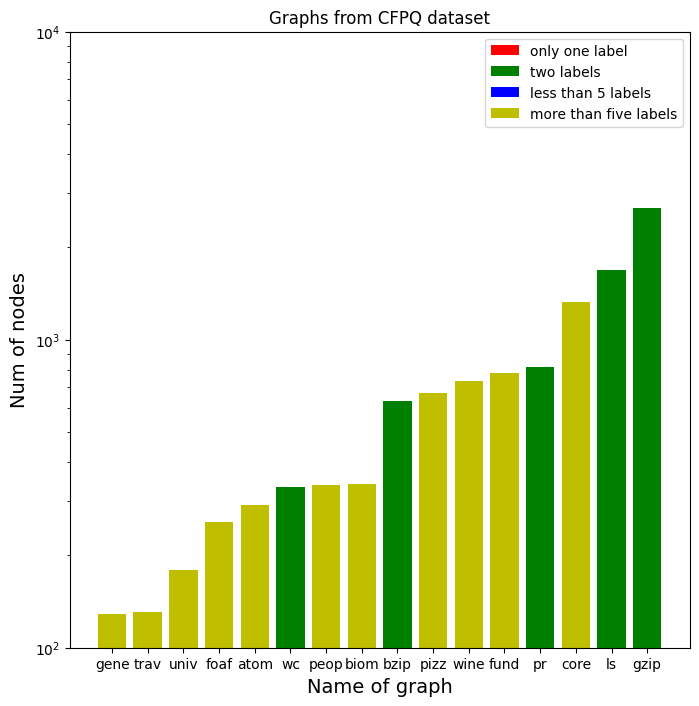

In [17]:
GRAPHS = ["wc", "generations", "travel", "univ", "atom", "biomedical", "bzip",
          "foaf", "people", "pr", "funding", "ls", "wine", "pizza", "gzip", "core"]

gw = GraphWorker()

stat = []
for graph in GRAPHS:
    gw.load_graph_by_name(graph)
    stat += [(graph, gw.get_graph_info())]

stat.sort(key=lambda elem: elem[1]['num_of_nodes'])

labels = [
    textwrap.shorten(graph, 4, placeholder="") for (graph, _) in stat
]

values = [graph_info['num_of_nodes'] for (_, graph_info) in stat]


def choose_color(label_occ):
    if label_occ == 1:
        return "r"
    if label_occ == 2:
        return "g"
    if label_occ < 5:
        return "b"
    return "y"


colors = [choose_color(len(graph_info['set_of_labels'])) for (_, graph_info) in stat]

plt.figure(figsize=(8, 8))
plt.bar(np.arange(len(labels)), values, color=colors)
plt.title("Graphs from CFPQ dataset")

plt.ylabel("Num of nodes", fontsize=14)
plt.yscale("log")
plt.yticks([100, 1000, 10_000])

plt.xlabel("Name of graph", fontsize=14)
plt.xticks(np.arange(len(labels)), labels, fontsize=10)
plt.legend(
    loc="upper right",
    handles=[
        Patch(facecolor="r", label="only one label"),
        Patch(facecolor="g", label="two labels"),
        Patch(facecolor="b", label="less than 5 labels"),
        Patch(facecolor="y", label="more than five labels"),
    ],
)
plt.show()

Как видно из графика, графы выбранного размера из набора данных имеют либо две различные метки рёбер, либо более пяти => было решено использовать графы из обеих этих групп различных размеров, для независимости оценки.

Для проведения эксперимента были выбраны следующие графы

In [18]:
GRAPHS = [
    "generations",
    "skos",
    "foaf",
    "wc",
    "biomedical",
    "bzip",
    "pizza",
    "pr",
    "funding",
    "gzip",
]

gw = GraphWorker()
stat = []
for graph in GRAPHS:
    gw.load_graph_by_name(graph)
    stat += [(graph, gw.get_graph_info())]

pd.DataFrame(
    [
        (
            elem[0],
            *elem[1].values()
        )
        for elem in stat
    ],
    columns=["Name", "Num of nodes", "Num of edges", "Num of labels"],
)

Name  Num of nodes  Num of edges  \
0  generations           129           273   
1         skos           144           252   
2         foaf           256           631   
3           wc           332           269   
4   biomedical           341           459   
5         bzip           632           556   
6        pizza           671          1980   
7           pr           815           692   
8      funding           778          1086   
9         gzip          2687          2293   

                                       Num of labels  
0  {intersectionOf, hasSibling, hasParent, range,...  
1  {unionOf, rest, first, inverseOf, range, seeAl...  
2  {domain, isDefinedBy, range, description, labe...  
3                                             {a, d}  
4  {creator, subClassOf, versionInfo, label, desc...  
5                                             {a, d}  
6  {minCardinality, unionOf, someValuesFrom, hasV...  
7                                             {a, d}  
8  {unionOf, imports, rest, first, inverseOf, ran...  
9                                             {a, d}

### Выбор запросов для анализа

Запросы ко всем графам следуют некоторым общим шаблонам:
* $(l_1 \ | \ l_3)$.
* $(l_1^* \ | \ l_2)^+ \ l_3$.
* $(l_3 \ | \ l_4)^* \ (l_2 l_4)^+$.
* $(l_1 \ | \ l_2)^+ (l_3 \ | \ l_4) l_1^*$.

Где $l_1, l_2, l_3, l_4$ --- это наиболее встречающиеся метки в конкретном графе.
Также, в случае если граф содержит < 4 меток, то добавим по уже существующие необходимое кол-во раз.

Далее приведен код для генерации соответствующих регулярных выражений

In [19]:
REGEX_COUNT = 4
REGEXES_REQUESTS = {
    "(l1 | l3)": lambda l1, l2, l3, l4: Regex(f"{l1} | {l3}"),
    "(l1* | l2)+ l3": lambda l1, l2, l3, l4: Regex(f"({l1}* | {l2})+ {l3}"),
    "(l3 | l4)* (l2 l4)+": lambda l1, l2, l3, l4: Regex(f"({l3} | {l4})* ({l2} {l4})+"),
    "(l1 | l2)+ (l3 | l4) l1*": lambda l1, l2, l3, l4: Regex(f"({l1} | {l2})+ ({l3} | {l4}) {l1}*")
}
REGEXES_LIST = REGEXES_REQUESTS.keys()


def take_graph_regexes(graph_labels: List[Any]) -> List[re.Regex]:
    graph_labels = graph_labels * (1 if REGEX_COUNT - len(graph_labels) <= 0 else math.ceil(
        (REGEX_COUNT - len(graph_labels)) / len(graph_labels)) + 1)
    return [regex_expr(*(graph_labels[:REGEX_COUNT])) for regex_expr in REGEXES_REQUESTS.values()]

Таким образом, удалось достичь следующих результатов:

In [20]:
def regexes_info() -> pd.DataFrame:
    stats = []

    for regex_view, regex_expr in [(regex_view, regex_expr("a", "b", "c", "d")) for regex_view, regex_expr in
                                   REGEXES_REQUESTS.items()]:
        min_dfa = convert_regex_to_minimal_dfa(regex_expr)
        stats.append([
            regex_view,
            len(min_dfa.symbols),
            len(min_dfa.states),
            min_dfa.get_number_transitions(),
        ])

    return pd.DataFrame(stats, columns=["Regex", "Symbols", "States", "Transitions"])


regexes_info()

Regex  Symbols  States  Transitions
0                 (l1 | l3)        2       2            2
1            (l1* | l2)+ l3        3       3            4
2       (l3 | l4)* (l2 l4)+        3       3            4
3  (l1 | l2)+ (l3 | l4) l1*        4       3            5

## Описание эксперимента


### Оборудование

----------------- Hardware Overview -----------------

Model Name: Acer Predator
Model Identifier: Helios 300
Processor: Intel Core i9 11th Gen
RAM: 16GB
Total Number of Cores: 14

----------------- Hardware Overview -----------------

### Проведение замеров: 

1. Для ответа на вопрос о том, какое представление матриц наиболее подходящее для решаемых задач, были проведены замеры на следующих представлениях разреженных матриц: 
    - [dok_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.dok_matrix.html#scipy.sparse.dok_matrix)
    - [lil_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.lil_matrix.html#scipy.sparse.lil_matrix)
    - [csc_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csc_matrix.html#scipy.sparse.csc_matrix)
    - [csr_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html#scipy.sparse.csr_matrix)

2. Для ответа на вопрос о том, при каких размерах стартового множества становится выгоднее решать задачу для всех пар, изменялось стартовое множество вершин, в то время как представление матрицы было зафиксировано.

3. Для ответа на вопрос о разнице во времени решения второй и третьей задачи достижимости были проведены замеры на графах с различными наборами стартовых вершин.

Замеры времени проводились с помощью Python библиотеки [time](https://docs.python.org/3/library/time.html). Время работы каждого алгоритма на каждом из входных данных замерялось 10 раз, далее вычислялось среднее арифметическое значение и стандартное отклонение.

In [21]:
MATRIX_TYPES = [csc_matrix, csr_matrix, dok_matrix, lil_matrix]
NUMBER_OF_TESTS = 10

### Start и Final nodes

Для генерации множество стартовых вершин использовалась функция [generate_multiple_source_percent](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/reference/graphs/generated/cfpq_data.graphs.utils.multiple_source_utils.html#cfpq_data.graphs.utils.multiple_source_utils.generate_multiple_source_percent). Также для однозначности и воспроизводимости эксперимента использовался параметр *seed*. 

Таким образом, для того чтобы изучить влияние размера стартового множества на время работы, будут рассмотрены измерения с различными значениями для параметра *percent*.

Конечно, множество финальных вершин также влияет на каждый из алгоритмов, поэтому для чистоты эксперимента все вершины графа принимаются за финальные.

In [22]:
SEED = 0
PERCENT = 10

### Отображение диаграмм

In [23]:
def draw_diagram(graph_name, percent, matrix_stat, matrices_type):
    index, bw, colors = np.arange(0, REGEX_COUNT), 0.1, ["r", "g", "b", "y"]

    plt.rcParams["figure.figsize"] = (10, 10)
    plt.title(f"{graph_name}: percent = {percent}%")

    for count, matrix_name in enumerate(matrices_type):
        plt.bar(index + (count + 1) * bw, matrix_stat[matrix_name.__name__]["time"], bw,
                yerr=matrix_stat[matrix_name.__name__]["tstd"],
                error_kw={'ecolor': '0.1', 'capsize': 5},
                alpha=0.8,
                color=colors[count],
                label=matrix_name.__name__)

    plt.xticks(index + bw, REGEXES_LIST)
    plt.legend(loc=1)
    plt.show()

### Получение данных для диаграммы и отрисовка

In [24]:
def rpq_request_performance_check(percent=PERCENT, type_matrices=MATRIX_TYPES, rpq_type: Union["bfs", "tensor"] = "bfs",
                                  is_single_mode: bool = False):
    gw = GraphWorker()

    global_matrix_stat = {"lil_matrix": {"time": [], "tstd": []},
                          "dok_matrix": {"time": [], "tstd": []},
                          "csr_matrix": {"time": [], "tstd": []},
                          "csc_matrix": {"time": [], "tstd": []}
                          }

    for graph_name in GRAPHS:
        gw.load_graph_by_name(graph_name)
        start_vertexes = gw.generate_multiple_source_percent(percent=percent, seed=SEED)
        regexes = take_graph_regexes(gw.get_sorted_labels_list())
        matrix_stat = {"lil_matrix": {"time": [], "tstd": []},
                       "dok_matrix": {"time": [], "tstd": []},
                       "csr_matrix": {"time": [], "tstd": []},
                       "csc_matrix": {"time": [], "tstd": []}
                       }

        for regex in regexes:
            for matrix_type in type_matrices:
                times = []
                for i in range(NUMBER_OF_TESTS):
                    start_time = time.time()
                    if rpq_type == "bfs":
                        gw.make_regular_request_bfs(
                            regex,
                            start_vertexes,
                            None,
                            is_single_mode,
                            matrix_type
                        )
                    else:
                        gw.make_regular_request(
                            regex,
                            start_vertexes,
                            None,
                            matrix_type
                        )
                    final_time = time.time()
                    times.append(final_time - start_time)

                matrix_stat[matrix_type.__name__]["time"].append(np.mean(times))
                matrix_stat[matrix_type.__name__]["tstd"].append(stats.tstd(times))
                global_matrix_stat[matrix_type.__name__]["time"].append(np.mean(times))
                global_matrix_stat[matrix_type.__name__]["tstd"].append(stats.tstd(times))

        draw_diagram(graph_name, percent, matrix_stat, type_matrices)

    for matrix_name in global_matrix_stat:
        global_matrix_stat[matrix_name]["time"] = np.mean(global_matrix_stat[matrix_name]["time"])
        global_matrix_stat[matrix_name]["tstd"] = np.mean(global_matrix_stat[matrix_name]["tstd"])
    return global_matrix_stat

# Замеры показателей каждого алгоритма

In [25]:
final_statistic = pd.DataFrame(columns=["name",
                                        "percent",
                                        "lil_matrix_time",
                                        "lil_matrix_tstd",
                                        "dok_matrix_time",
                                        "dok_matrix_tstd",
                                        "csr_matrix_time",
                                        "csr_matrix_tstd",
                                        "csc_matrix_time",
                                        "csc_matrix_tstd",
                                        ]
                               )


def update_statistic(name, percent, res: dict, df: pd.DataFrame) -> pd.DataFrame:
    data = list(chain.from_iterable(
        [(typed_matrix_stat["time"], typed_matrix_stat["tstd"]) for typed_matrix_stat in res.values()]))
    return pd.concat([df, pd.DataFrame([[name, percent, *data]], columns=df.columns)])

## Достижимость между всеми парами вершин.

### Алгоритм Tensor Multy

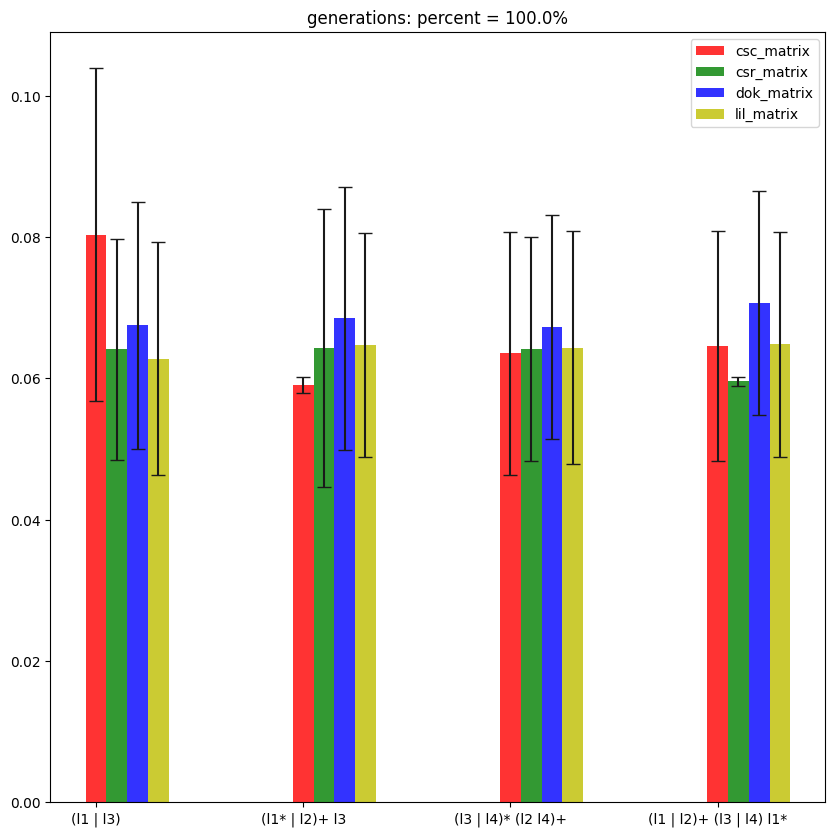

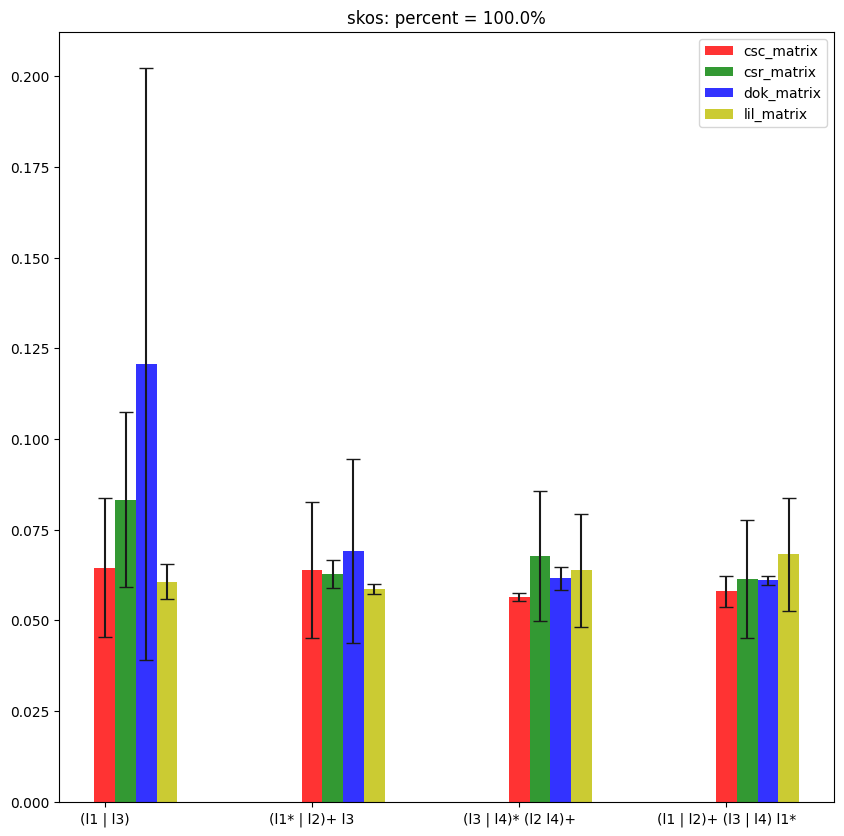

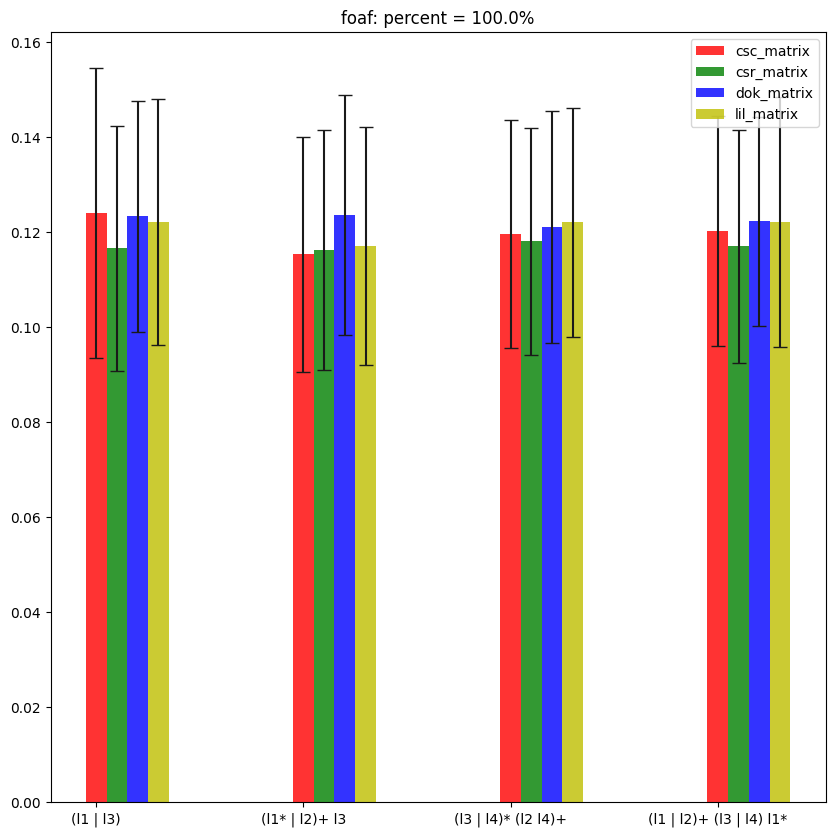

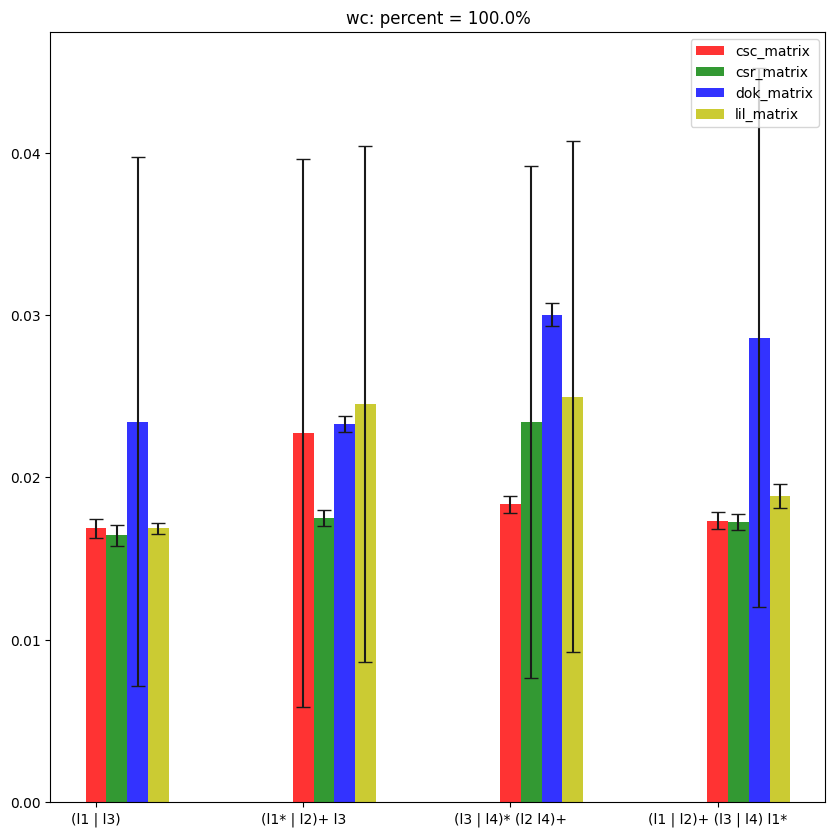

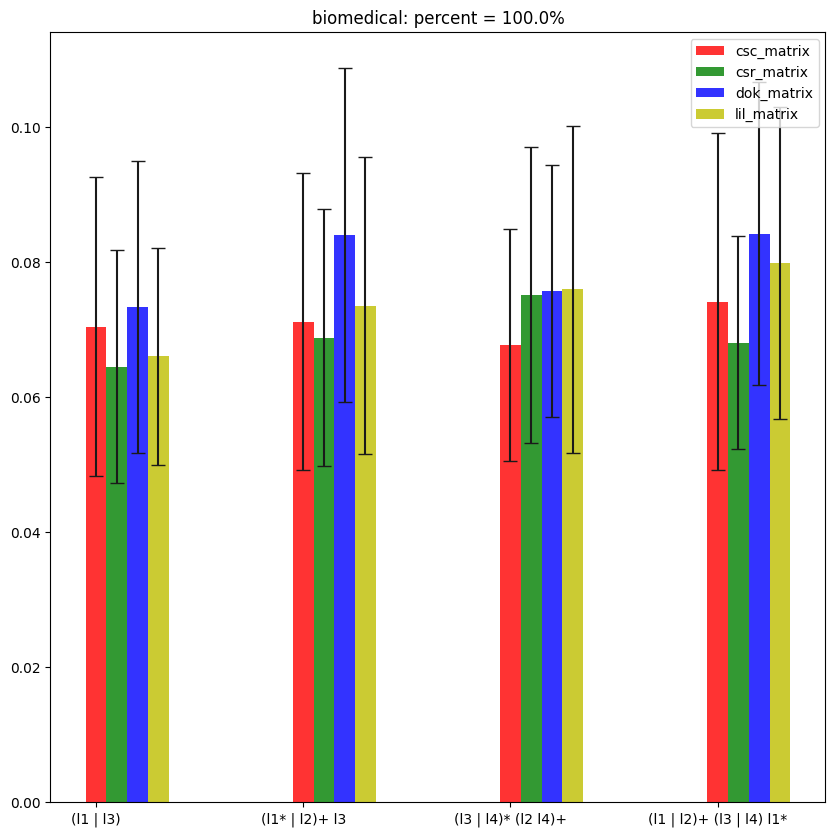

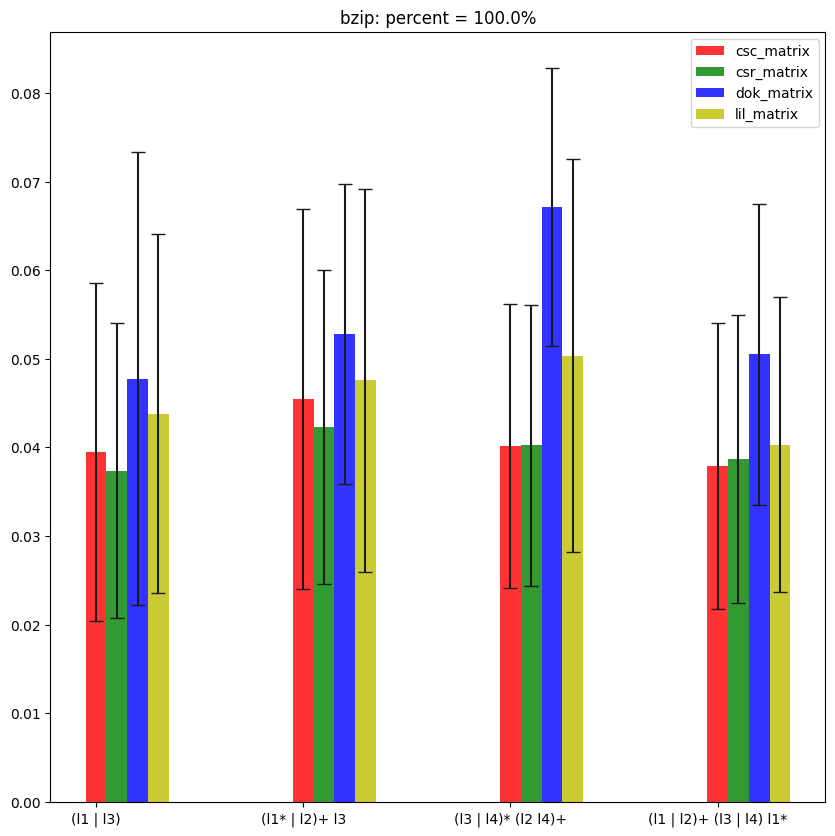

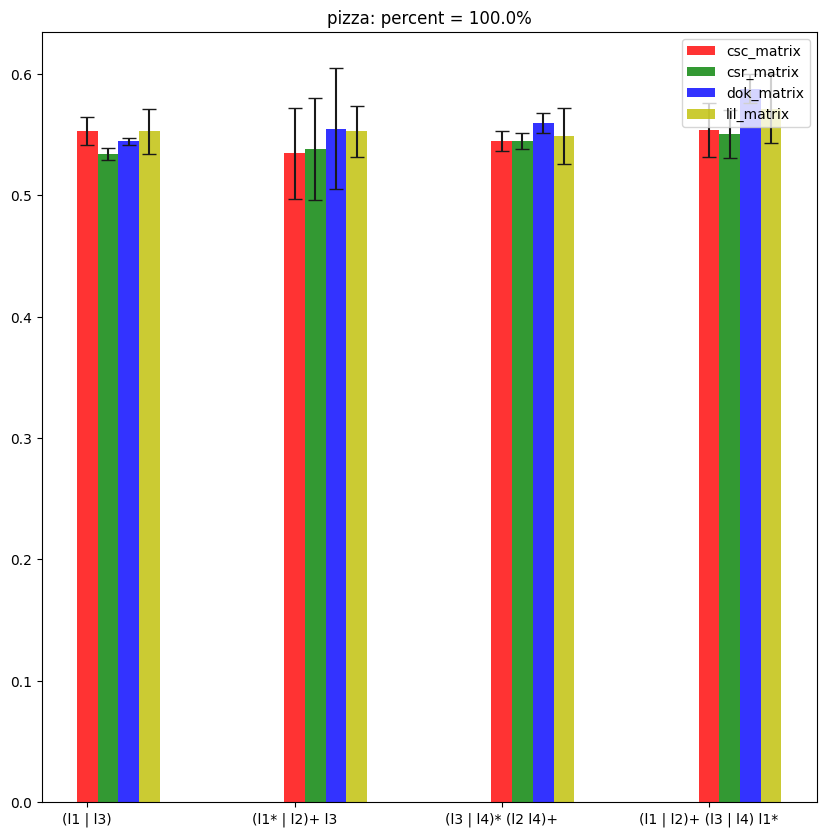

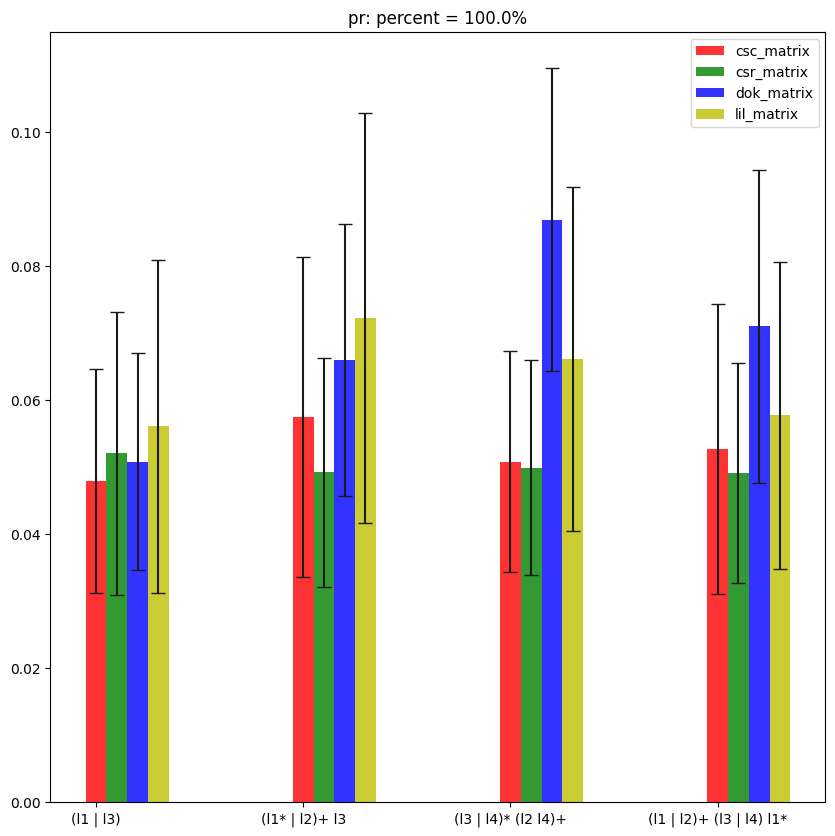

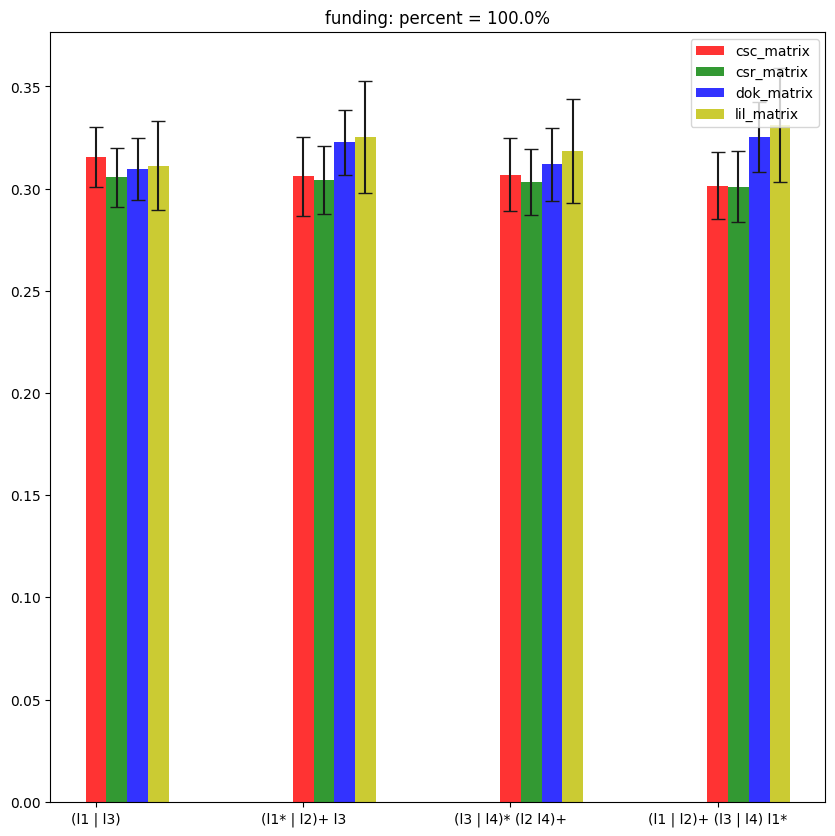

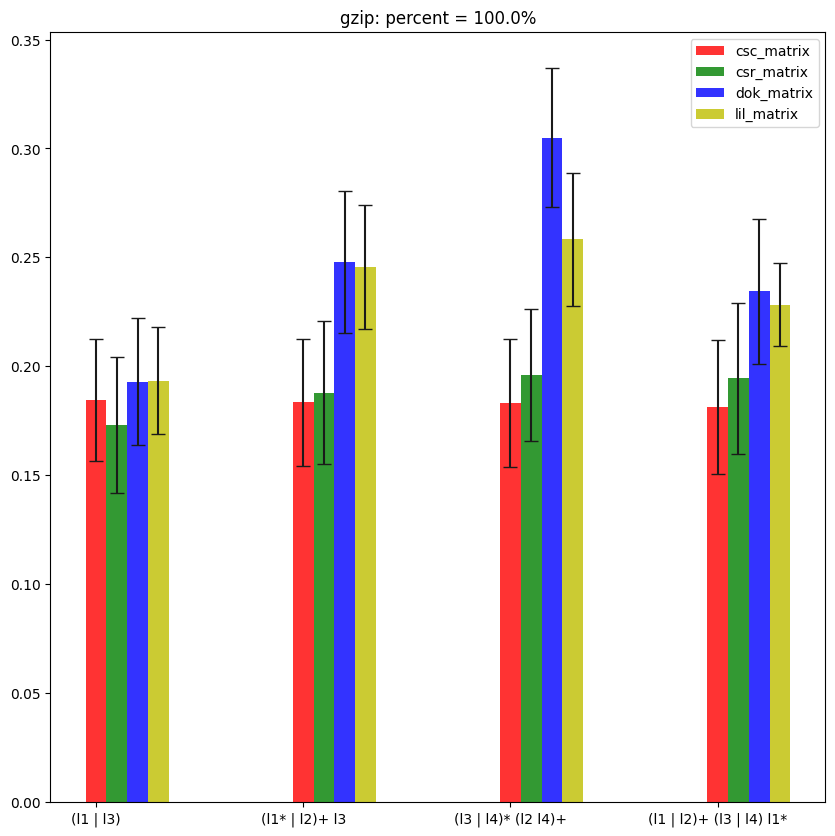

name percent  lil_matrix_time  lil_matrix_tstd  dok_matrix_time  \
0  all_pair_tensor     100          0.15608          0.02008         0.162223   

   dok_matrix_tstd  csr_matrix_time  csr_matrix_tstd  csc_matrix_time  \
0         0.020487          0.14594         0.017727           0.1467   

   csc_matrix_tstd  
0         0.018145

In [26]:
results = rpq_request_performance_check(percent=100.0, rpq_type="tensor")
final_statistic = update_statistic("all_pair_tensor", 100, results, final_statistic)
final_statistic

### Алгоритм BFS

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


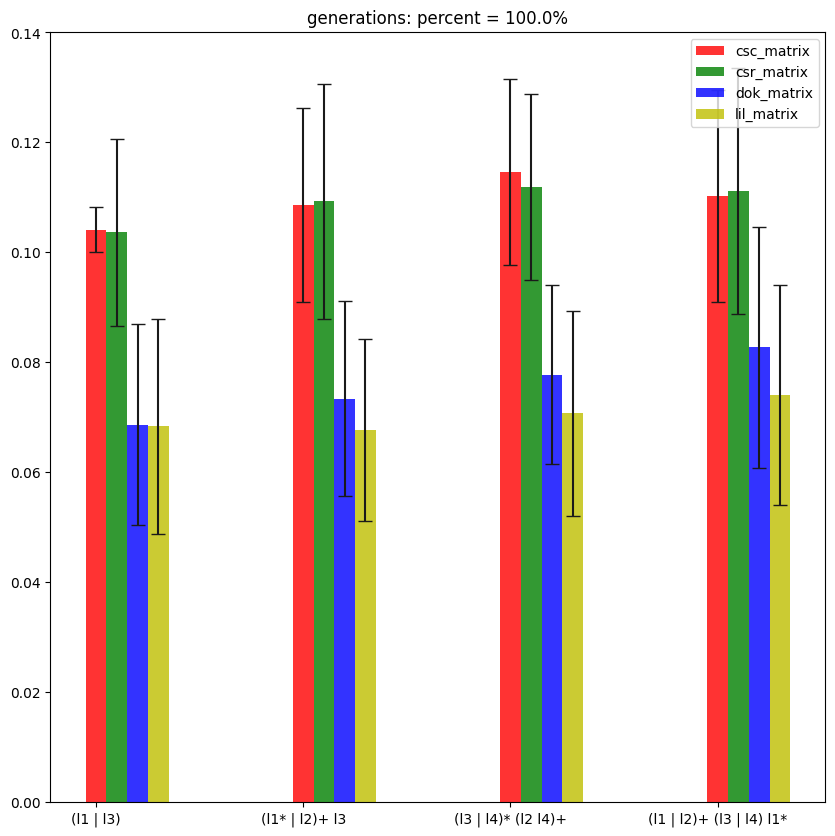

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


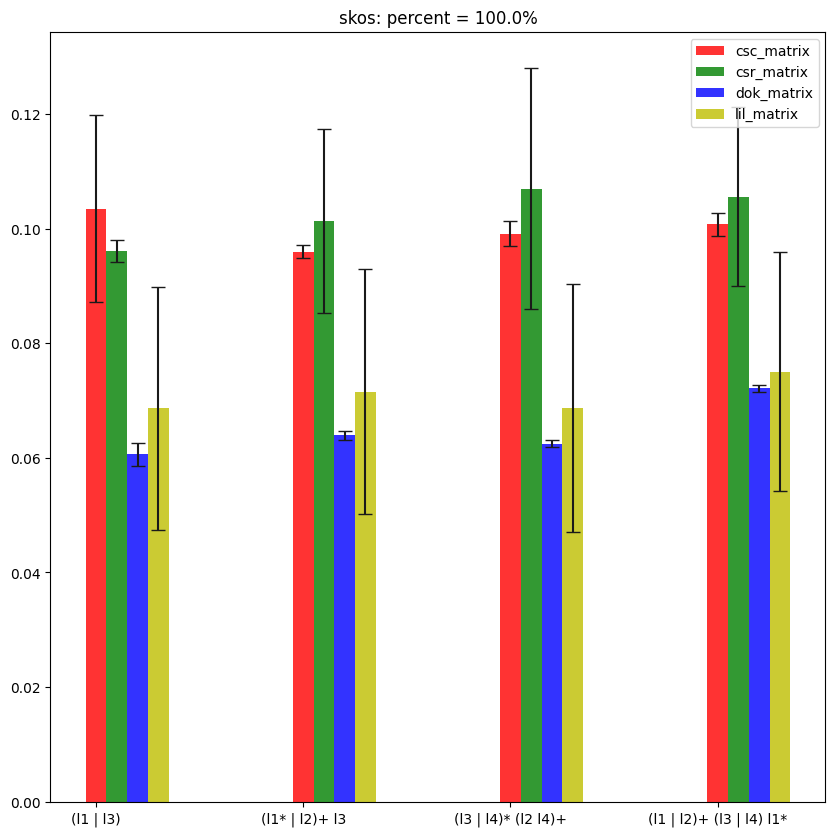

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


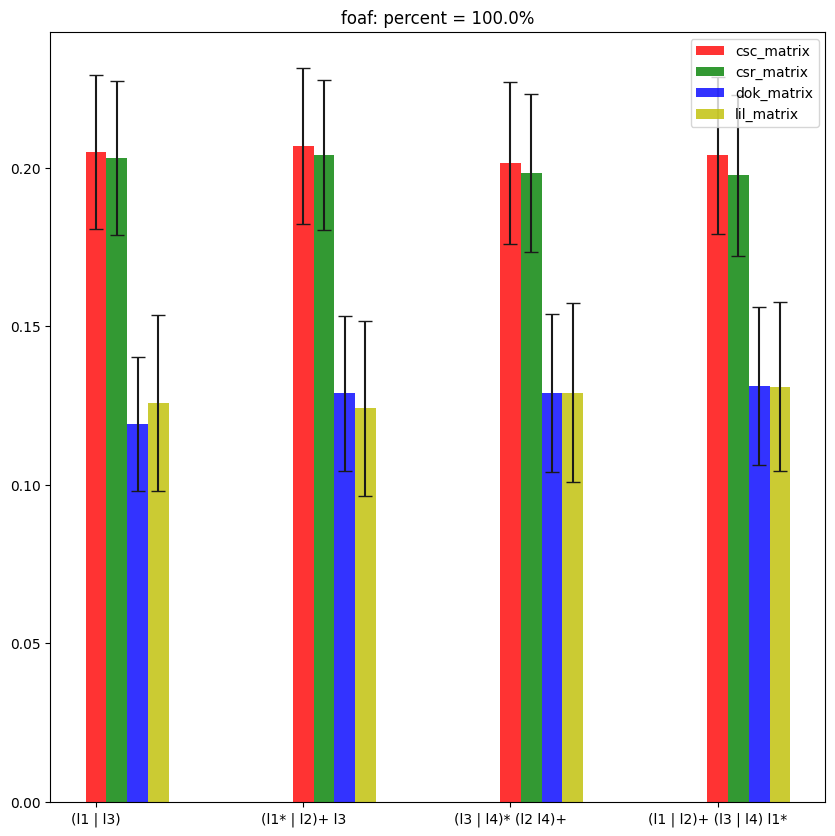

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


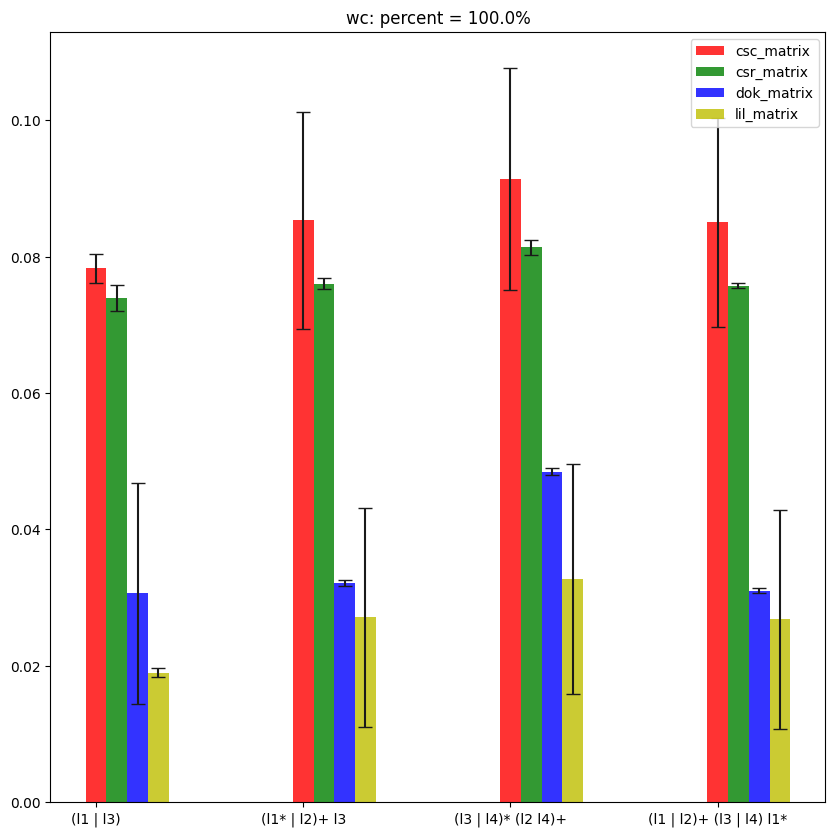

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


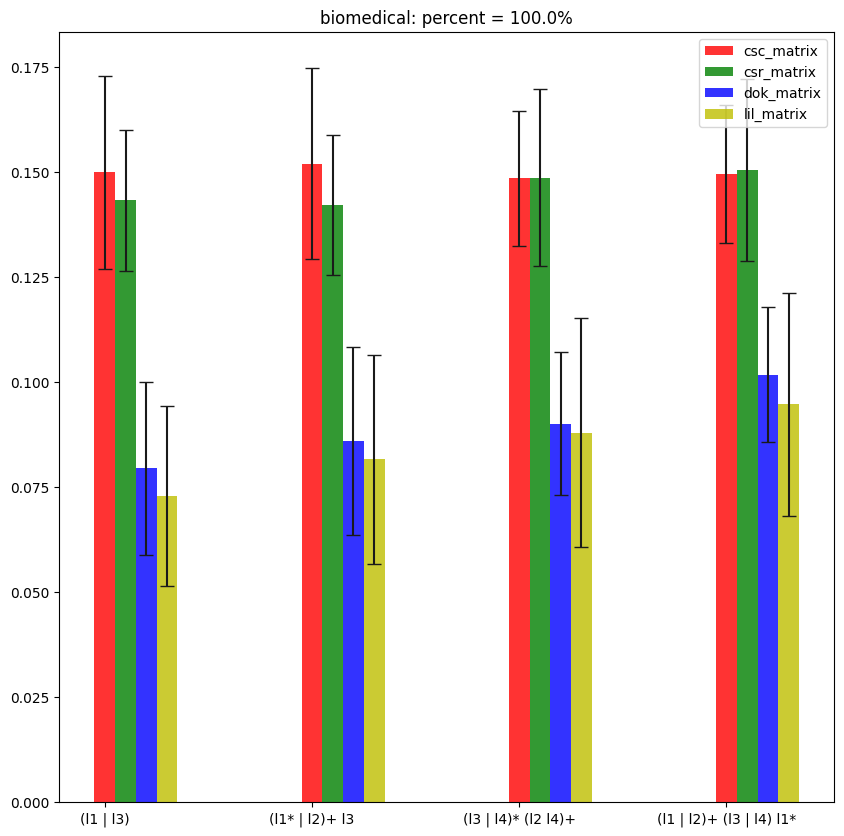

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


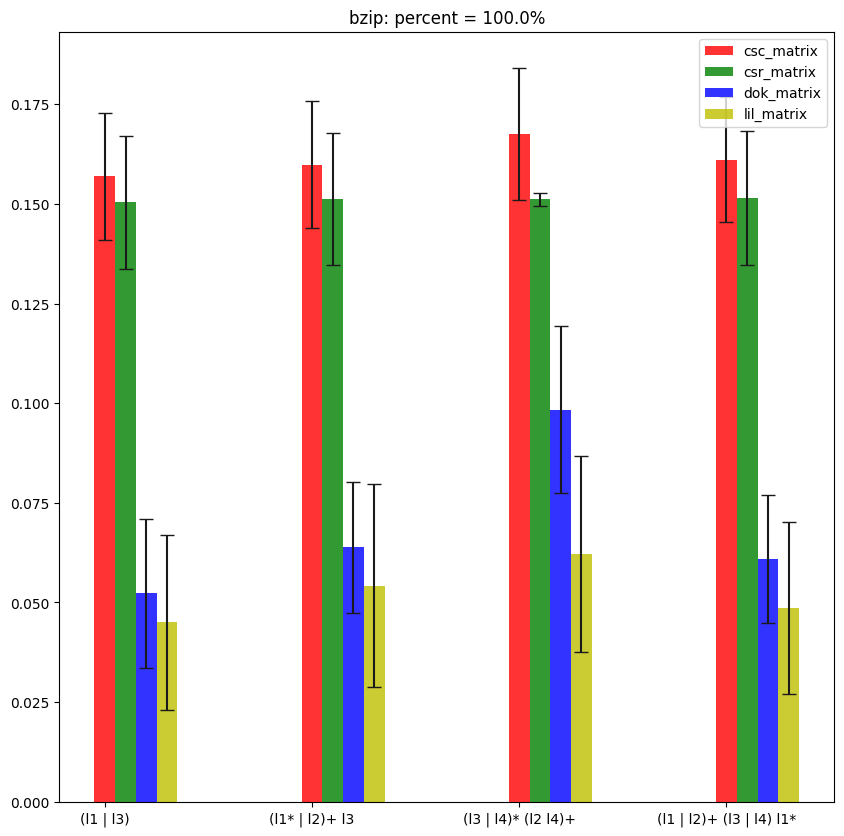

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


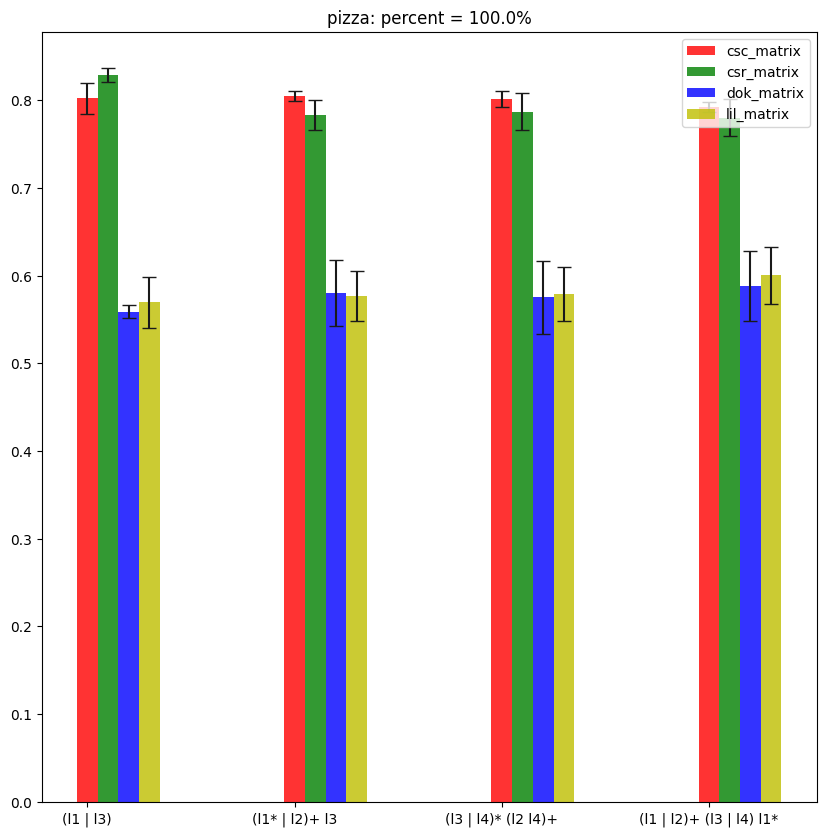

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


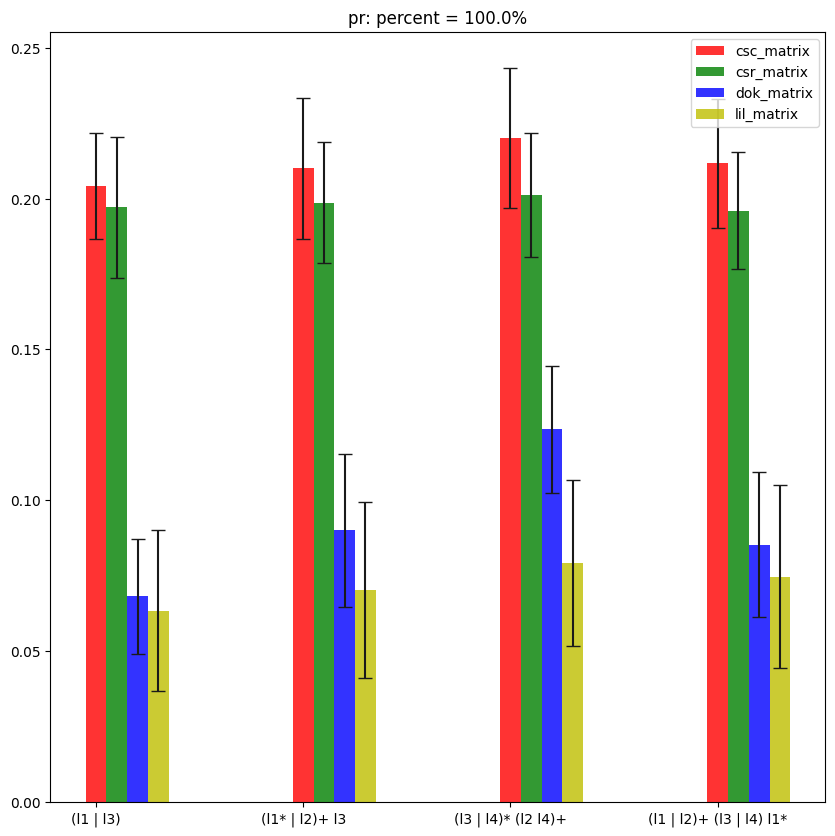

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


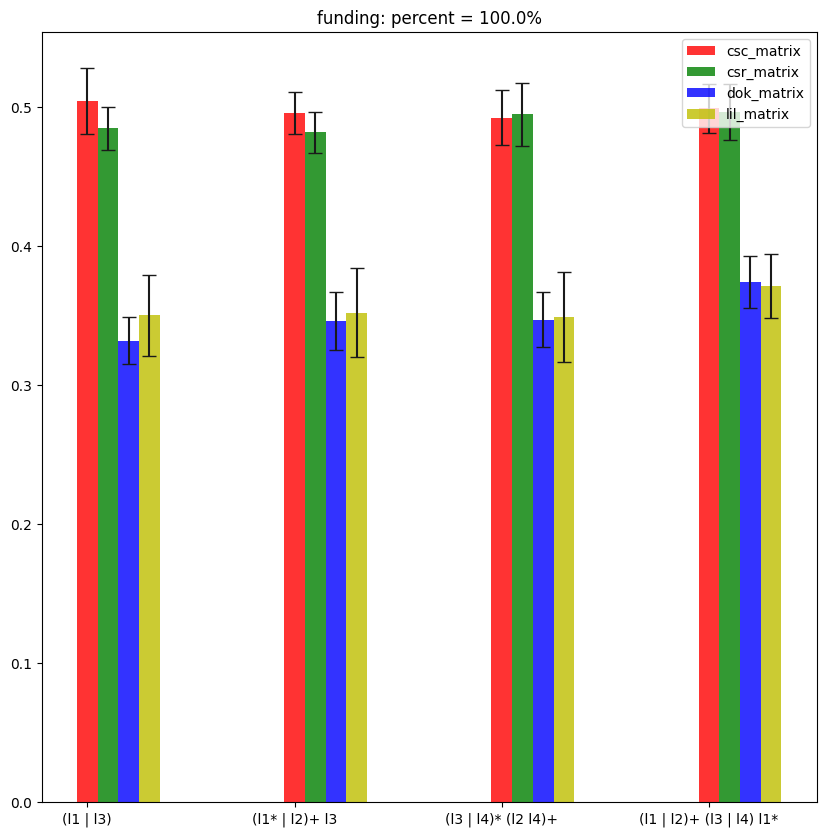

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


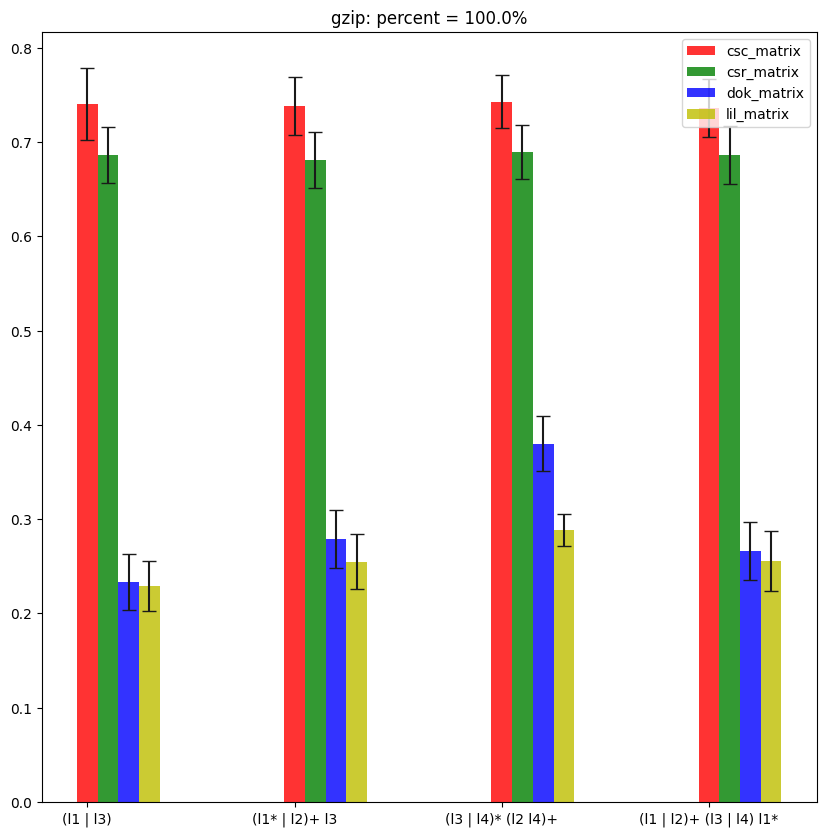

name percent  lil_matrix_time  lil_matrix_tstd  dok_matrix_time  \
0  all_pair_tensor     100         0.156080         0.020080         0.162223   
0     all_pair_bfs     100         0.169762         0.024241         0.176780   

   dok_matrix_tstd  csr_matrix_time  csr_matrix_tstd  csc_matrix_time  \
0         0.020487         0.145940         0.017727         0.146700   
0         0.018813         0.295483         0.017593         0.305924   

   csc_matrix_tstd  
0         0.018145  
0         0.017422

In [27]:
results = rpq_request_performance_check(percent=100.0, rpq_type="bfs")
final_statistic = update_statistic("all_pair_bfs", 100, results, final_statistic)
final_statistic

## Достижимость для всего множества заданных вершин.

In [28]:
percents = [10.0, 20.0, 50.0, 75.0]

### Алгоритм Tensor Multy

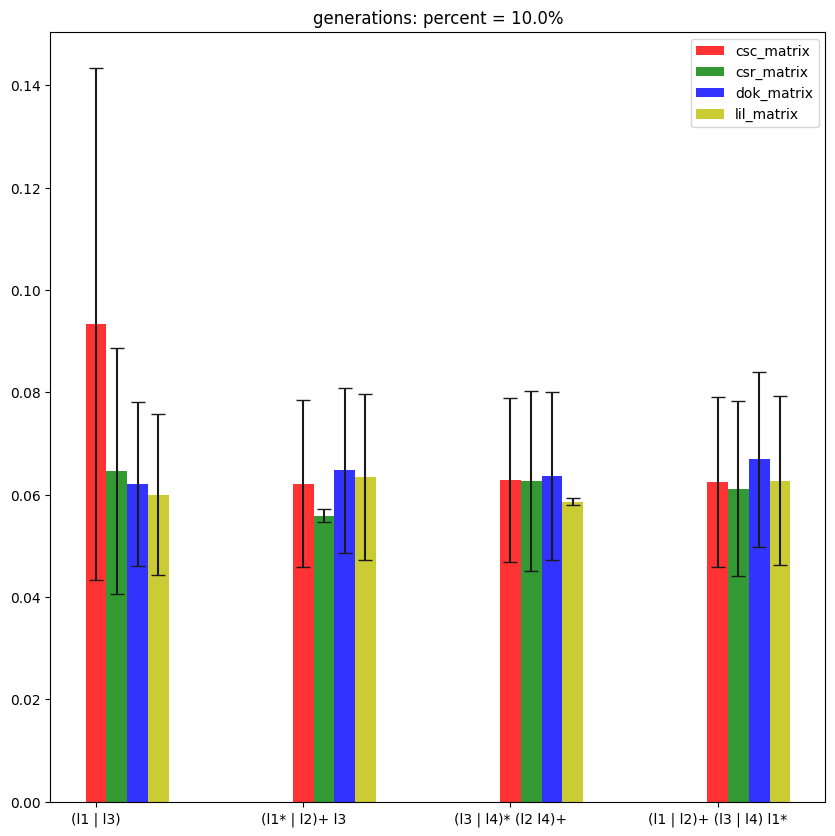

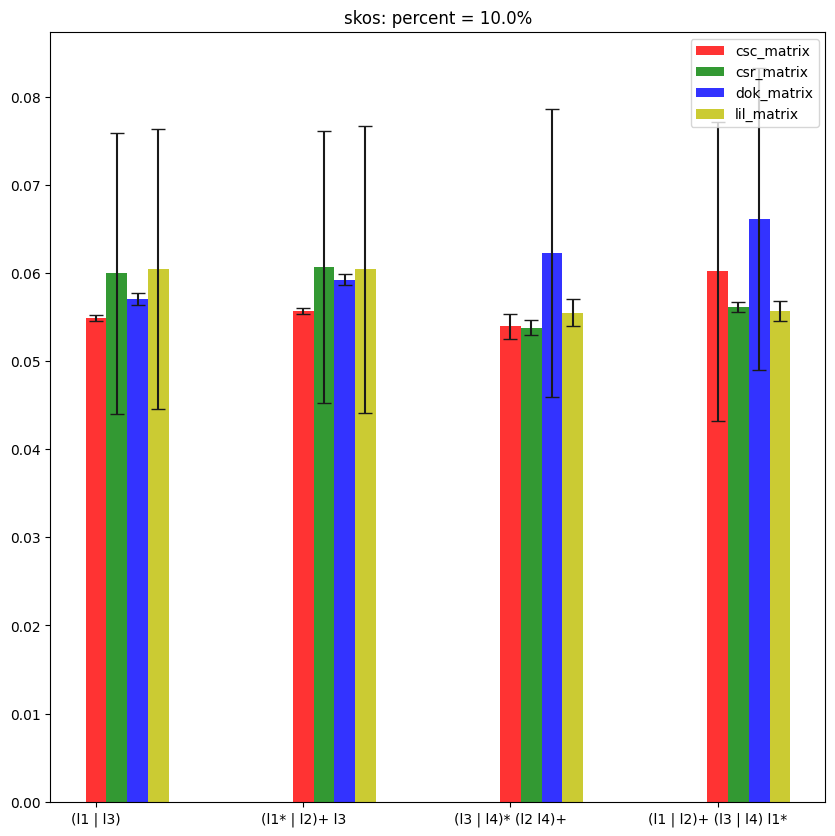

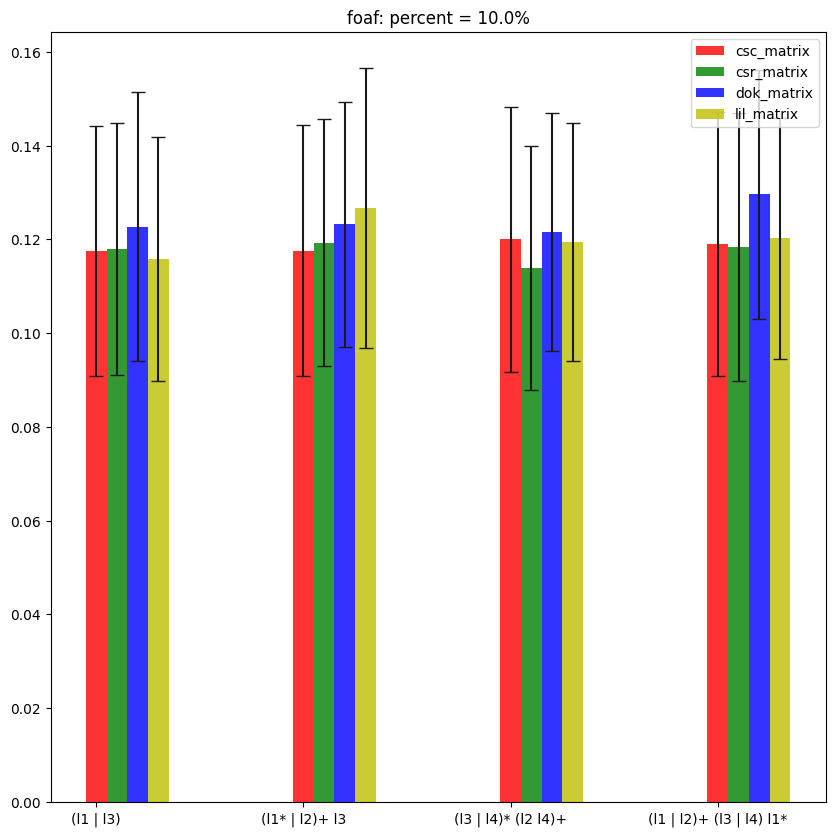

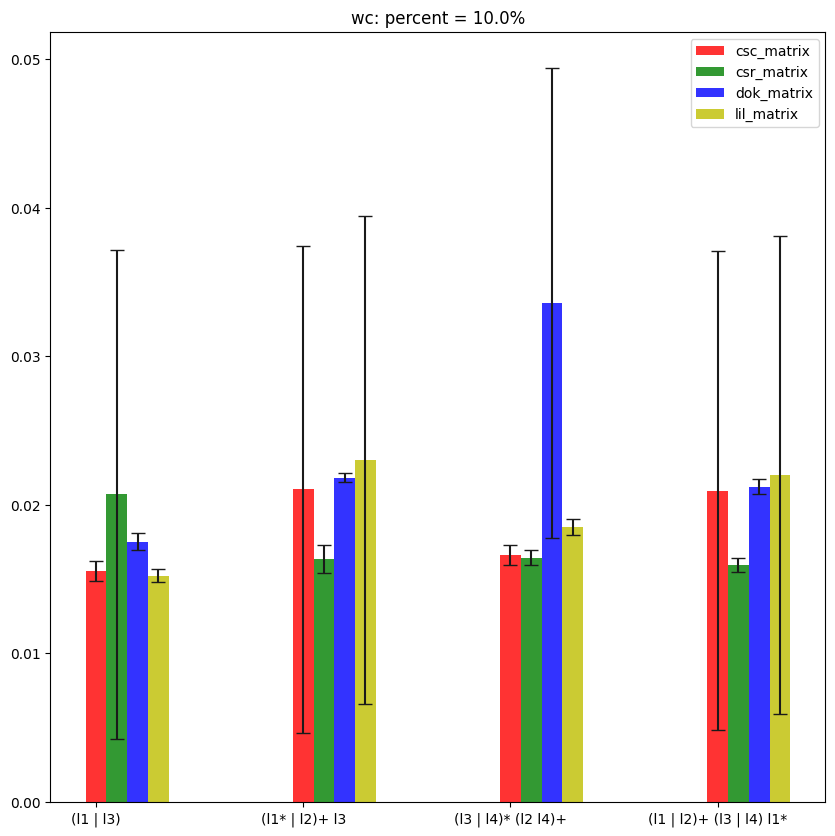

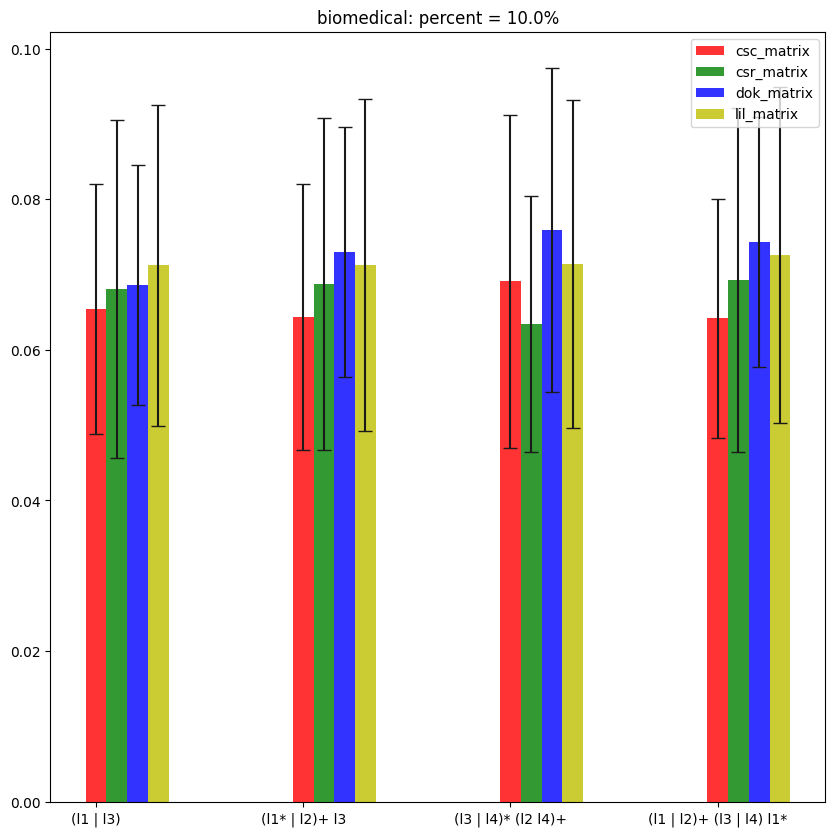

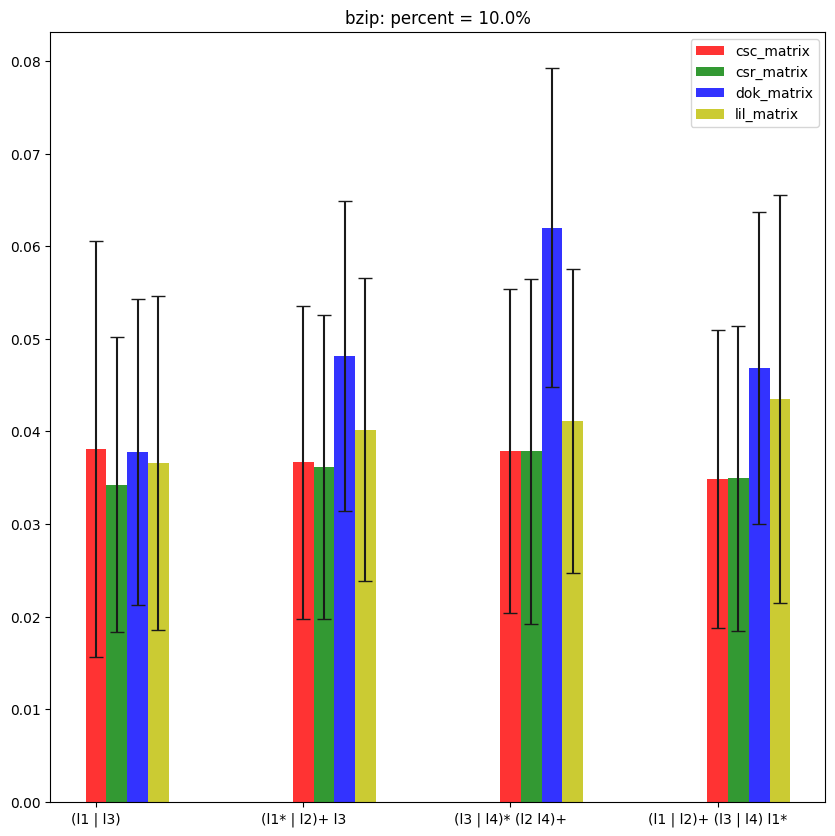

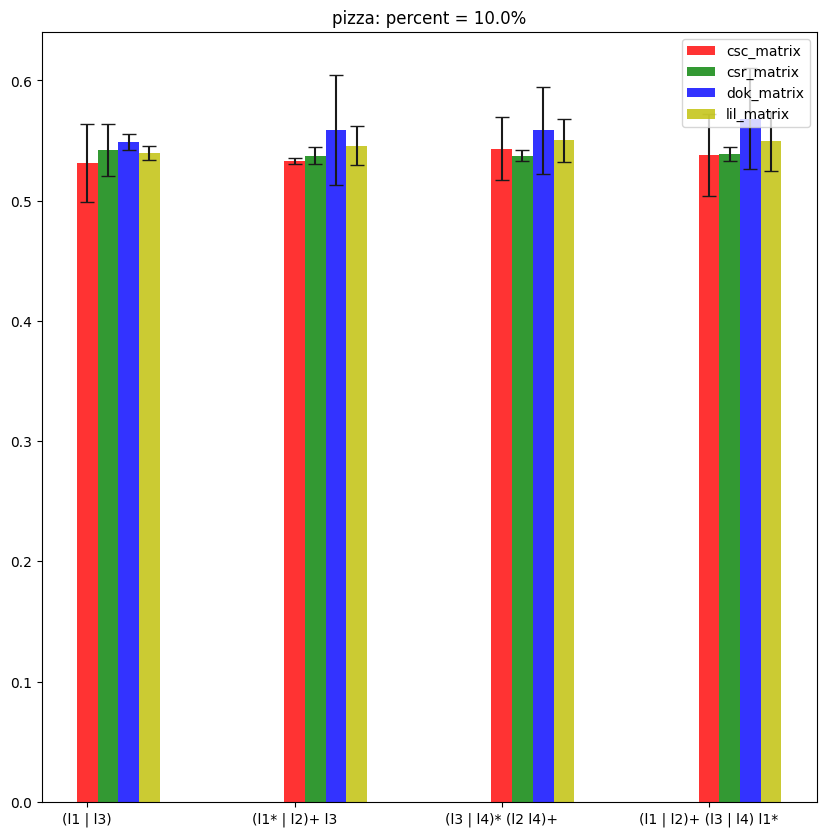

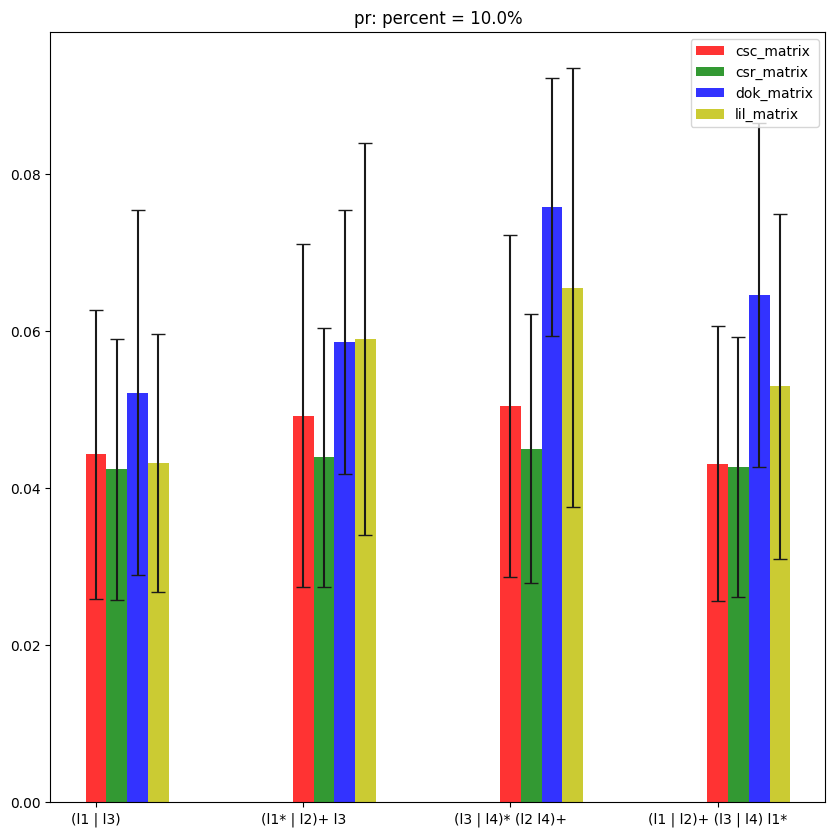

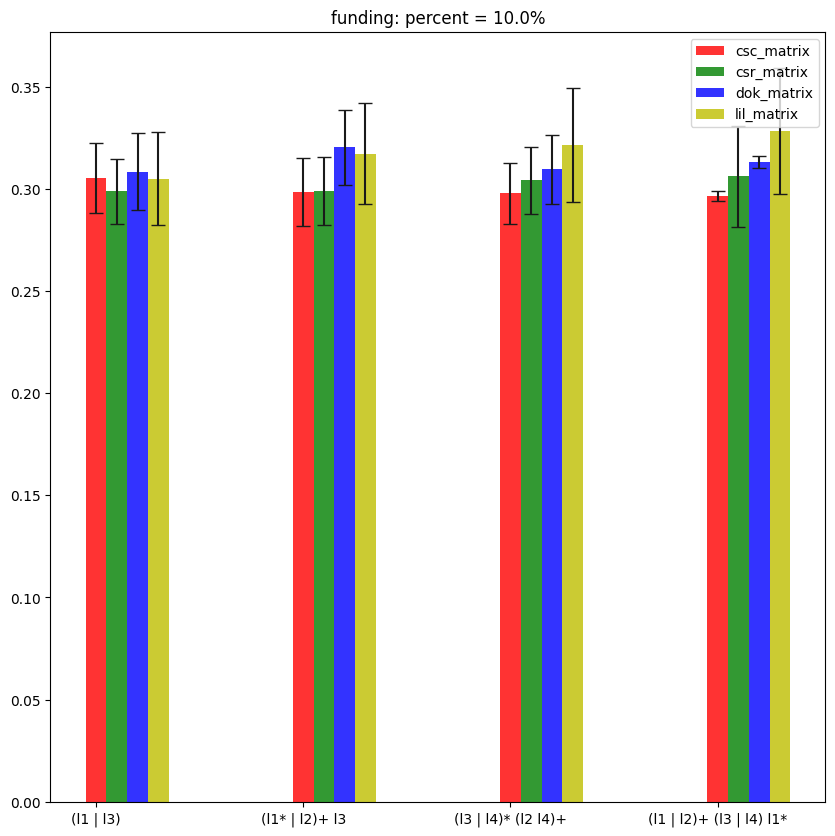

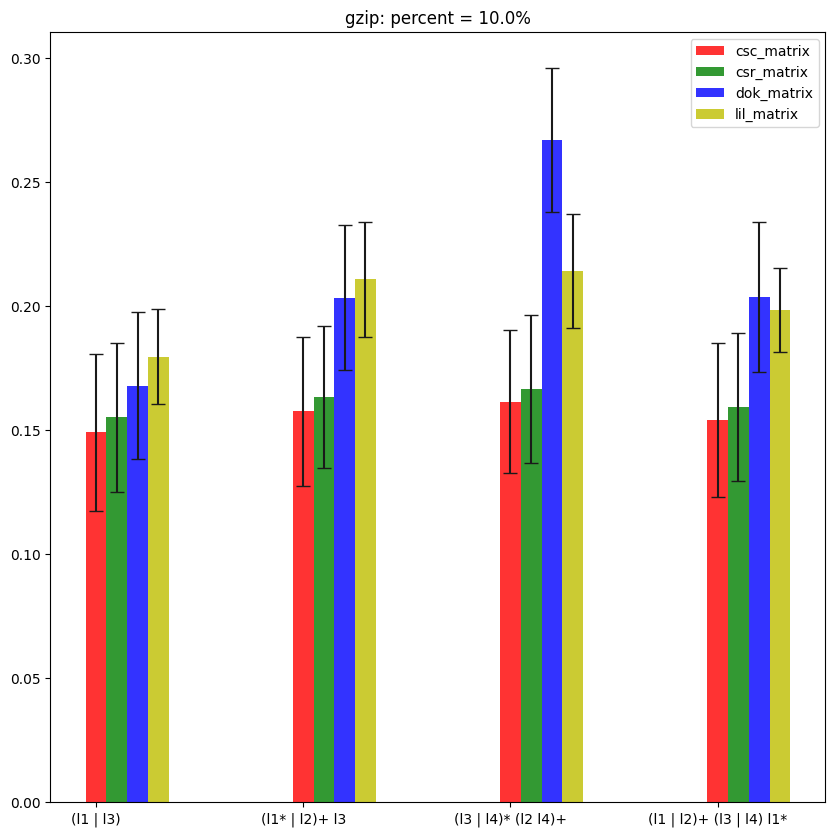

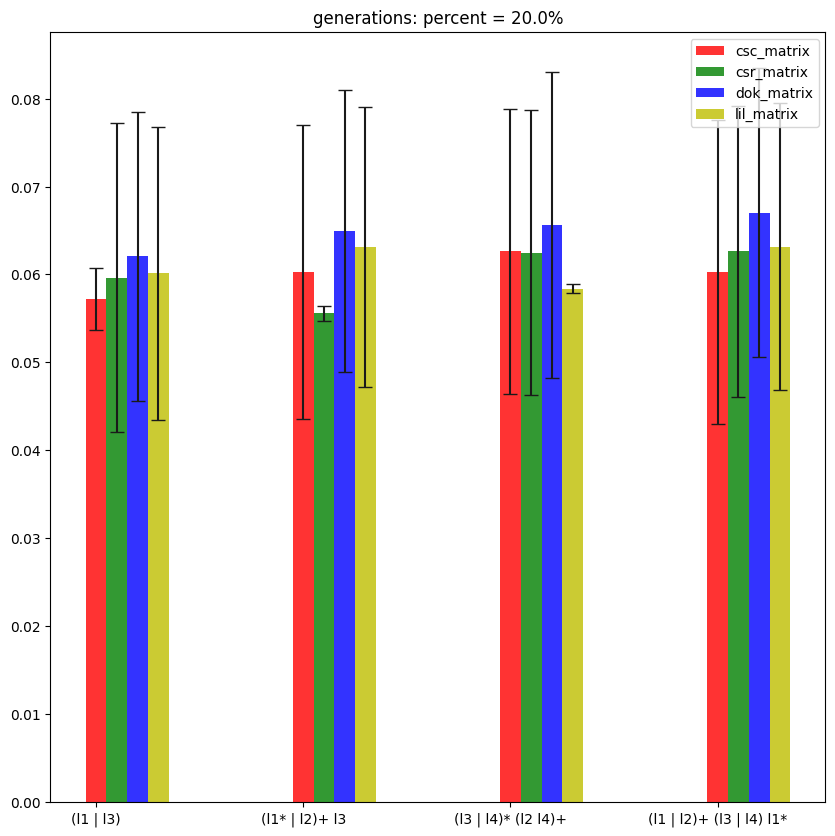

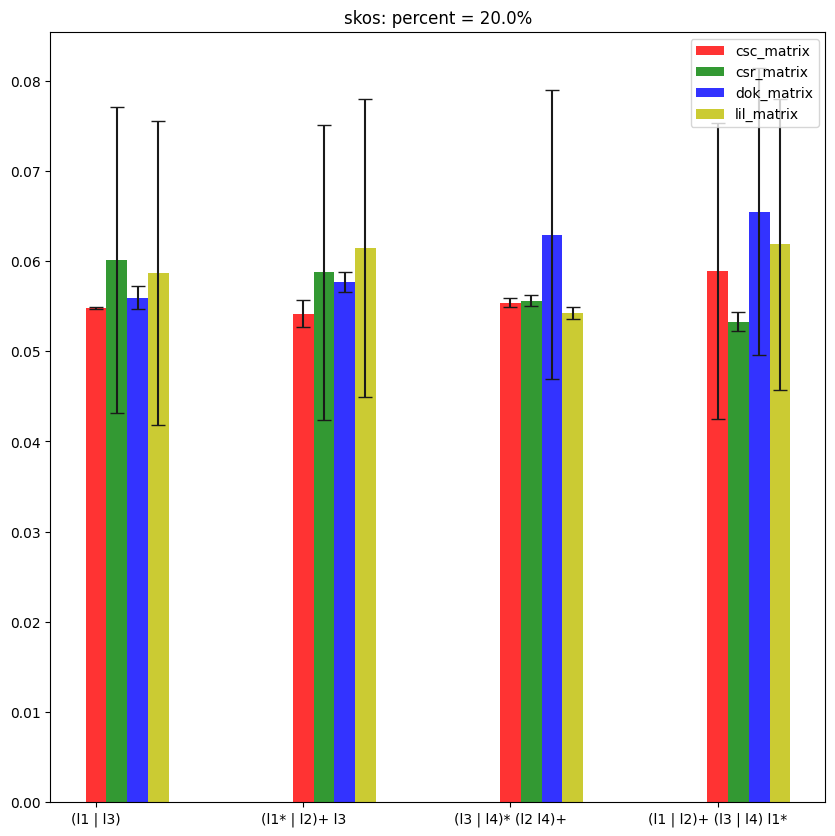

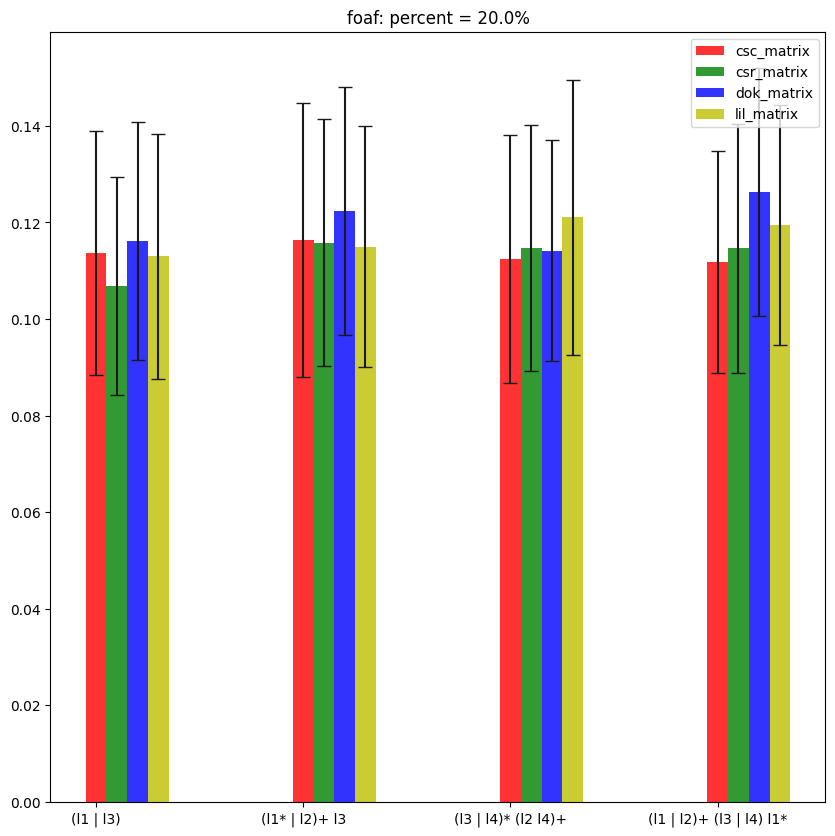

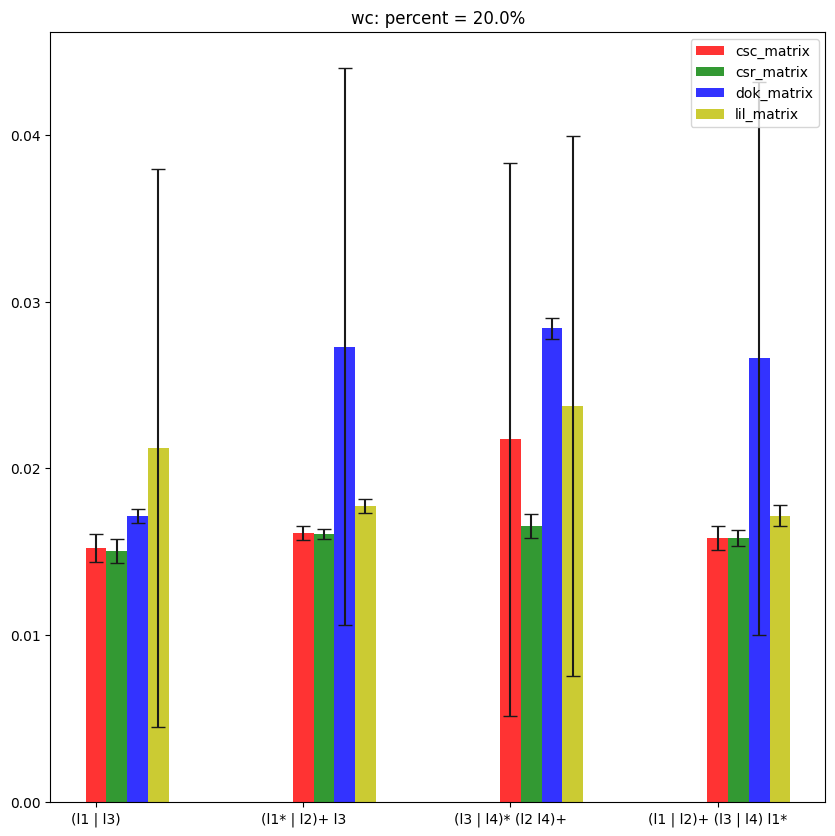

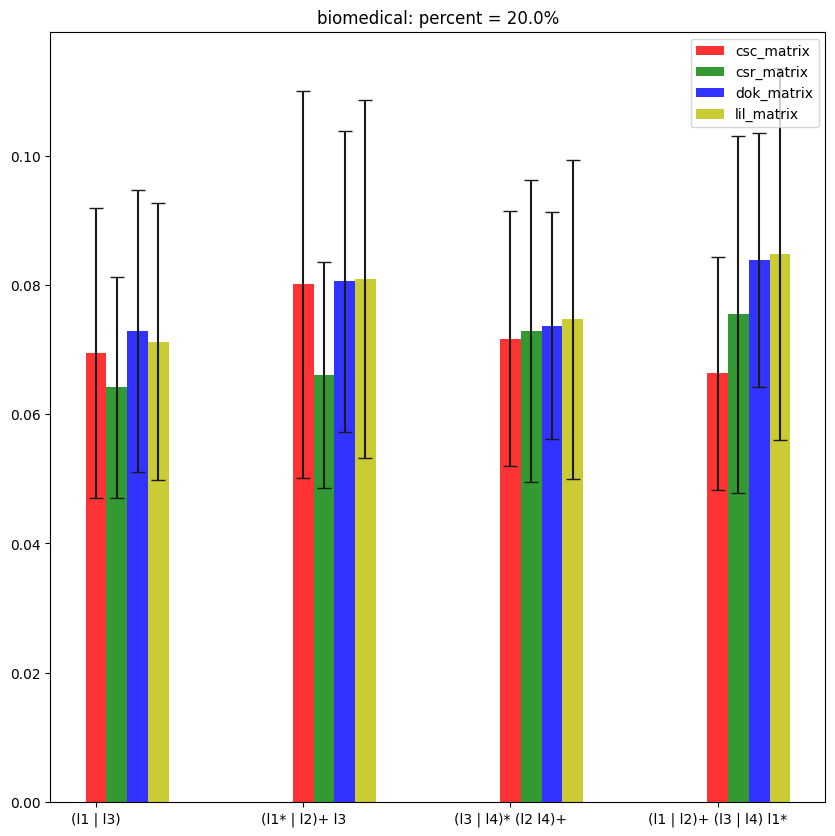

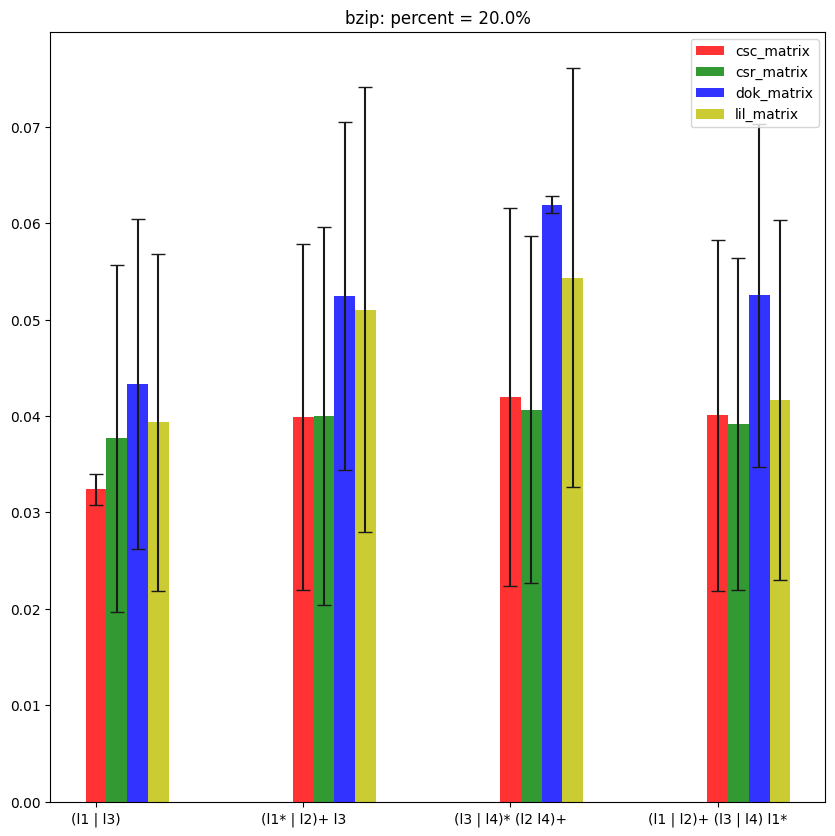

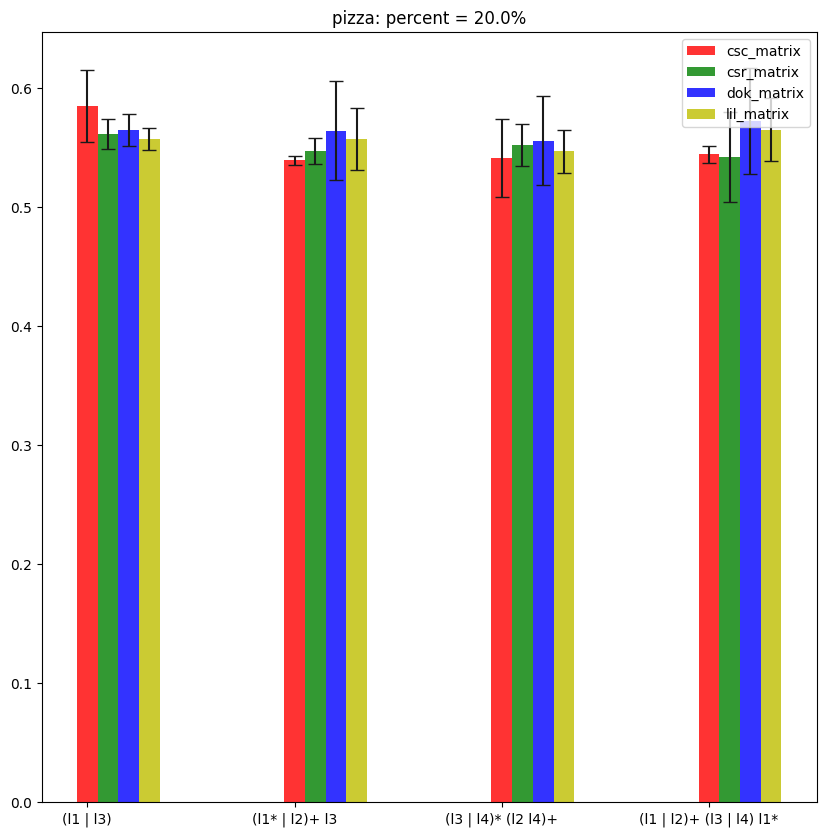

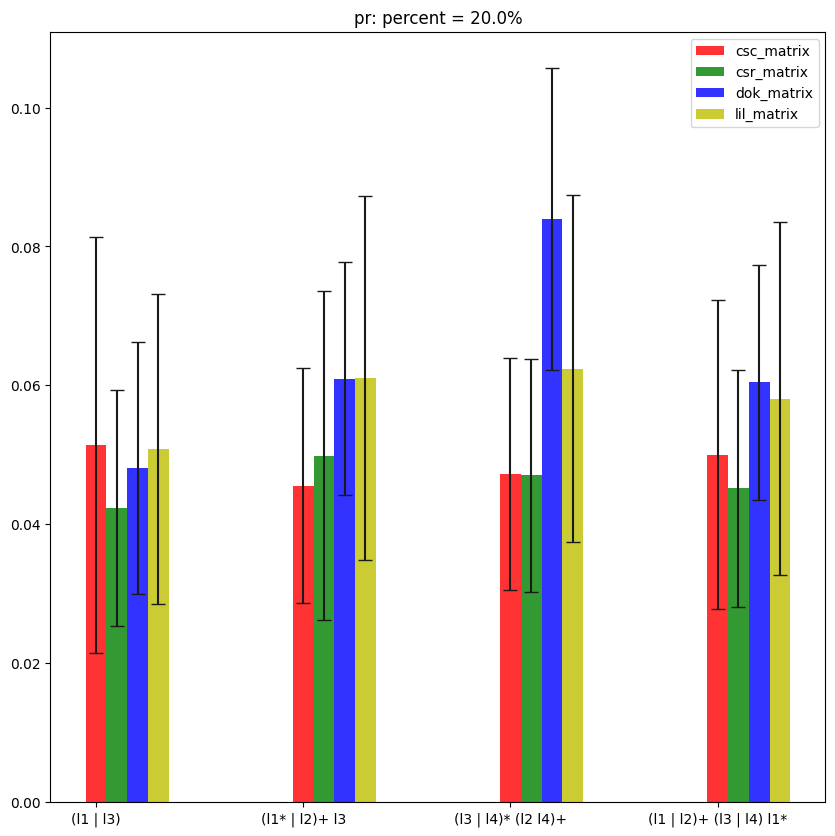

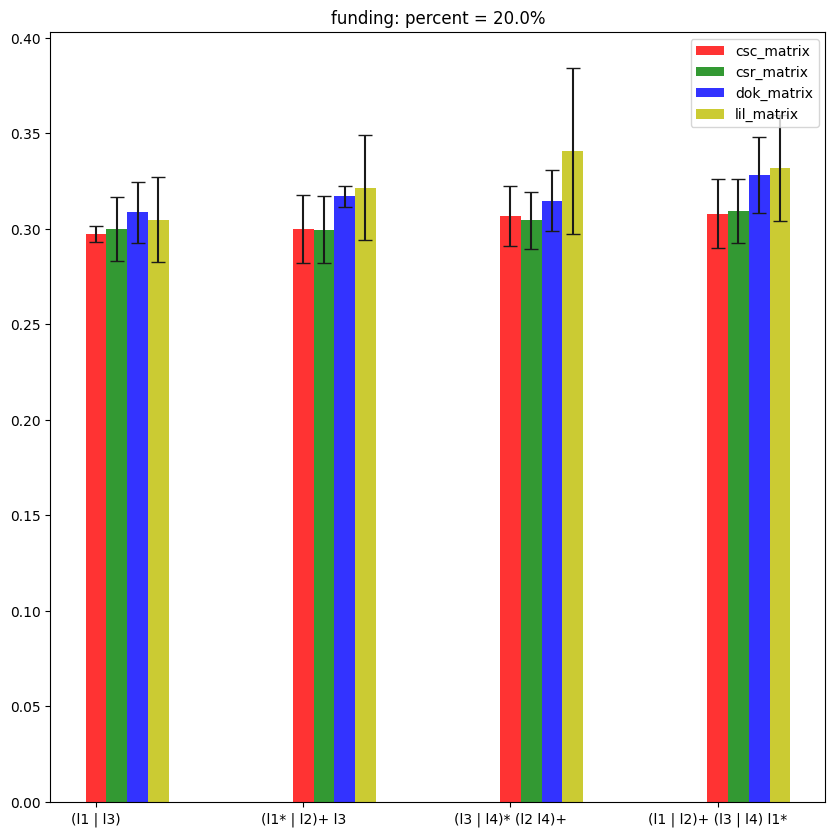

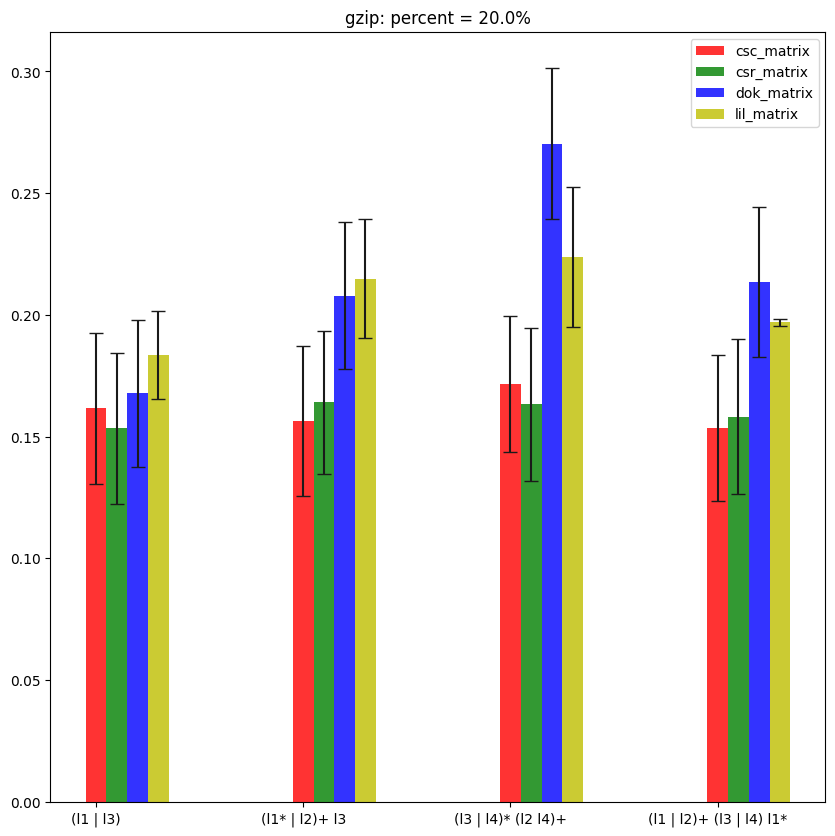

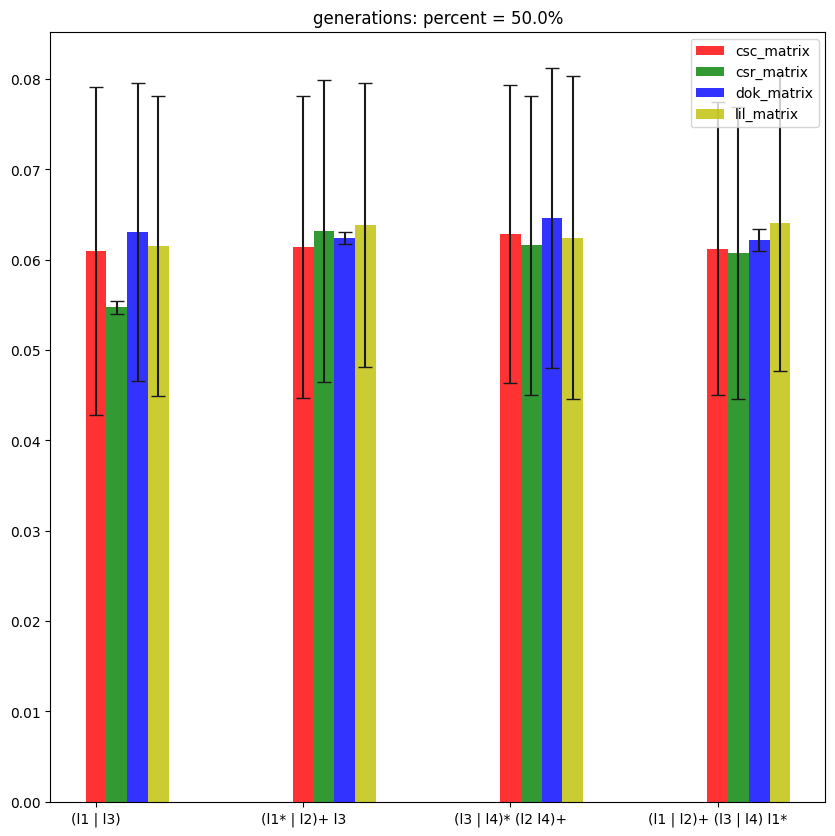

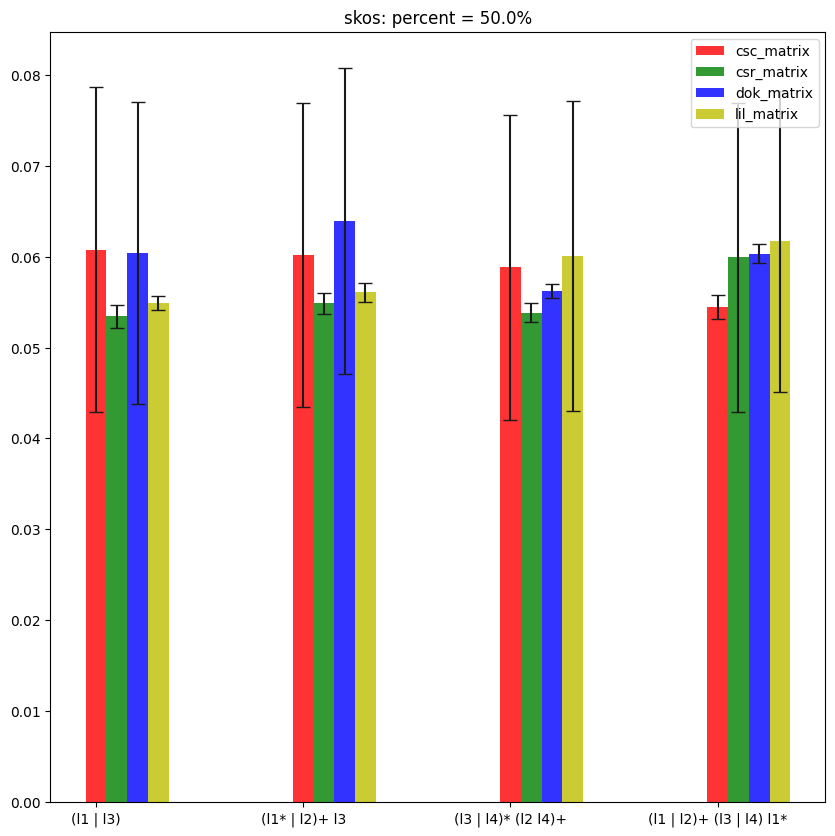

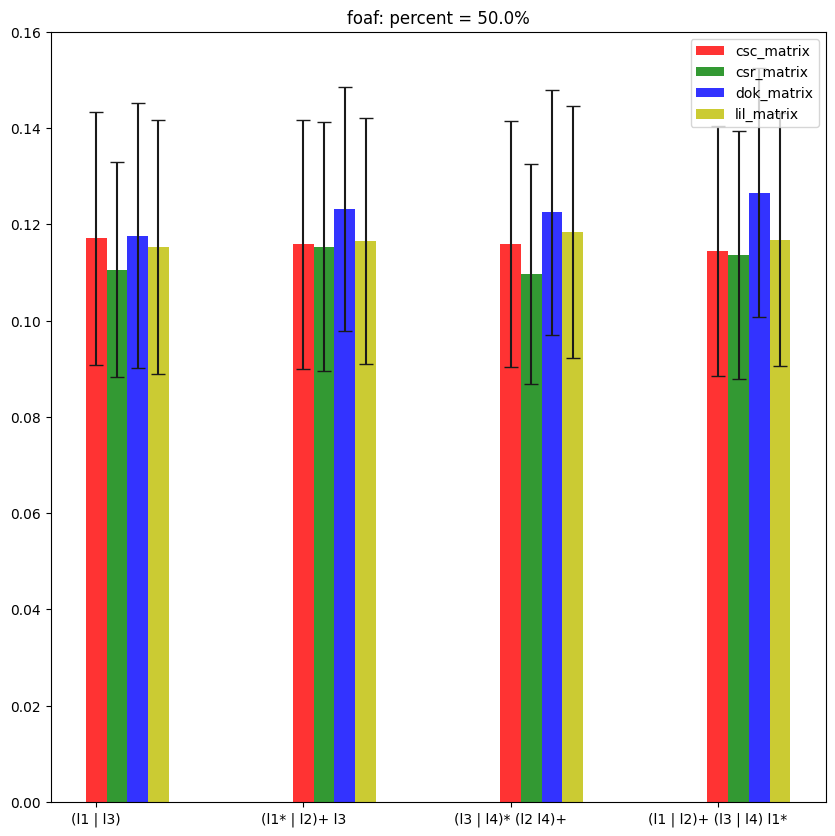

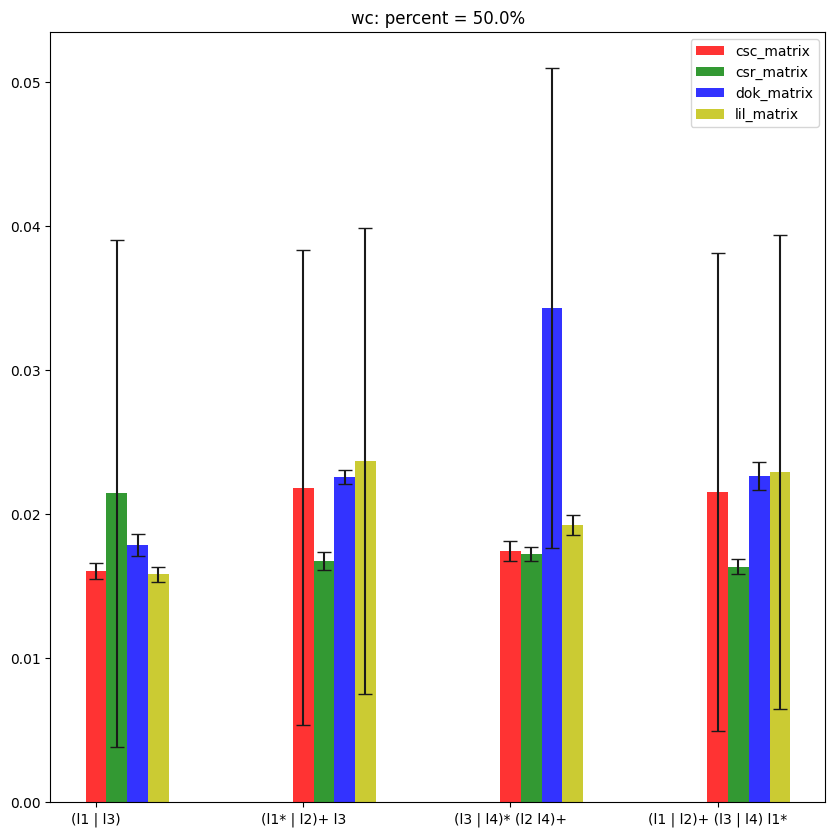

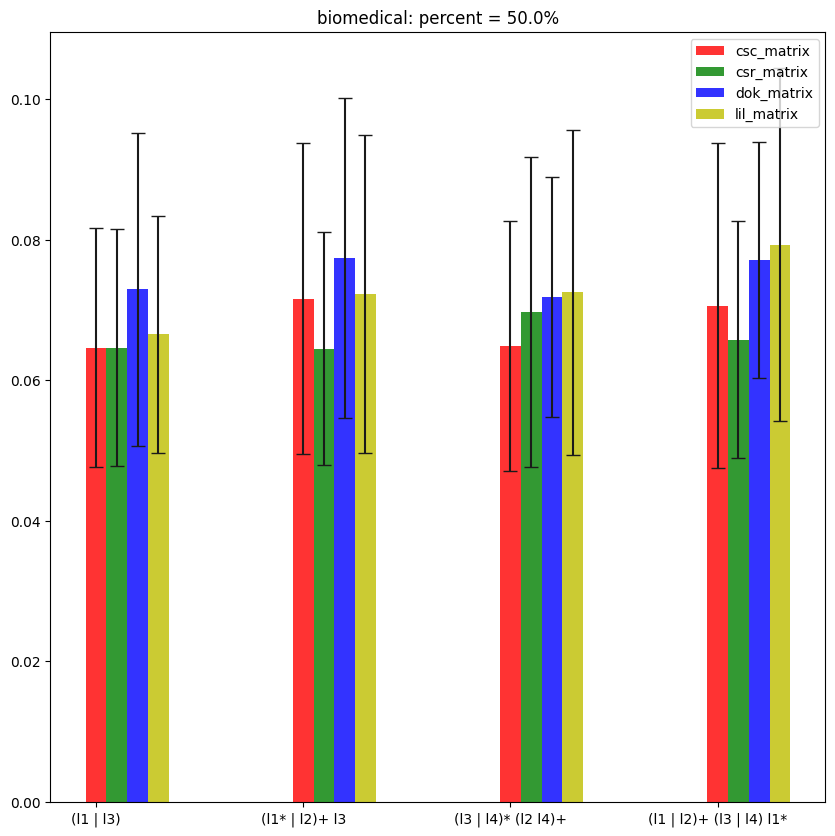

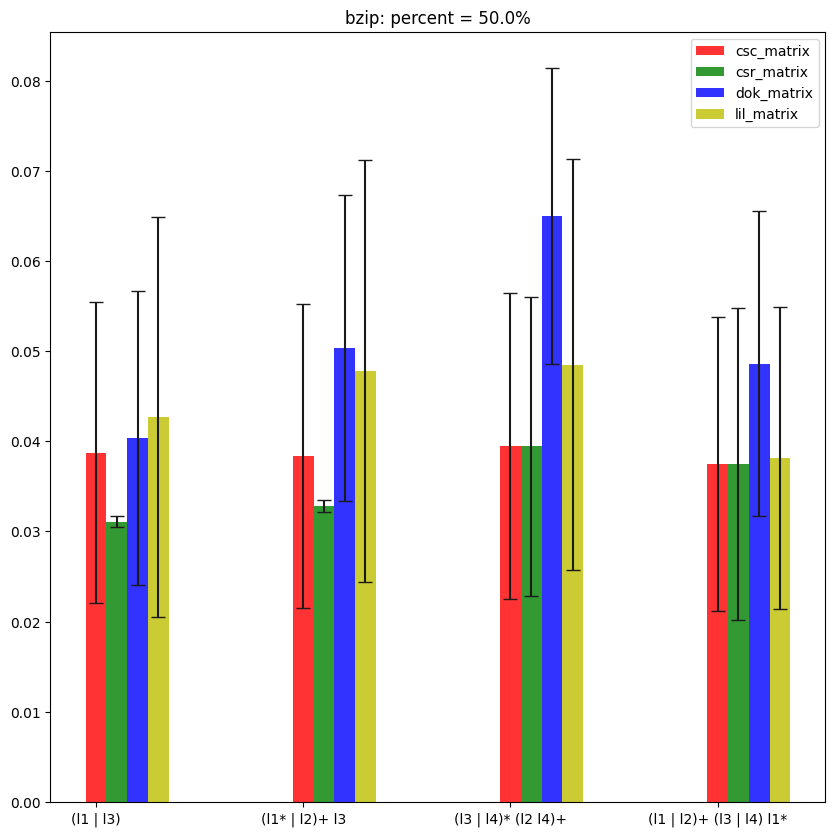

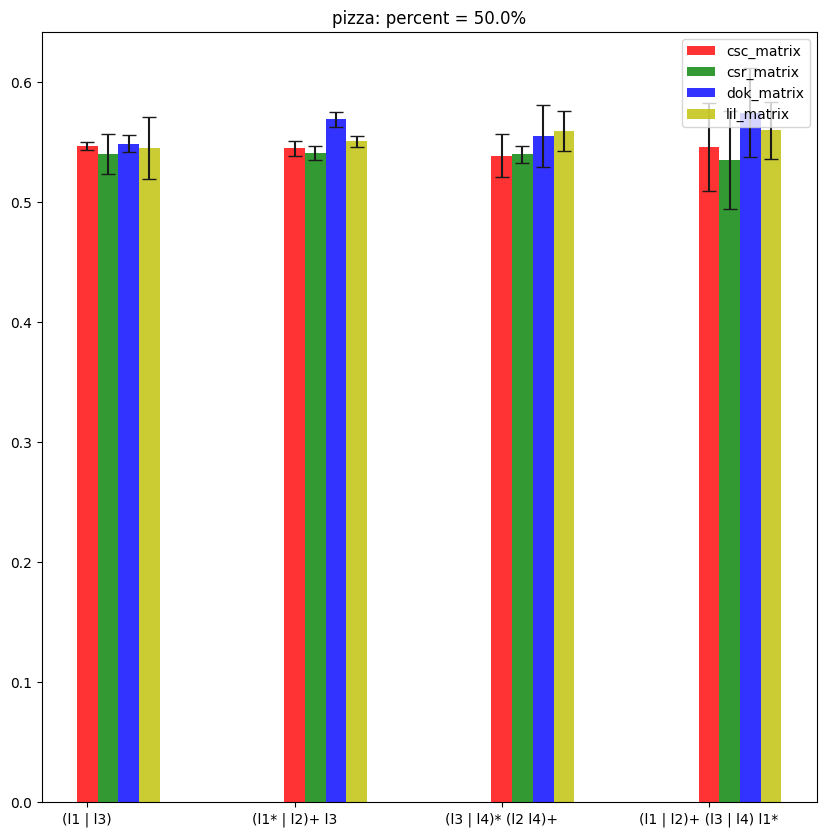

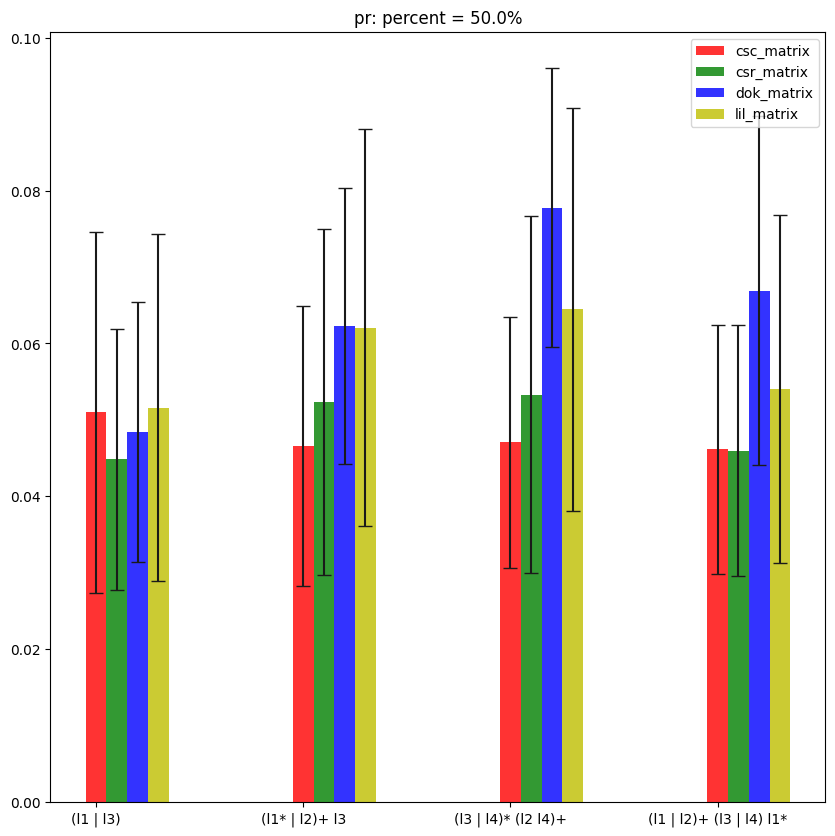

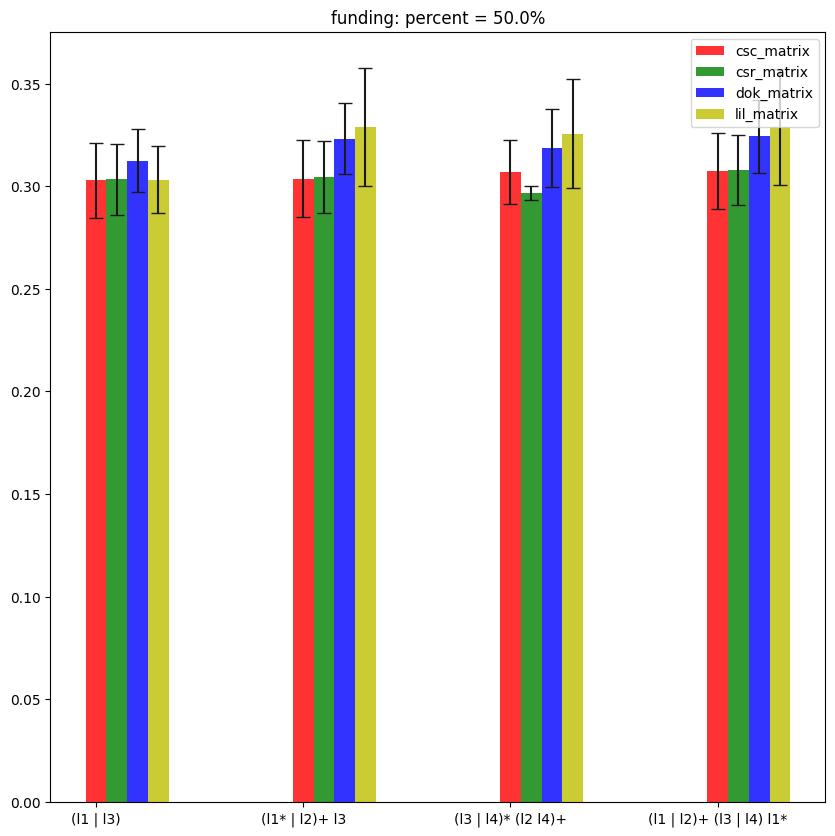

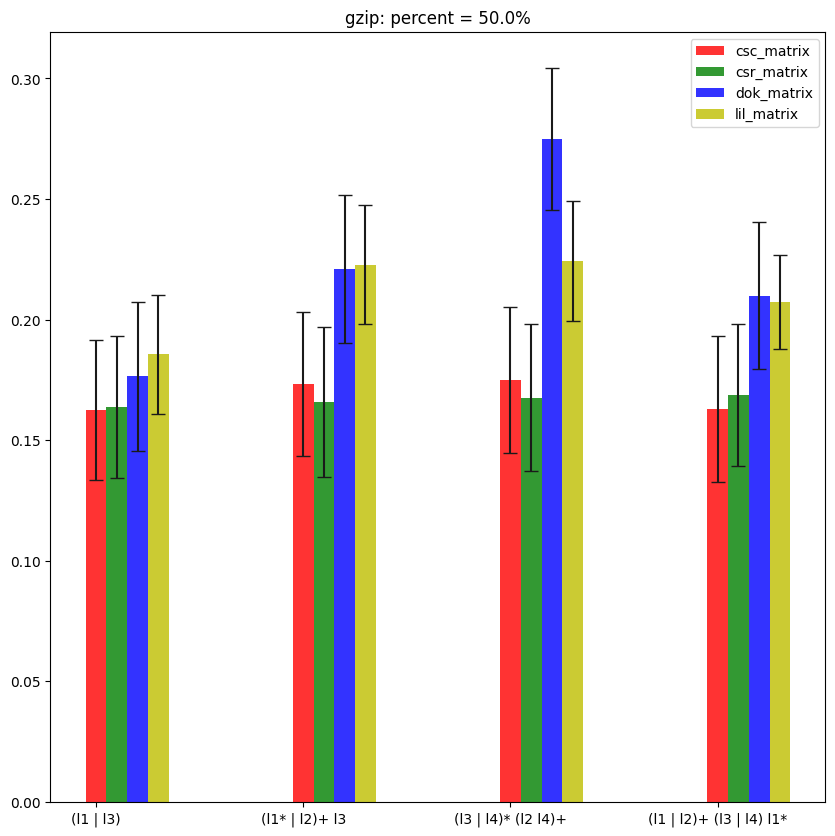

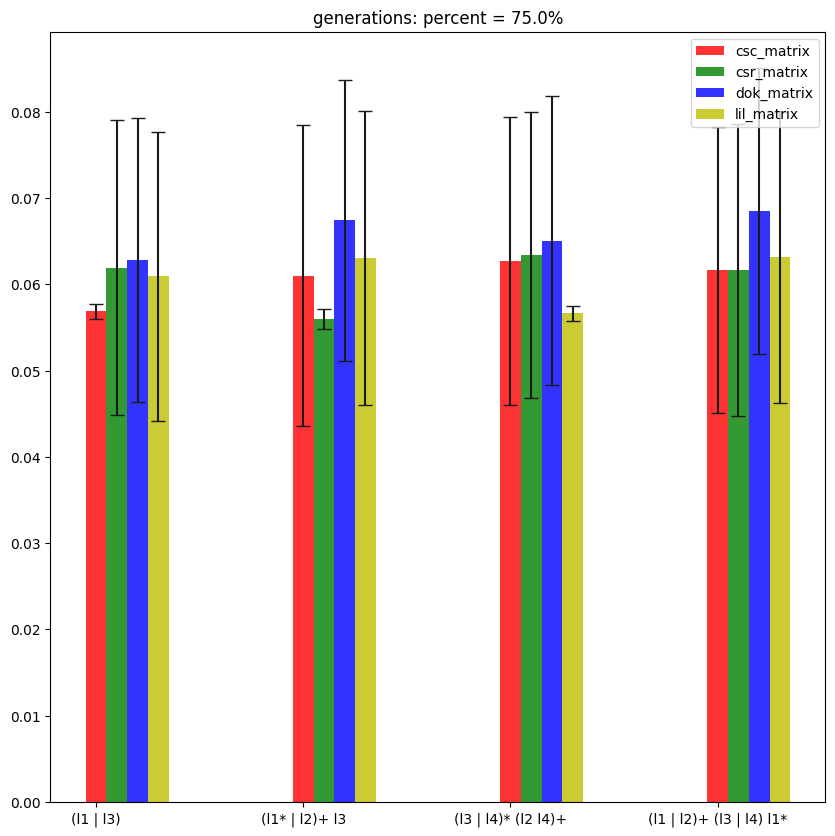

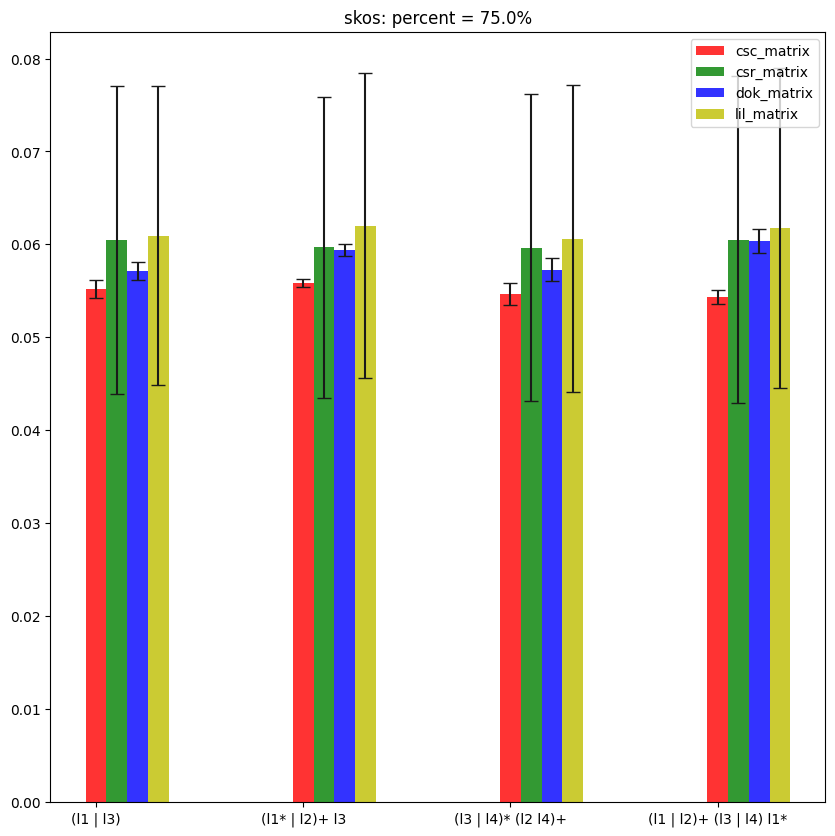

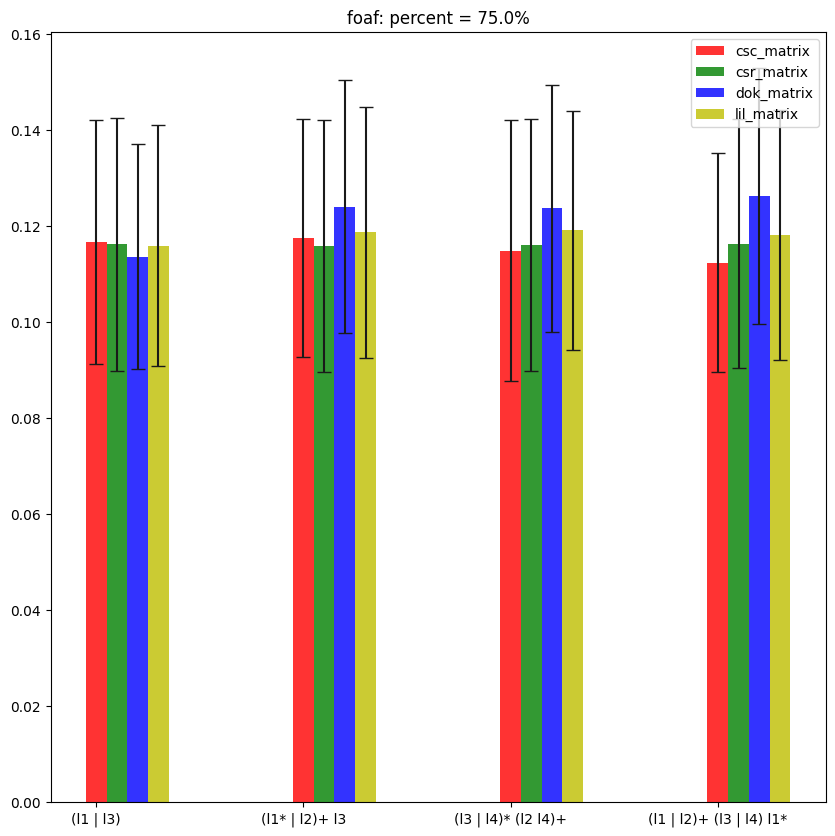

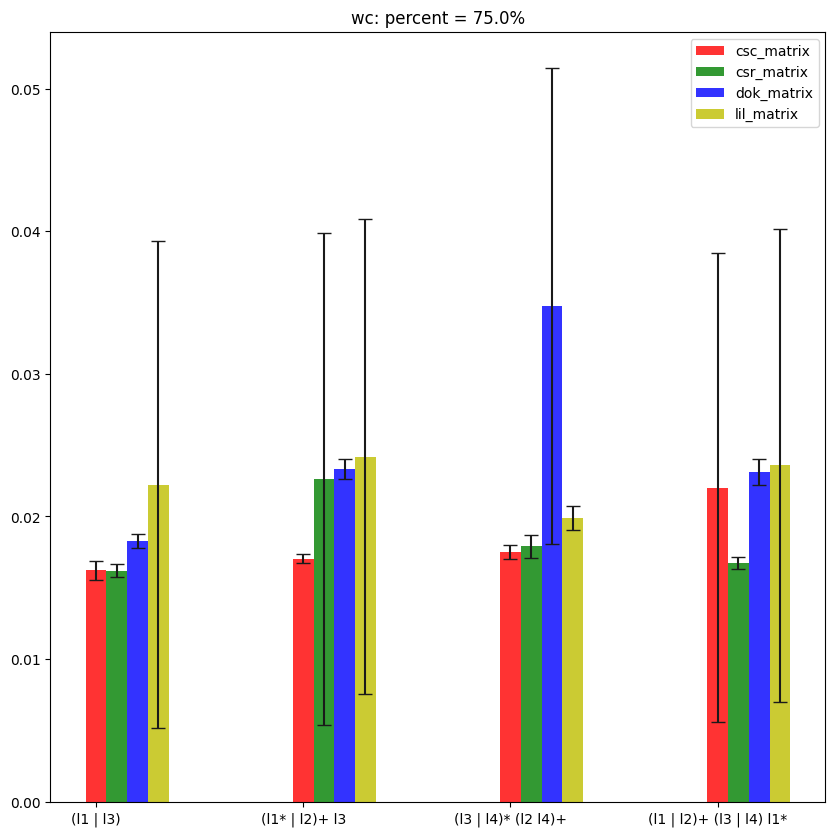

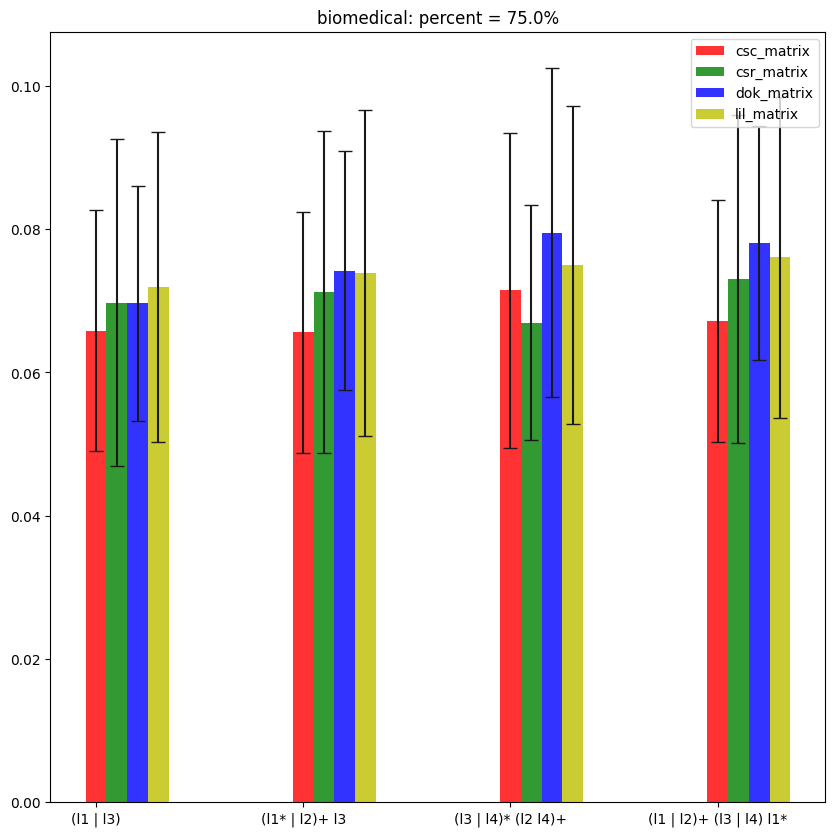

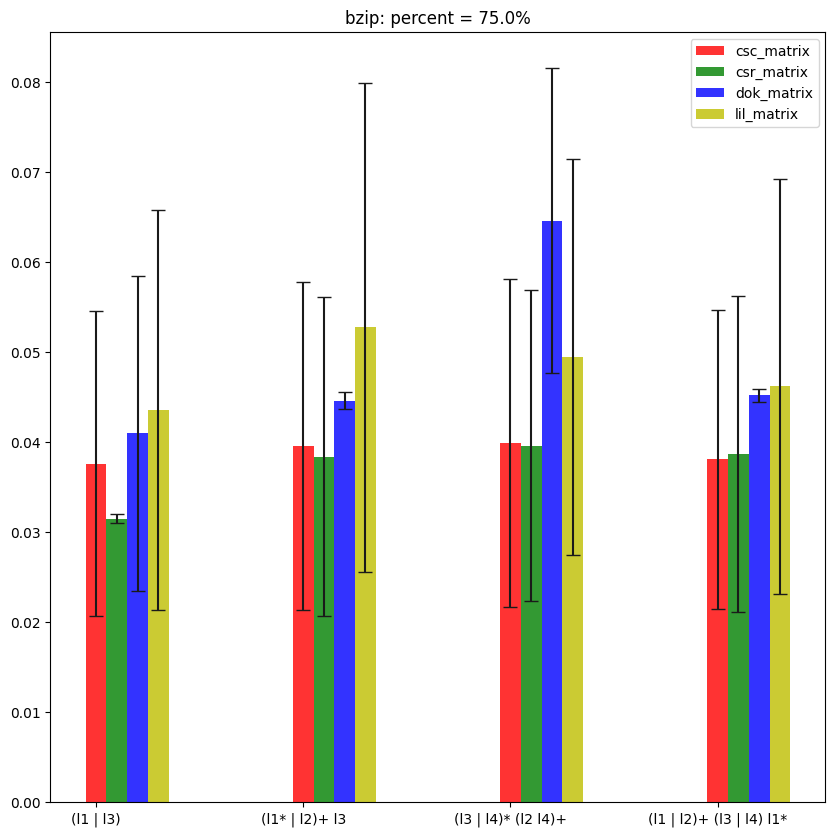

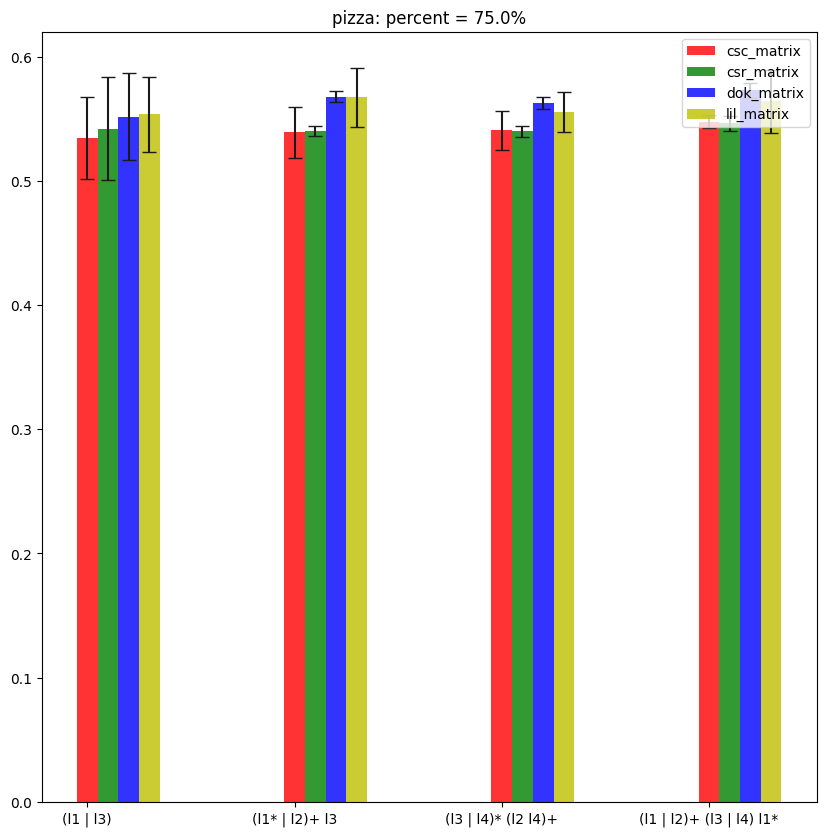

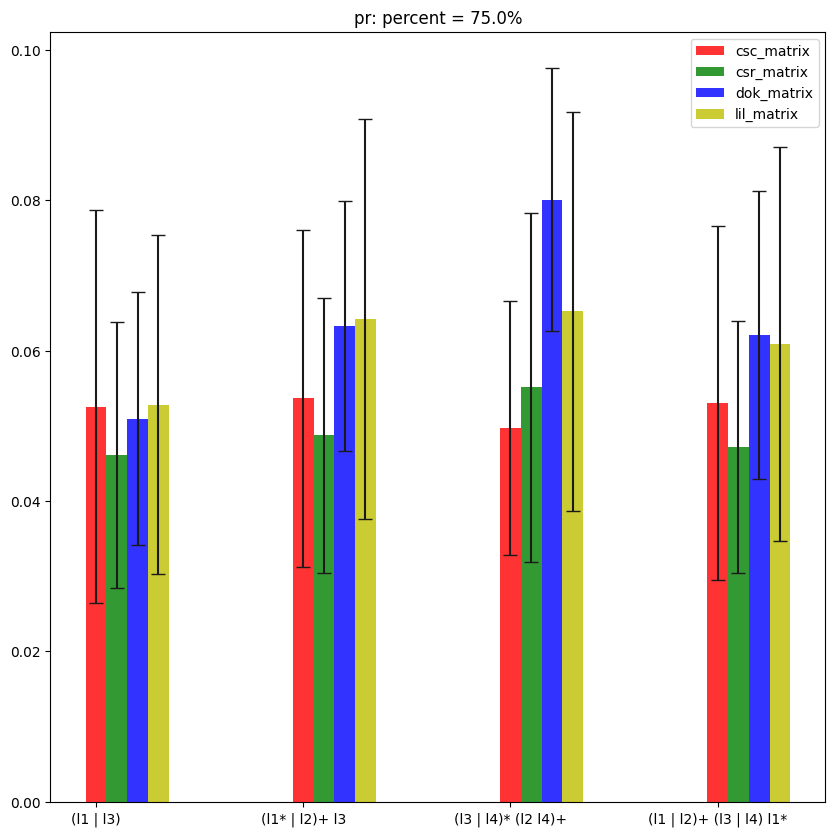

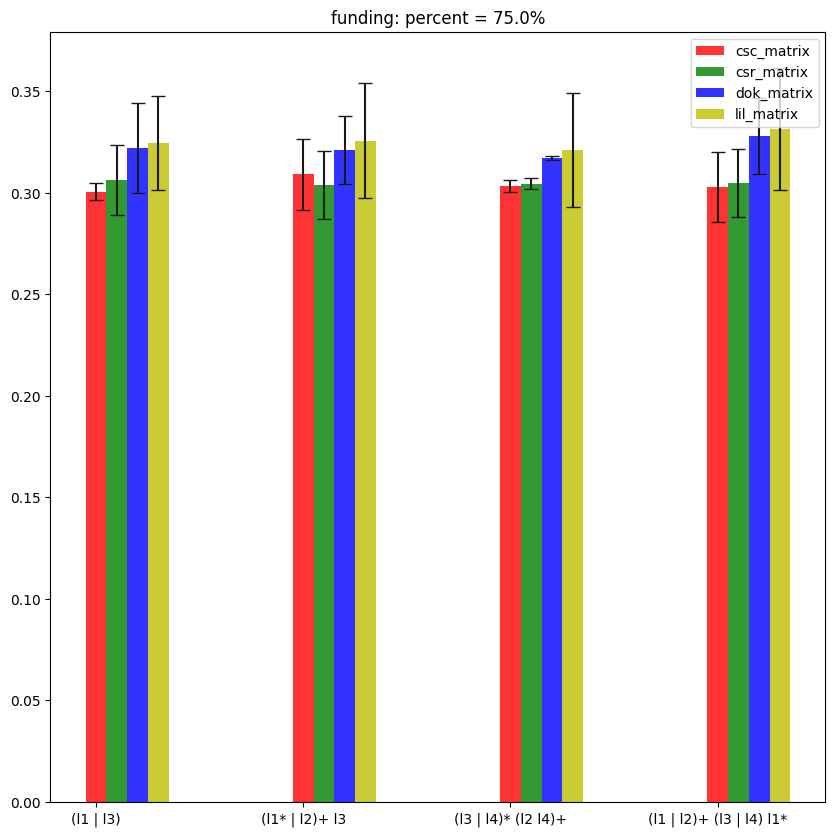

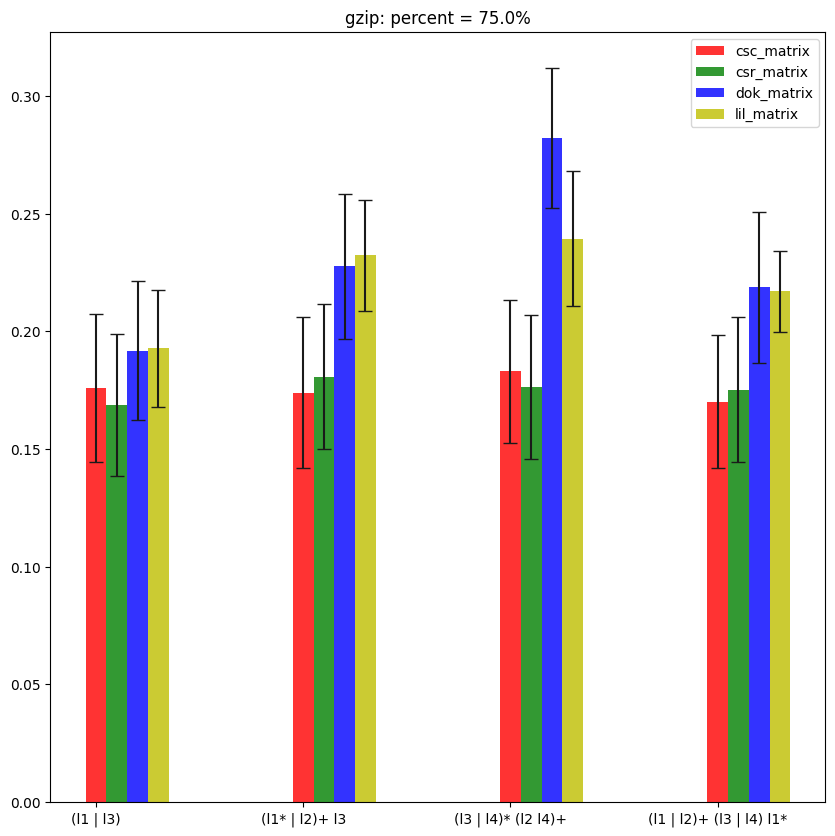

name percent  lil_matrix_time  lil_matrix_tstd  \
0           all_pair_tensor     100         0.156080         0.020080   
0              all_pair_bfs     100         0.169762         0.024241   
0  grouped_start_set_tensor    10.0         0.149138         0.018213   
0  grouped_start_set_tensor    20.0         0.152614         0.019816   
0  grouped_start_set_tensor    50.0         0.151832         0.019391   
0  grouped_start_set_tensor    75.0         0.155173         0.021394   

   dok_matrix_time  dok_matrix_tstd  csr_matrix_time  csr_matrix_tstd  \
0         0.162223         0.020487         0.145940         0.017727   
0         0.176780         0.018813         0.295483         0.017593   
0         0.153946         0.018673         0.140217         0.016705   
0         0.155978         0.019003         0.141444         0.017250   
0         0.156163         0.017040         0.140490         0.015512   
0         0.157555         0.015015         0.143415         0.017208   

   csc_matrix_time  csc_matrix_tstd  
0         0.146700         0.018145  
0         0.305924         0.017422  
0         0.140410         0.018863  
0         0.142192         0.016911  
0         0.142694         0.018364  
0         0.142776         0.016112

In [29]:
for percent in percents:
    results = rpq_request_performance_check(percent=percent, rpq_type="tensor")
    final_statistic = update_statistic("grouped_start_set_tensor", percent, results, final_statistic)
final_statistic

### Алгоритм BFS

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


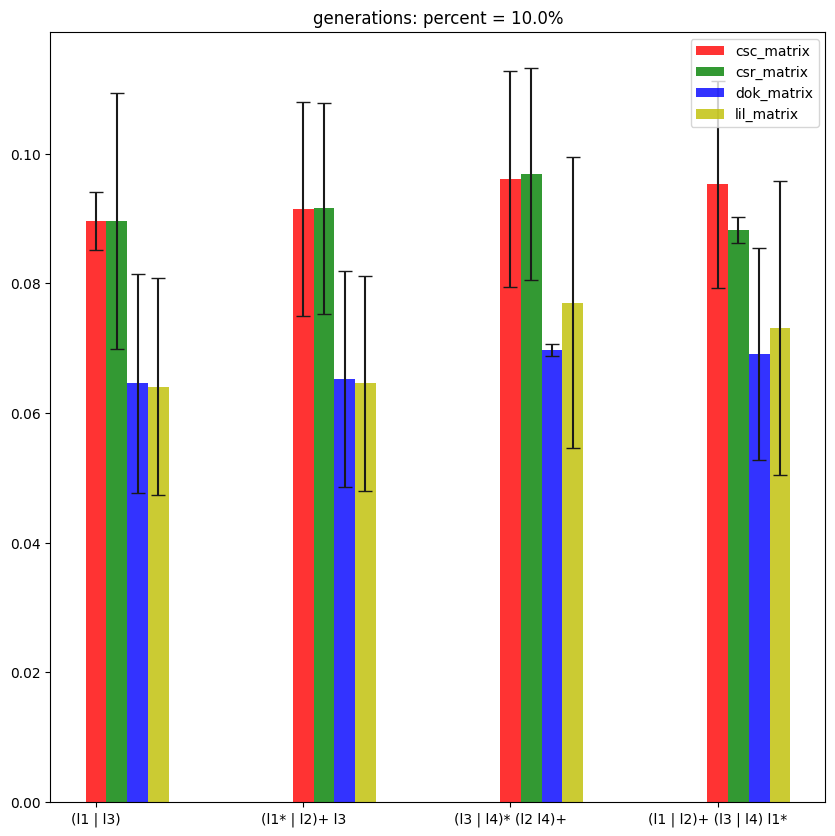

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


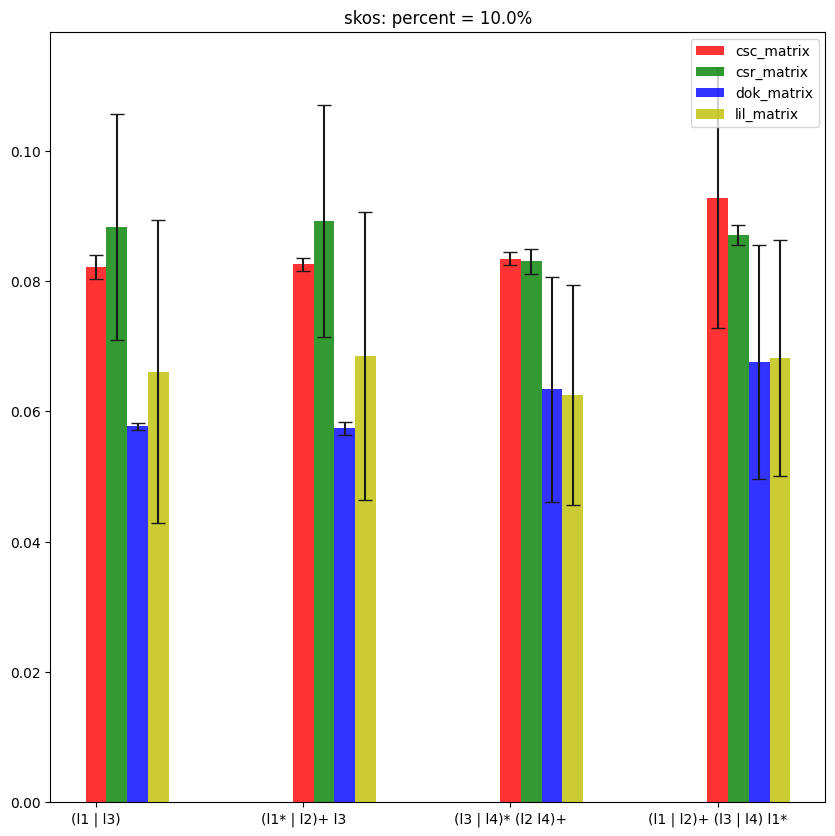

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


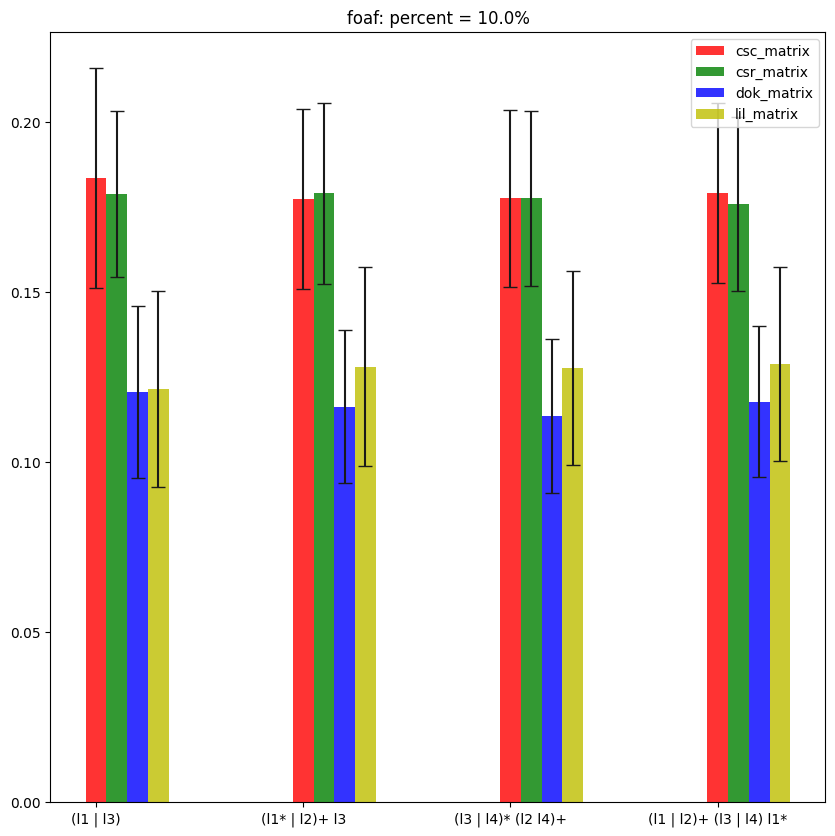

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


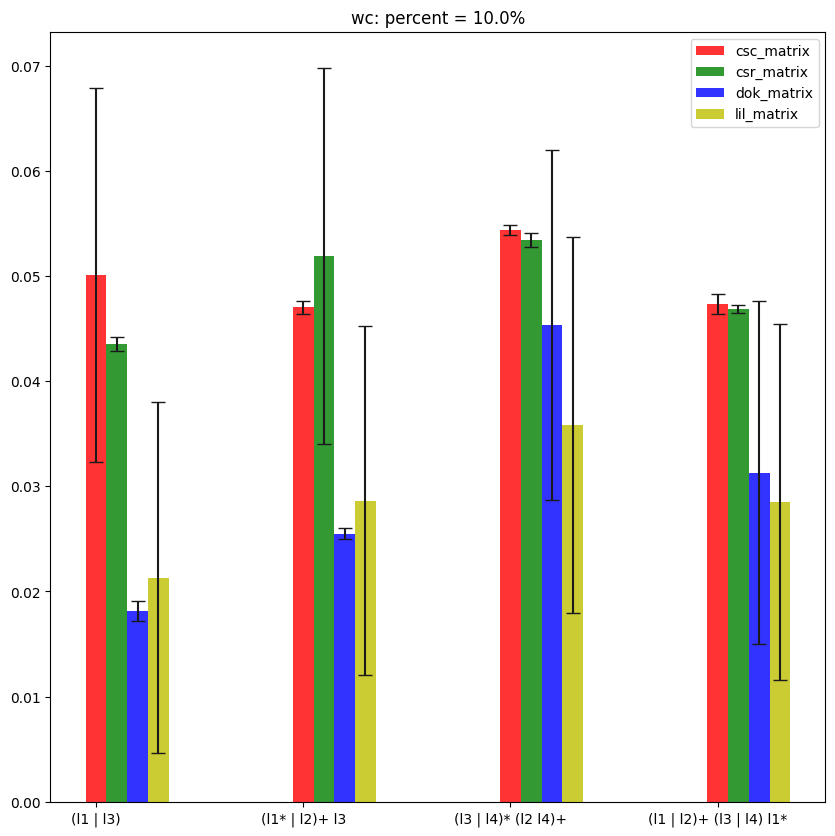

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


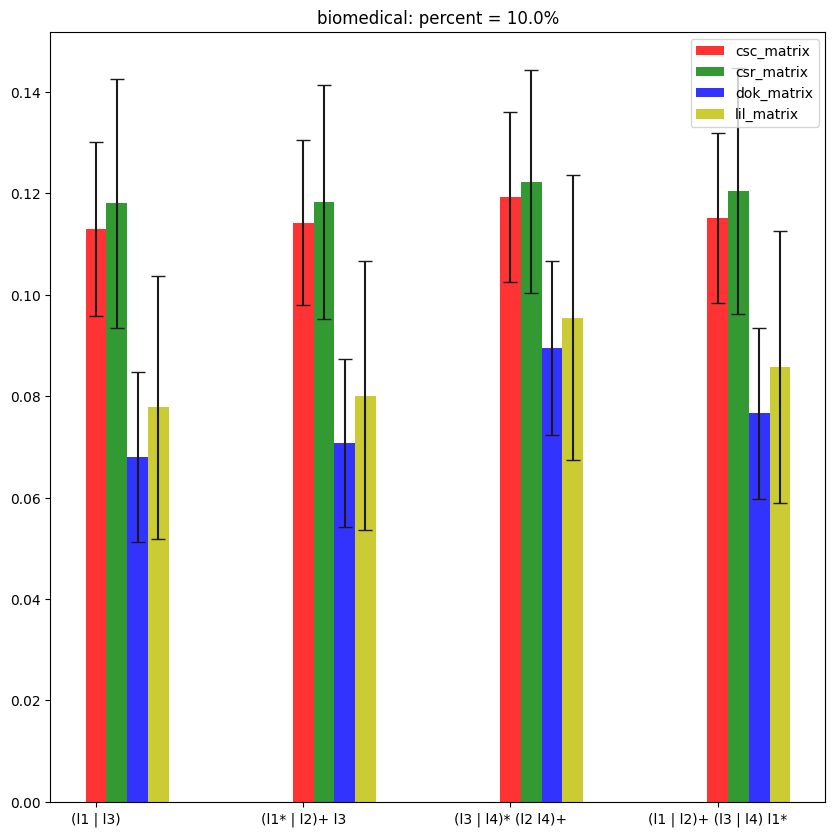

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


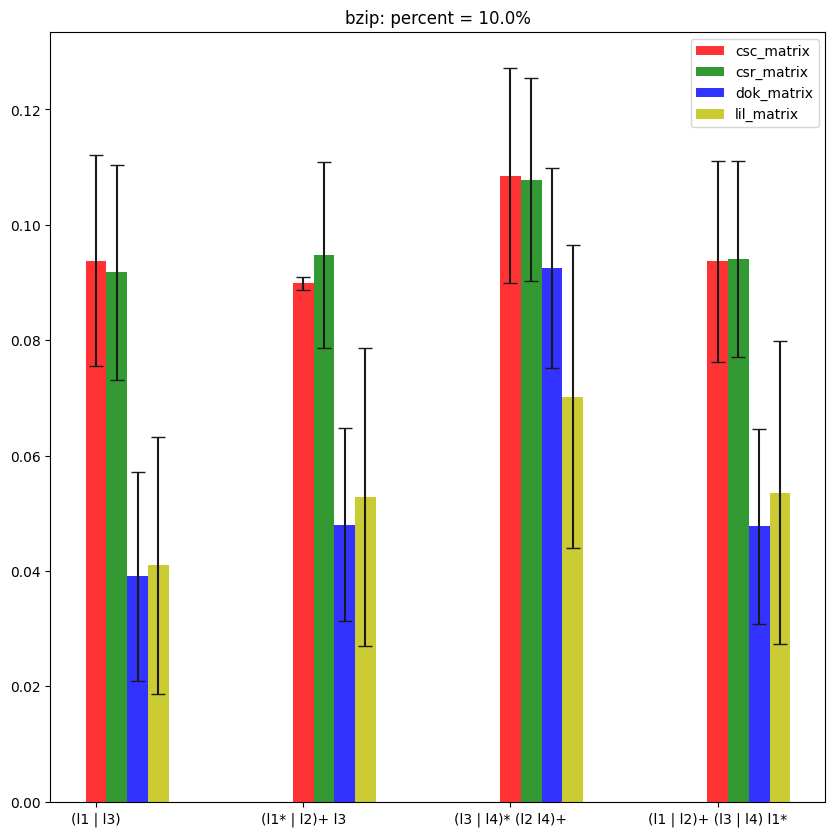

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


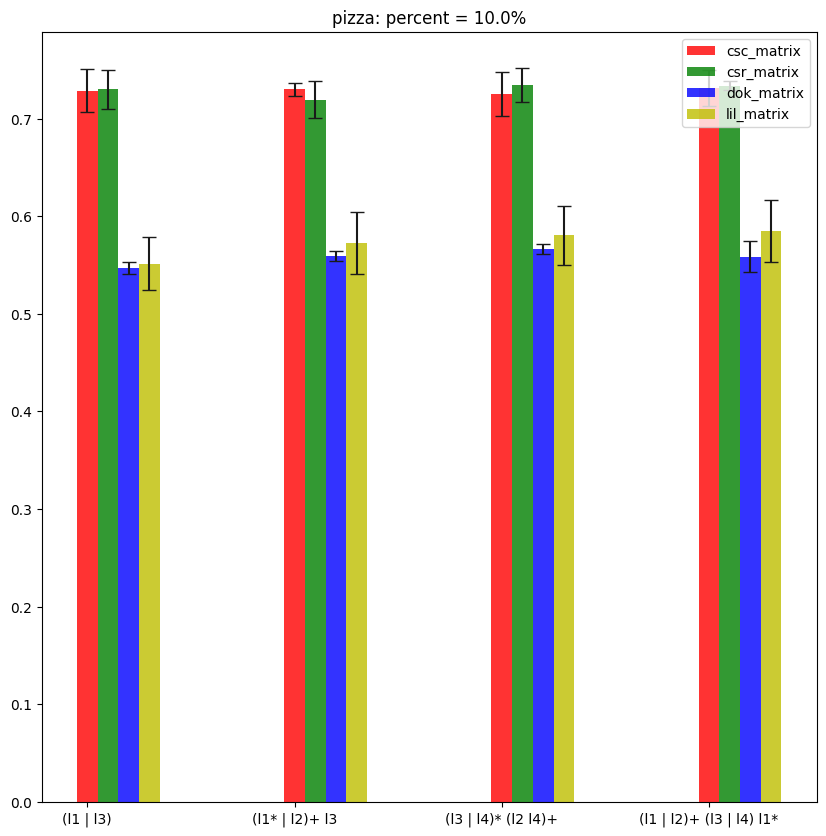

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


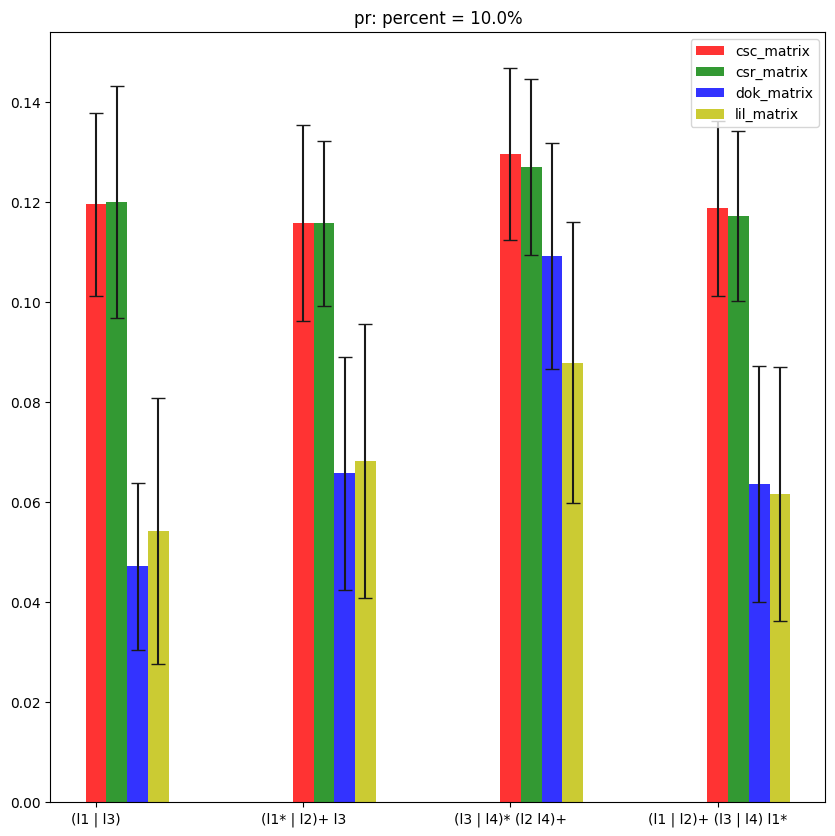

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


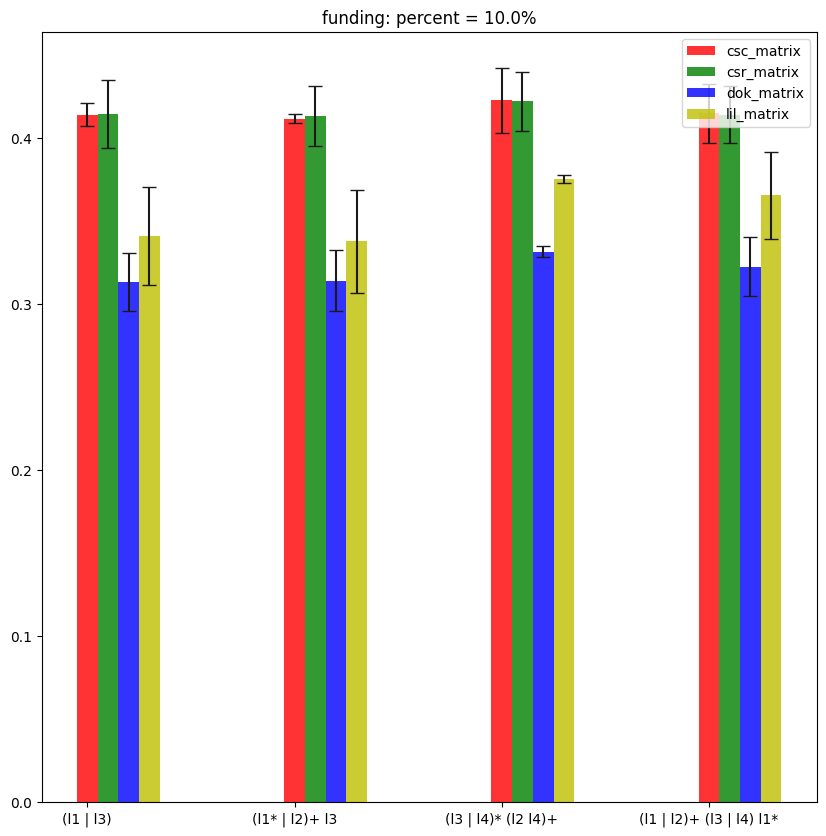

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


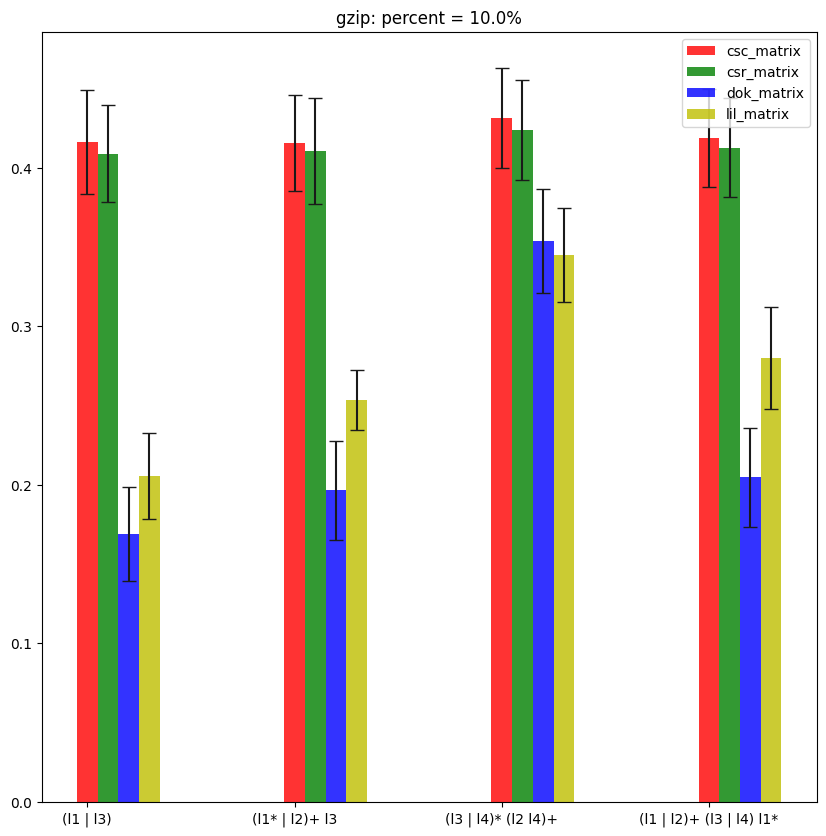

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


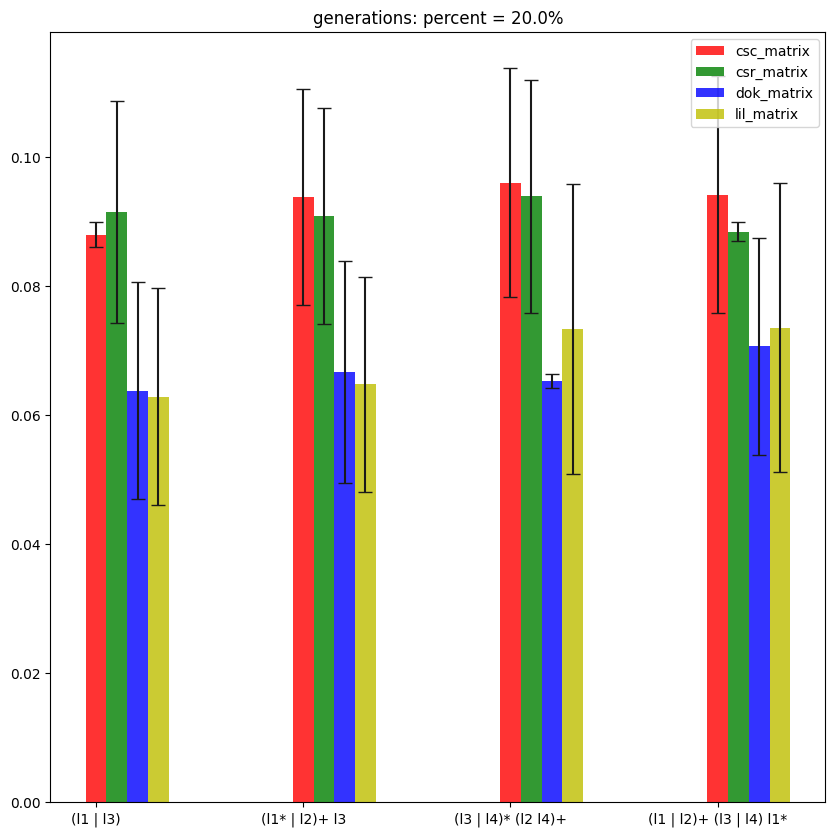

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


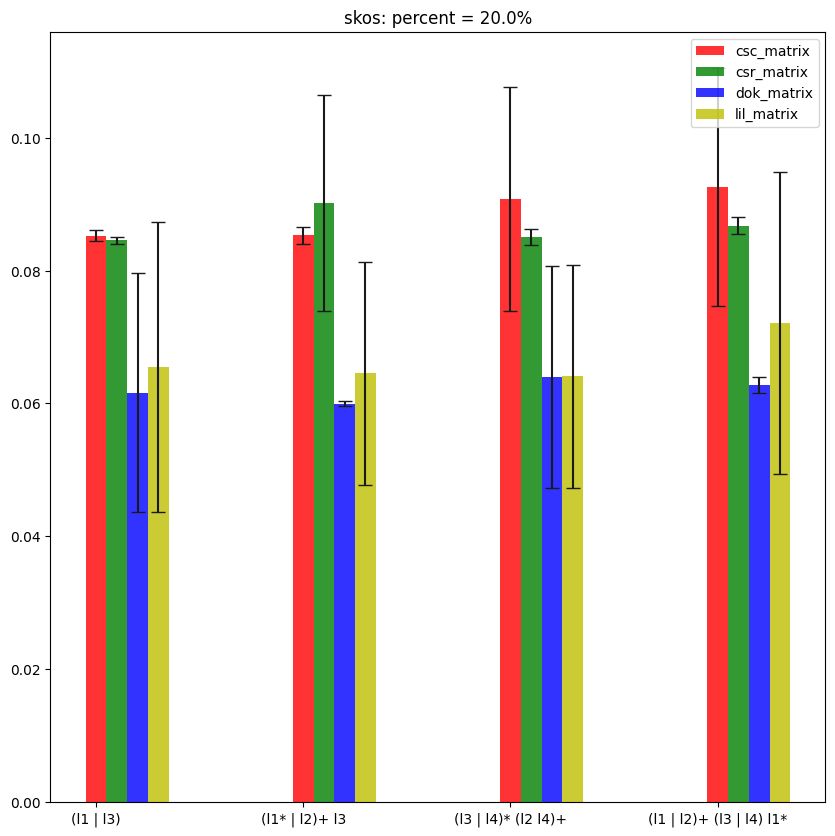

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


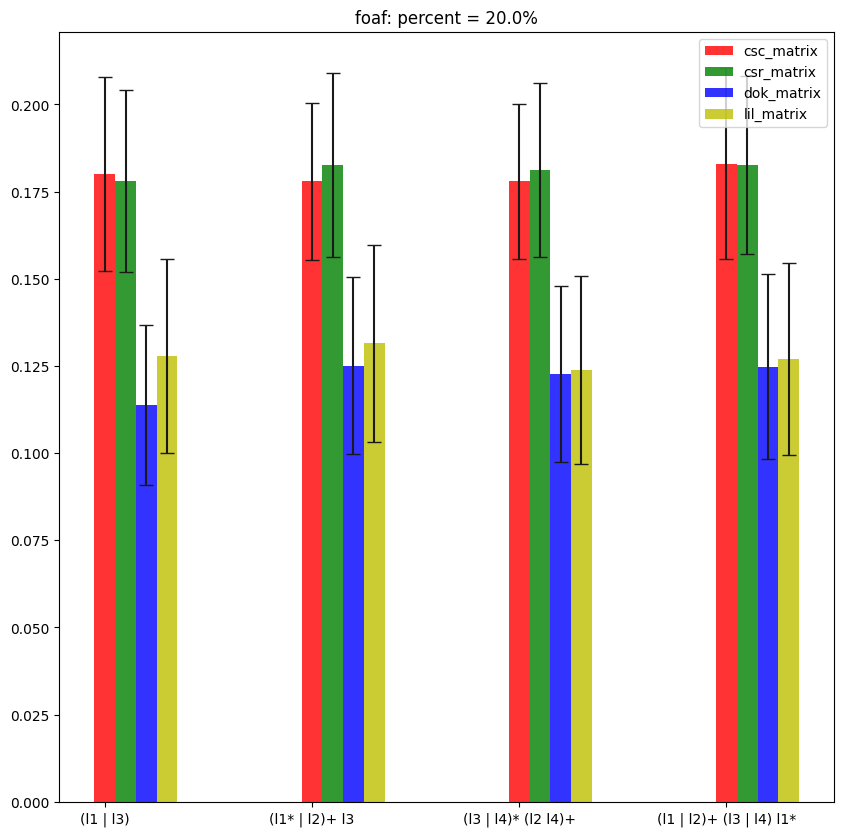

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


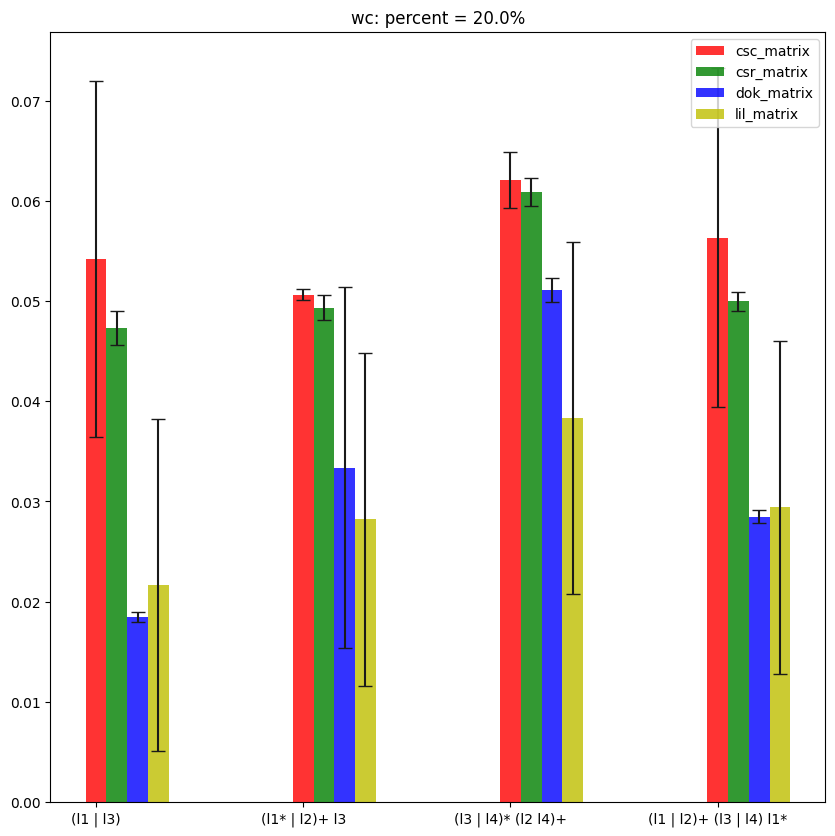

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


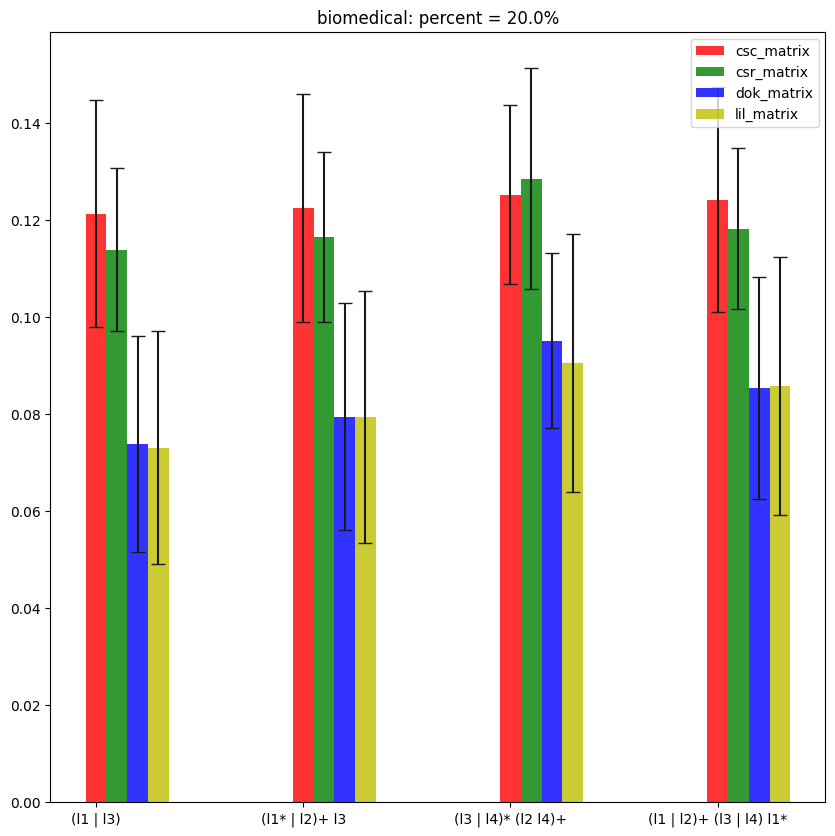

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


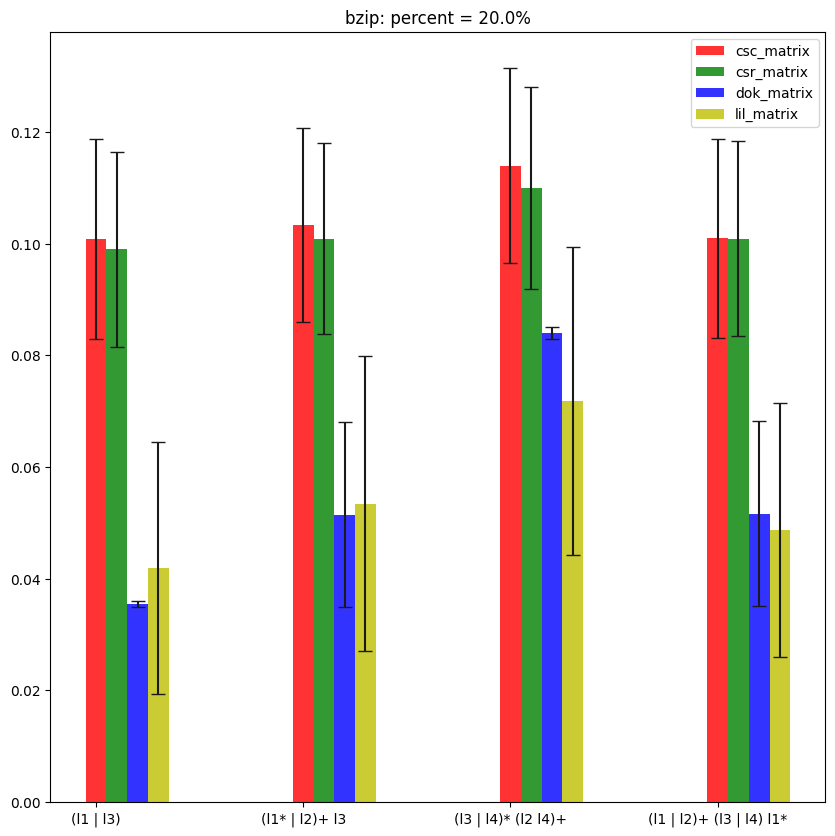

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


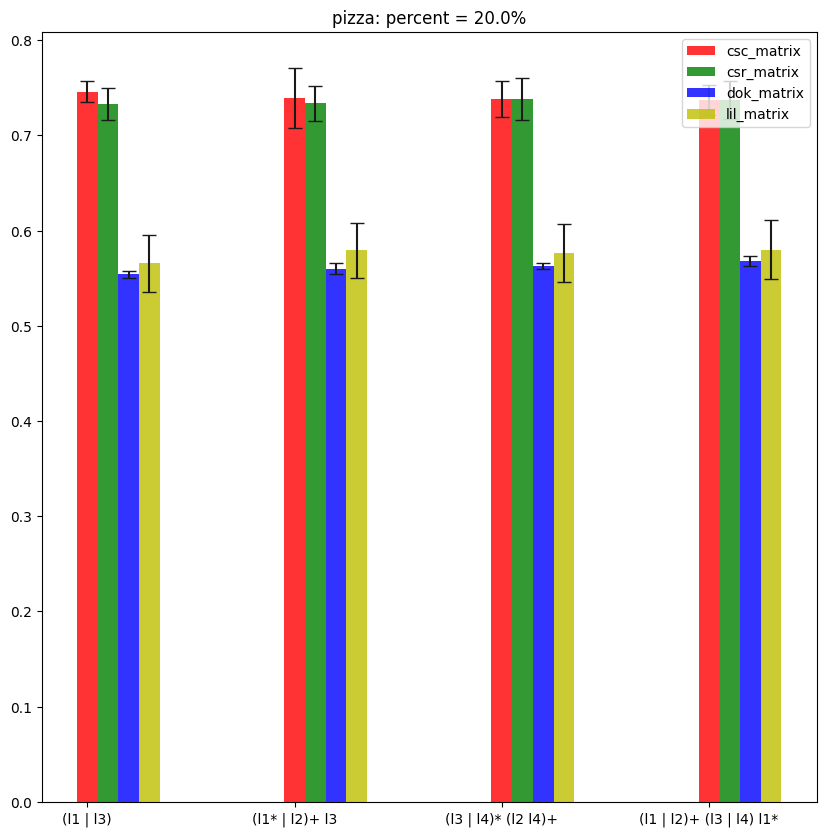

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


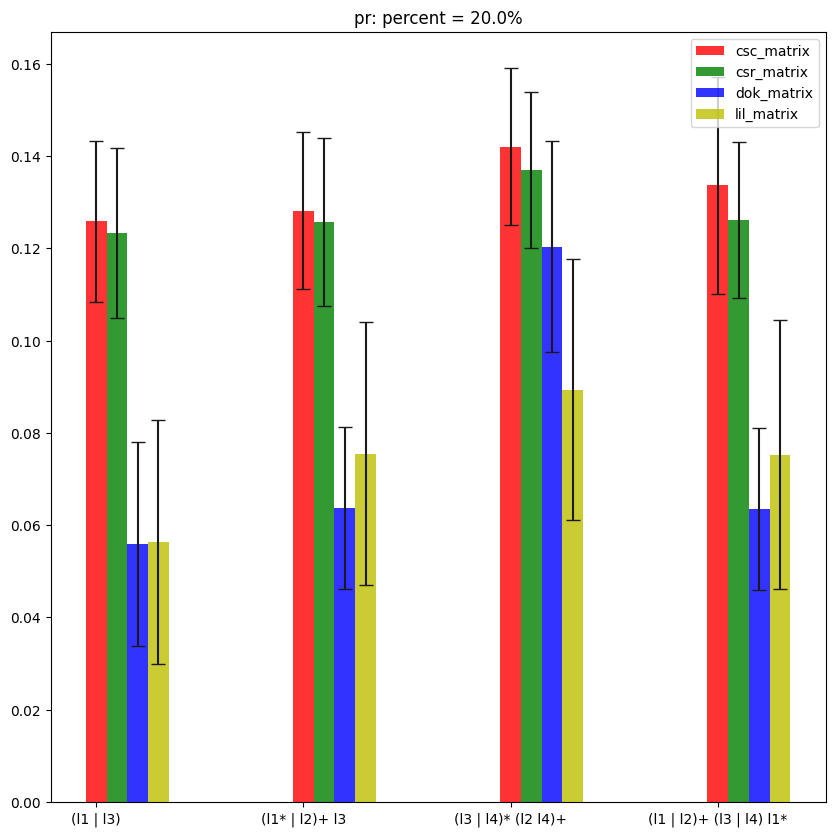

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


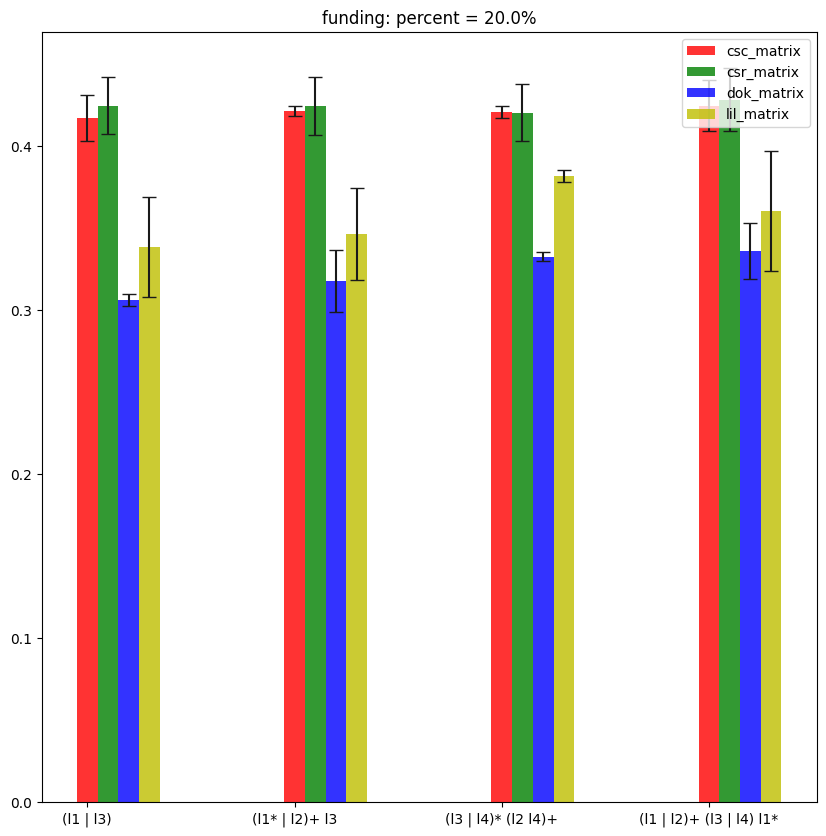

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


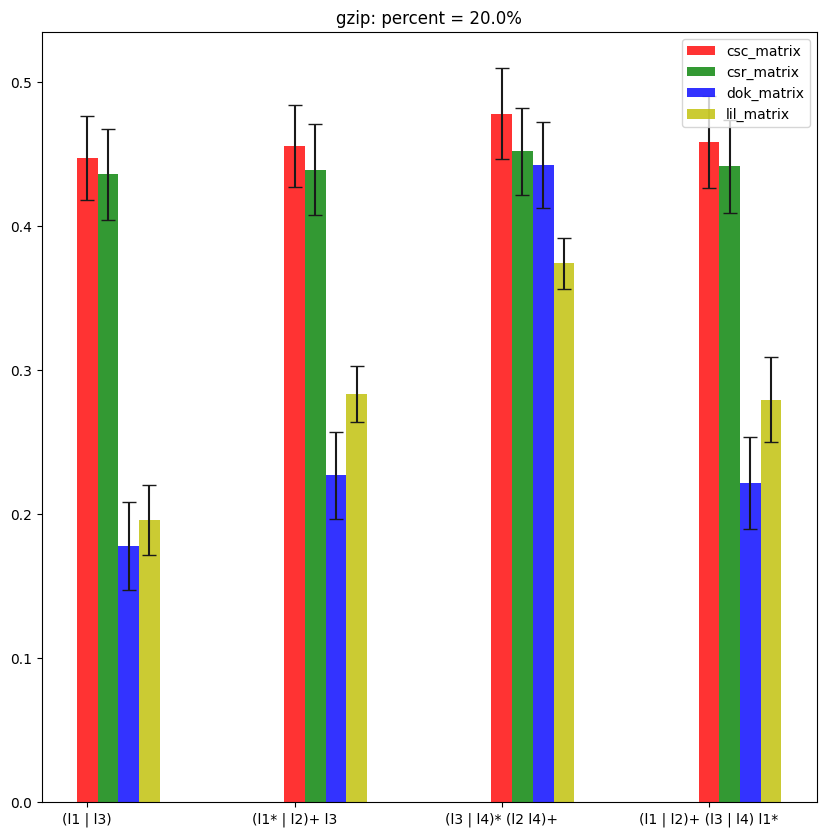

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


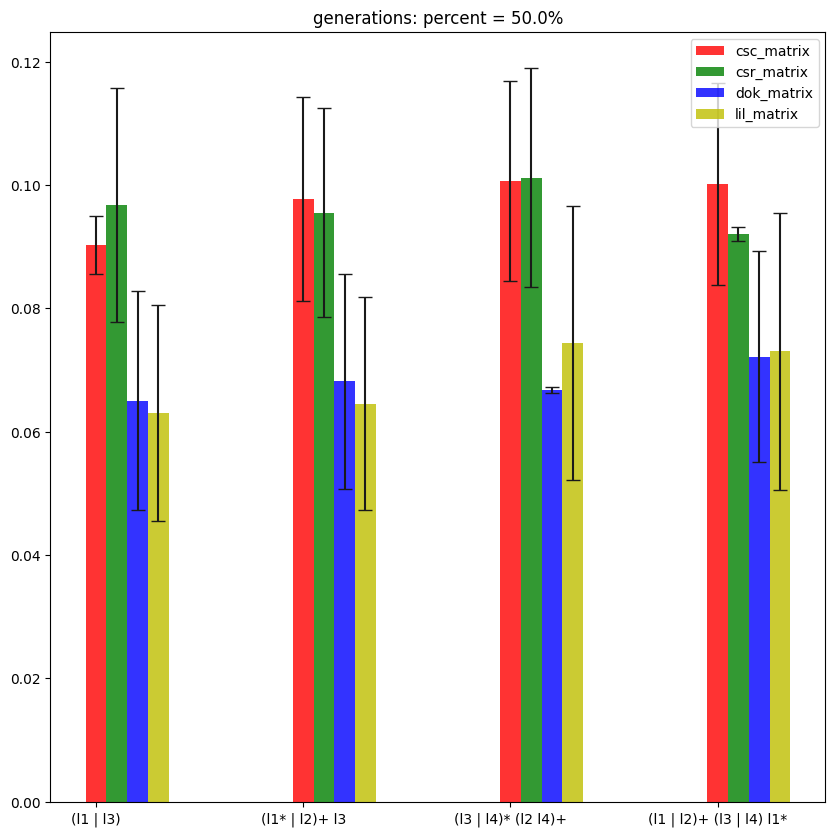

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


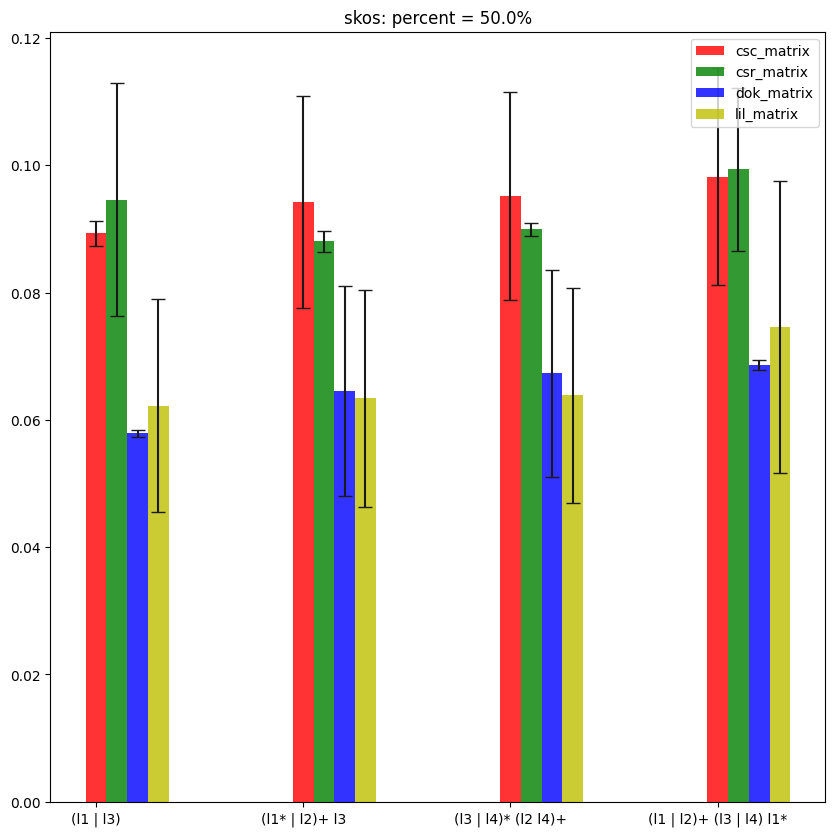

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


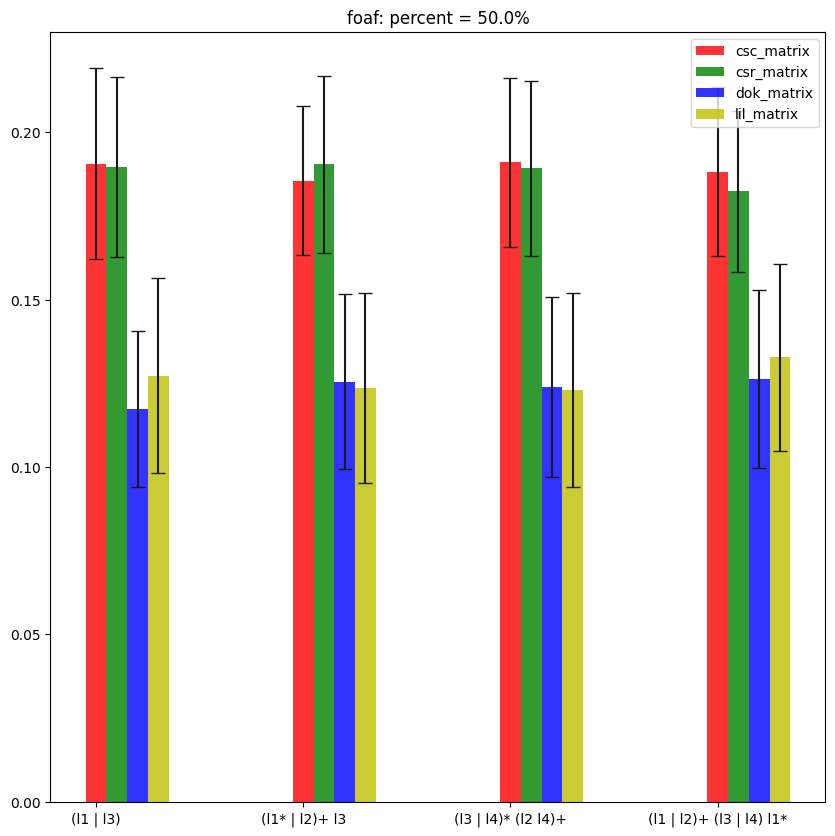

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


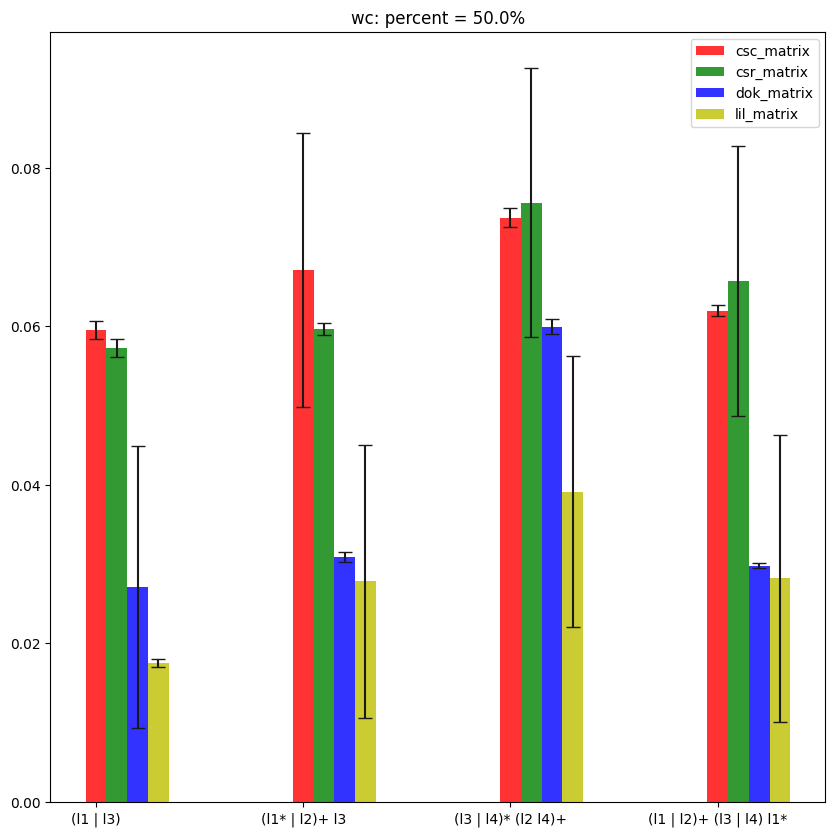

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


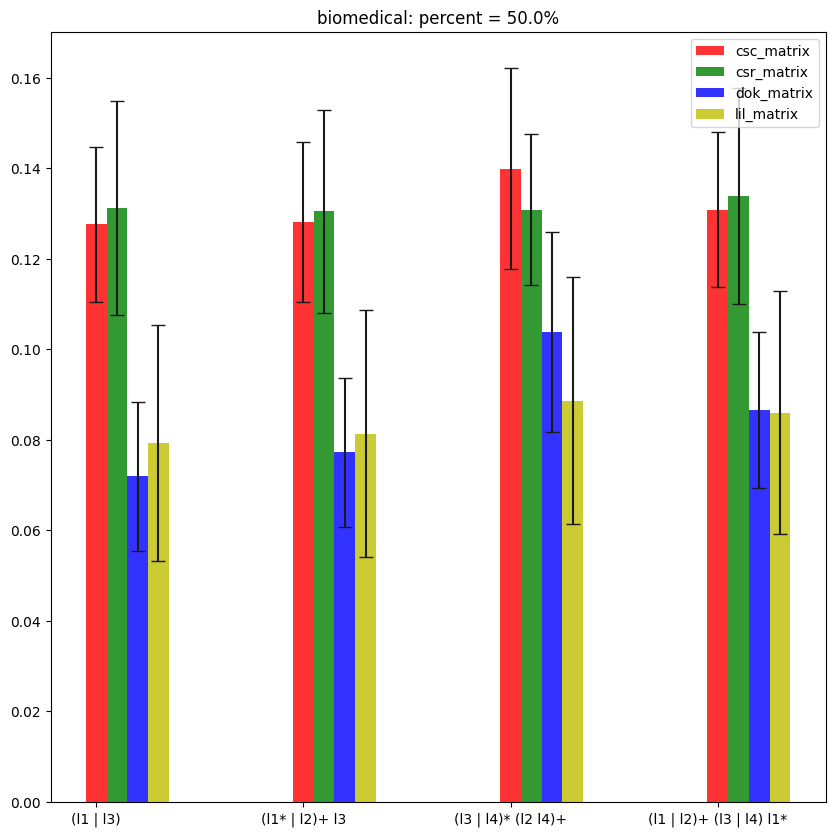

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


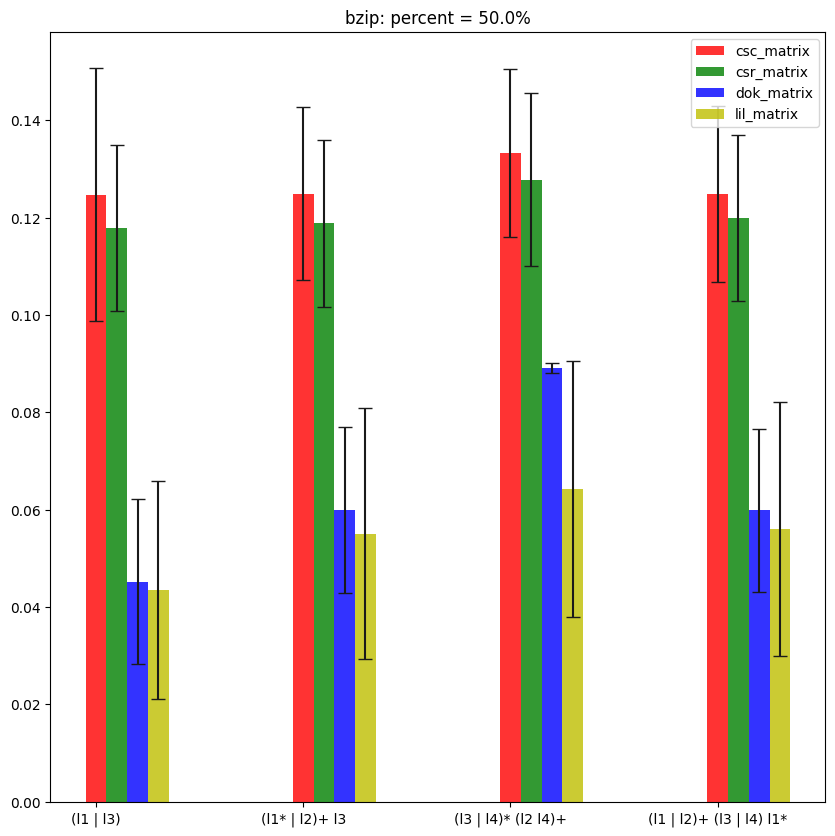

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


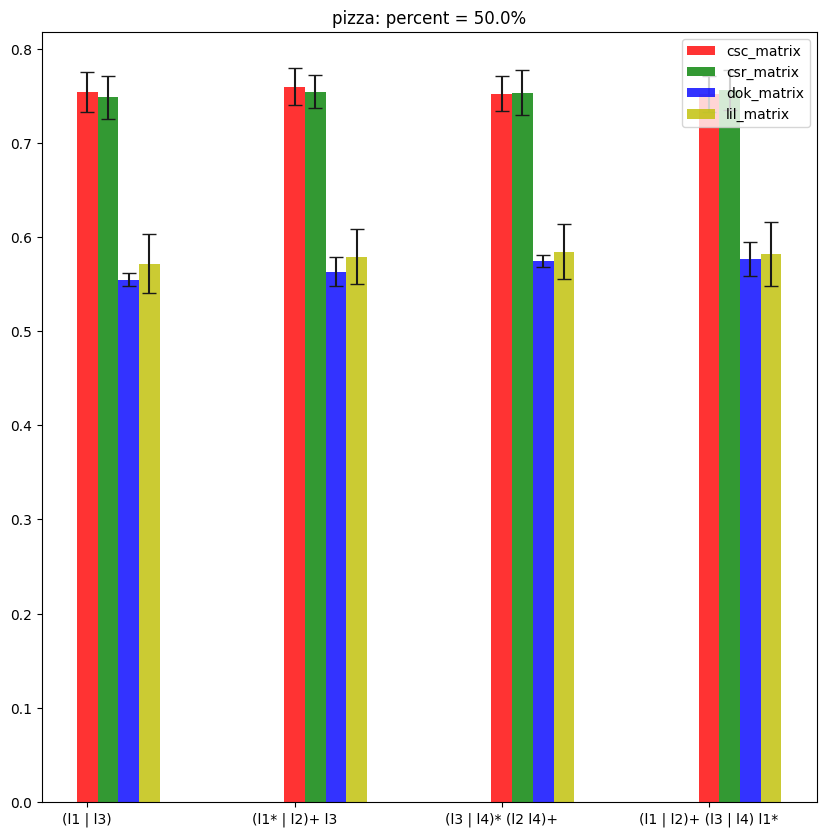

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


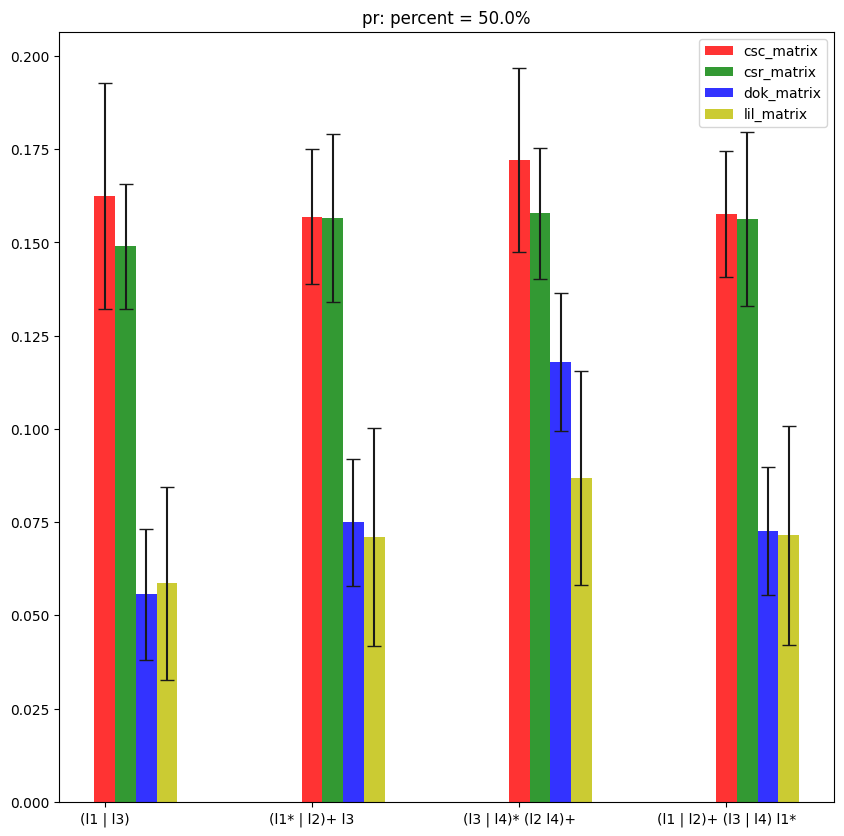

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


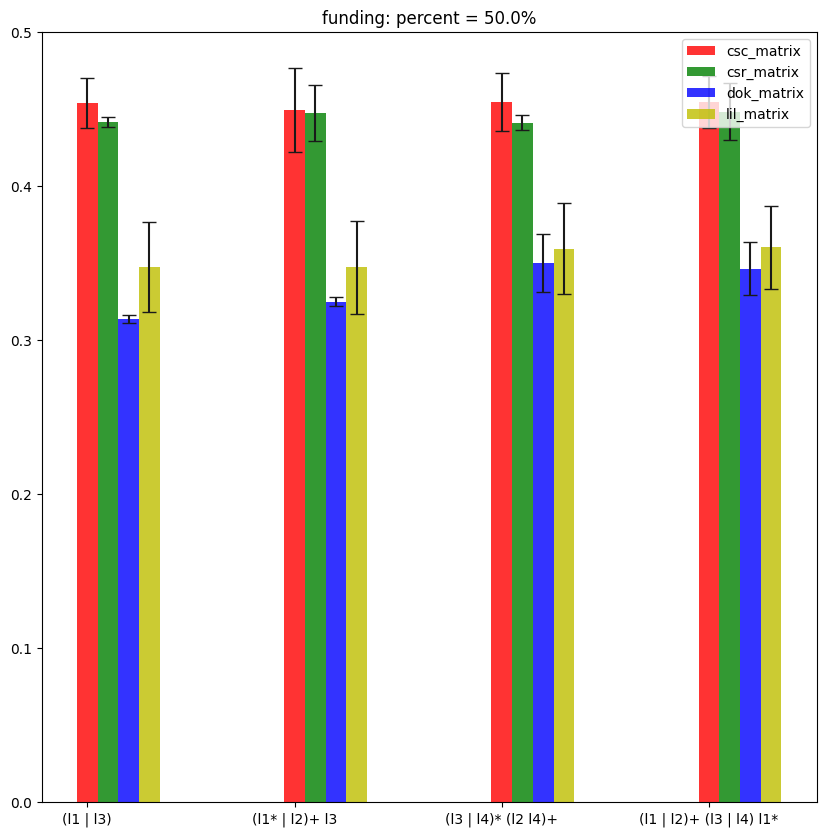

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


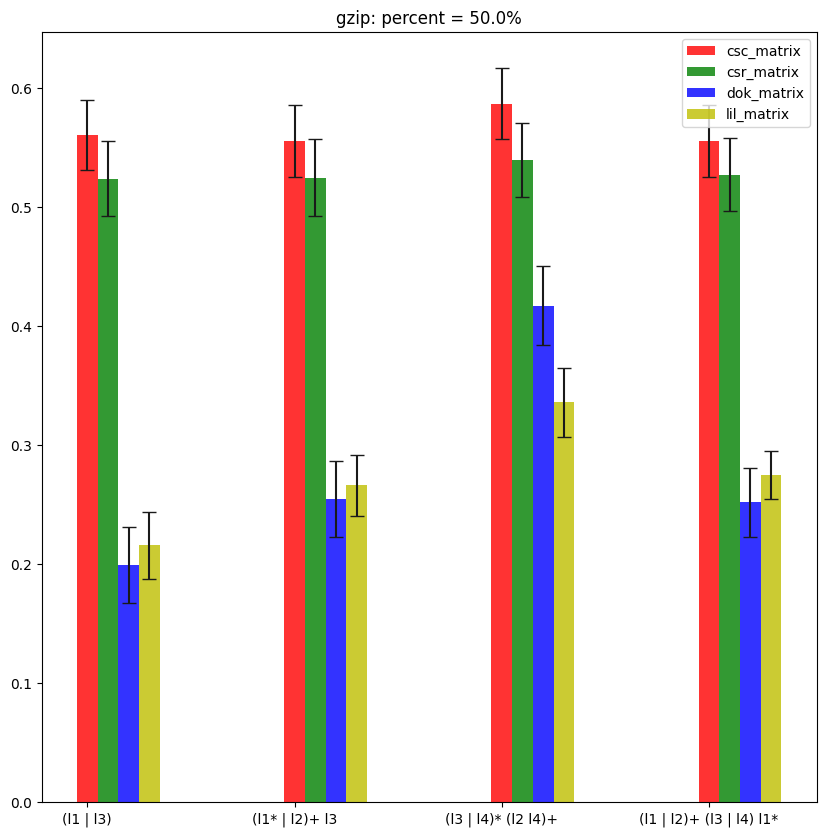

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


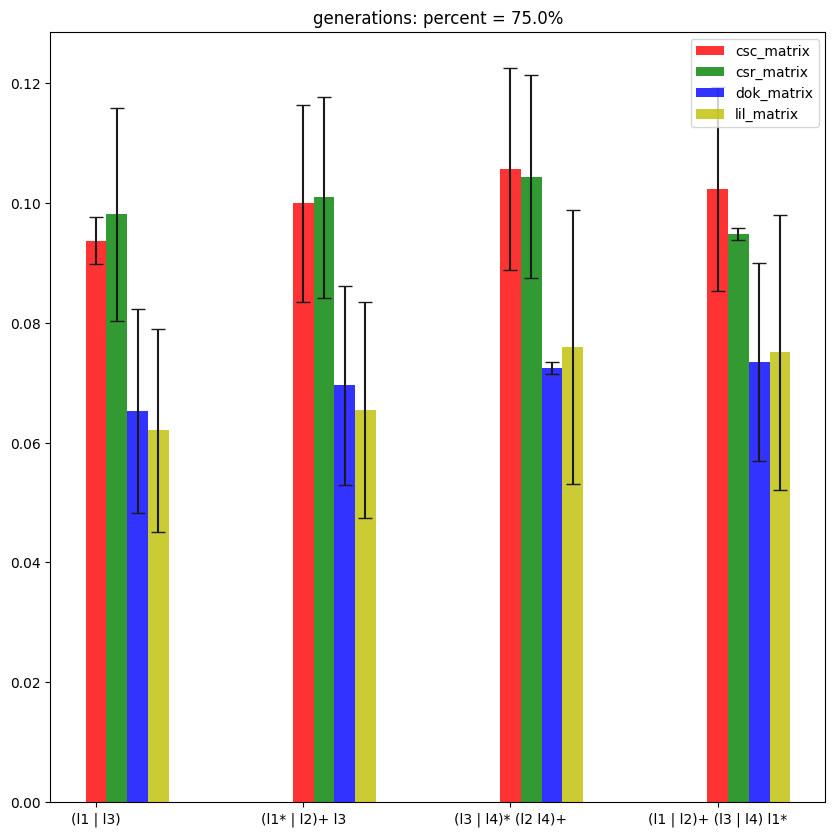

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


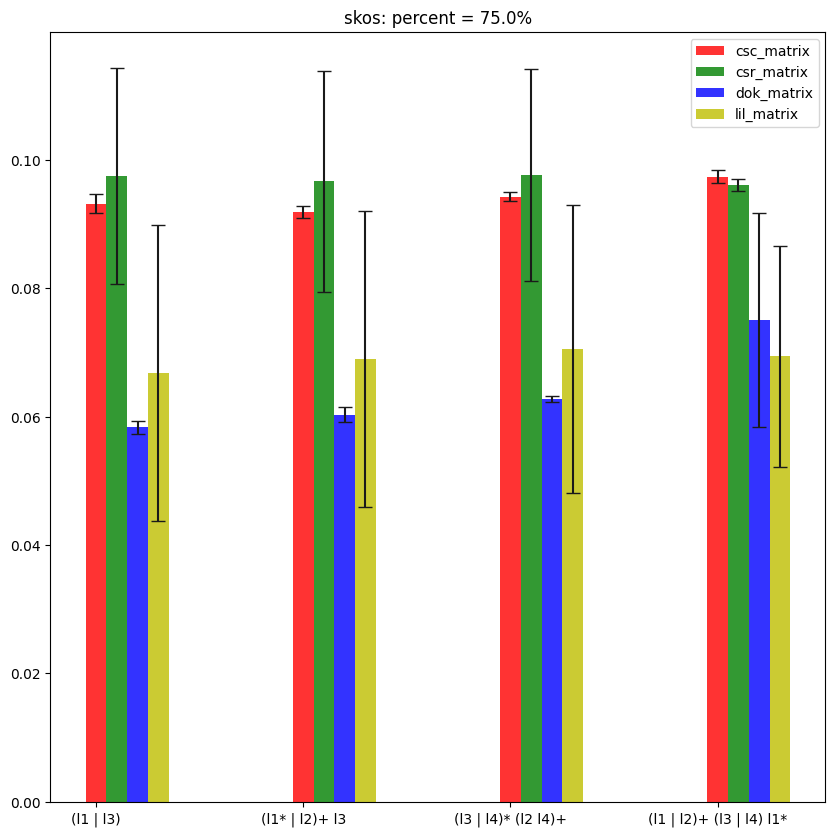

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


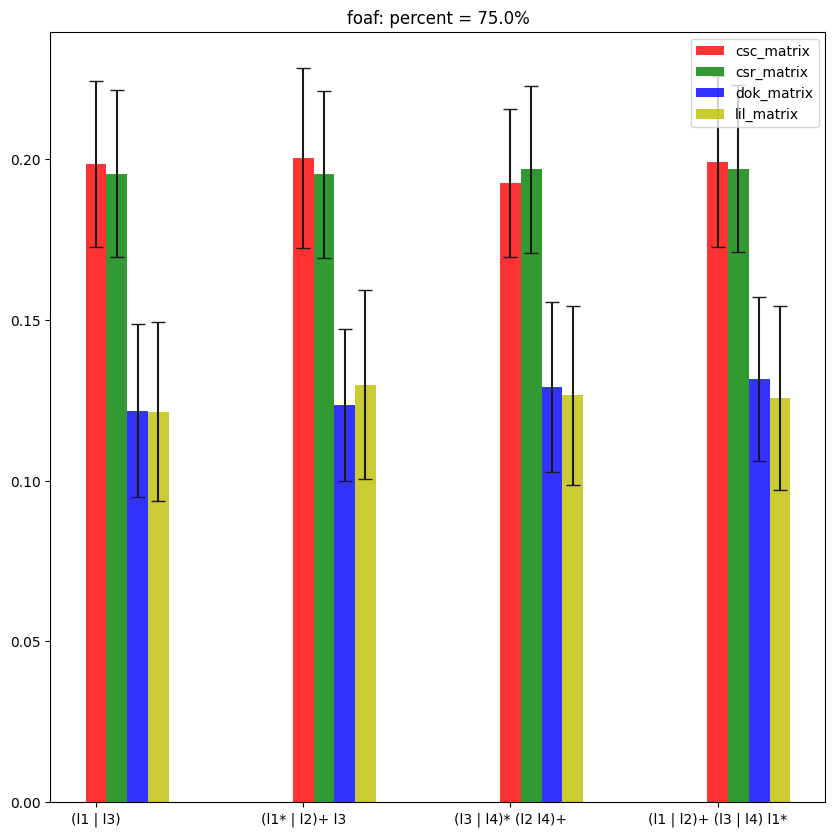

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


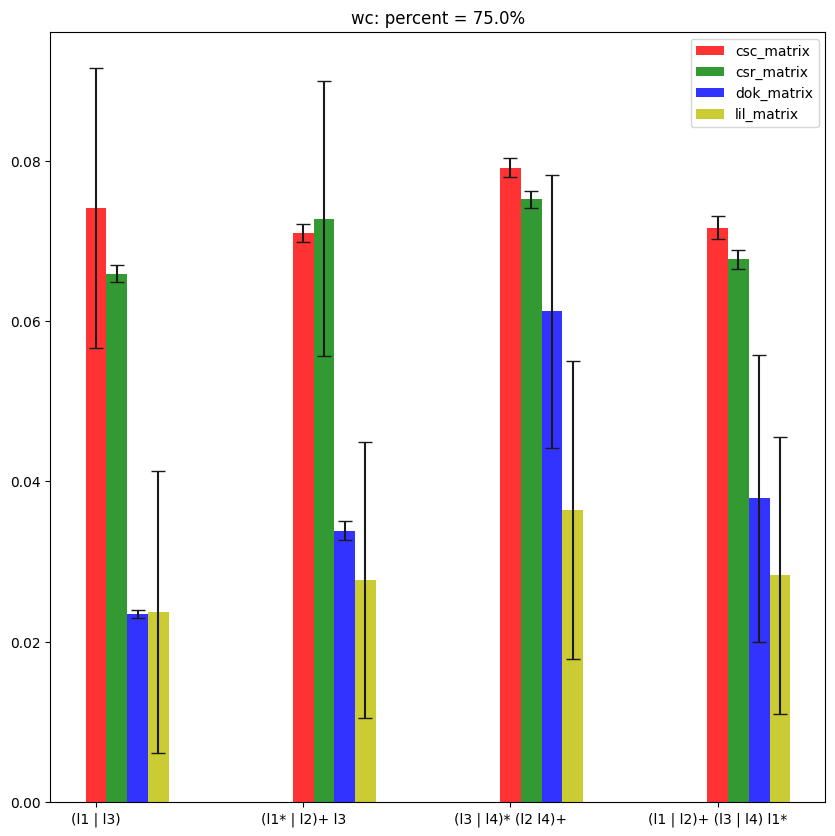

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


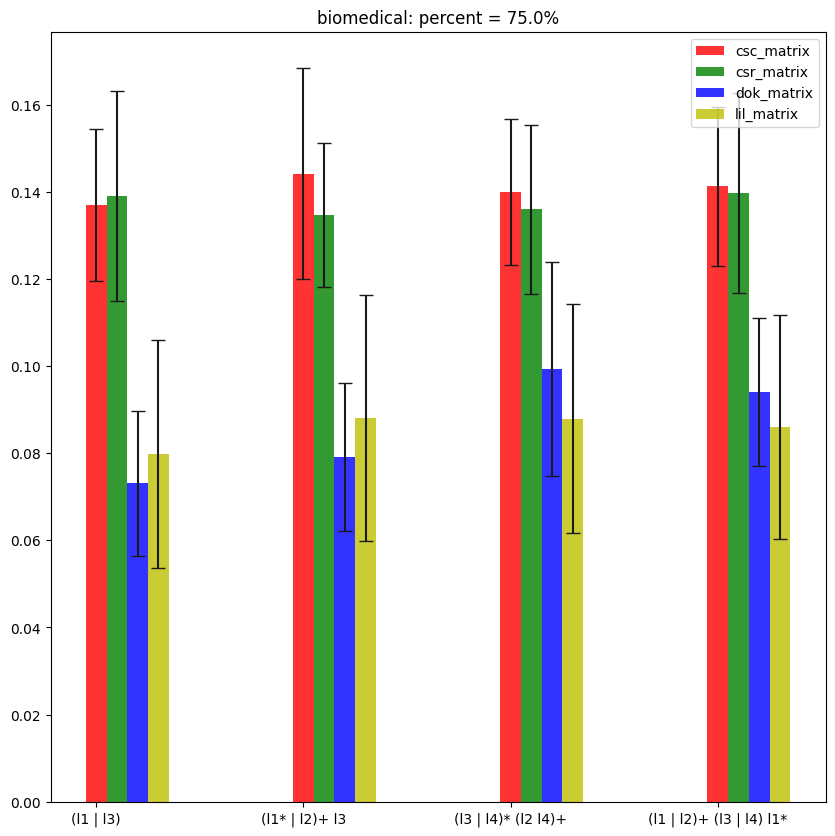

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


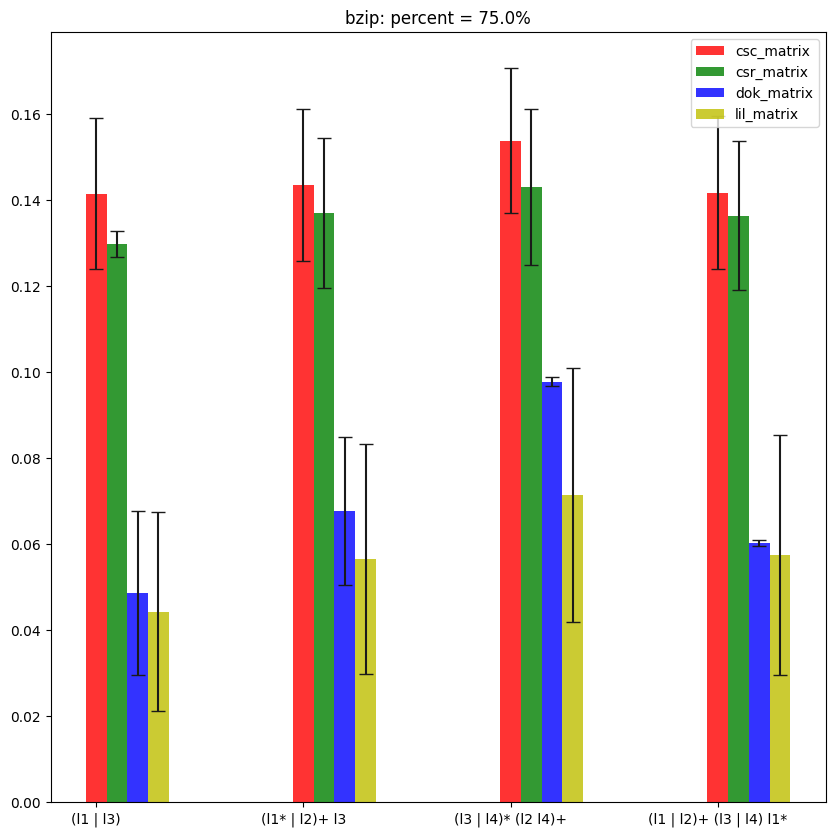

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


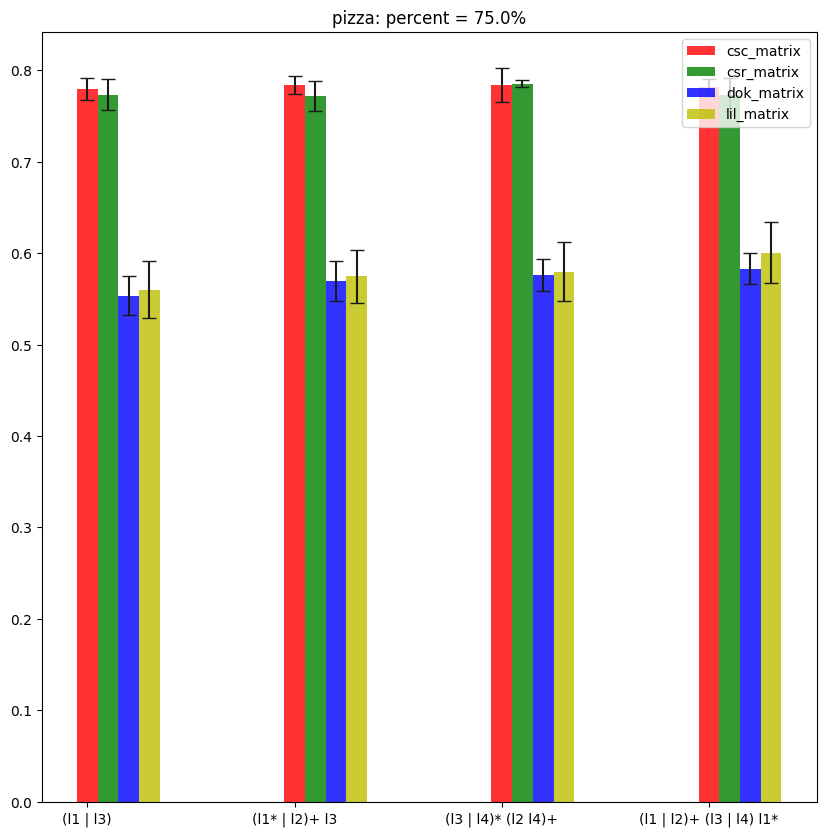

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


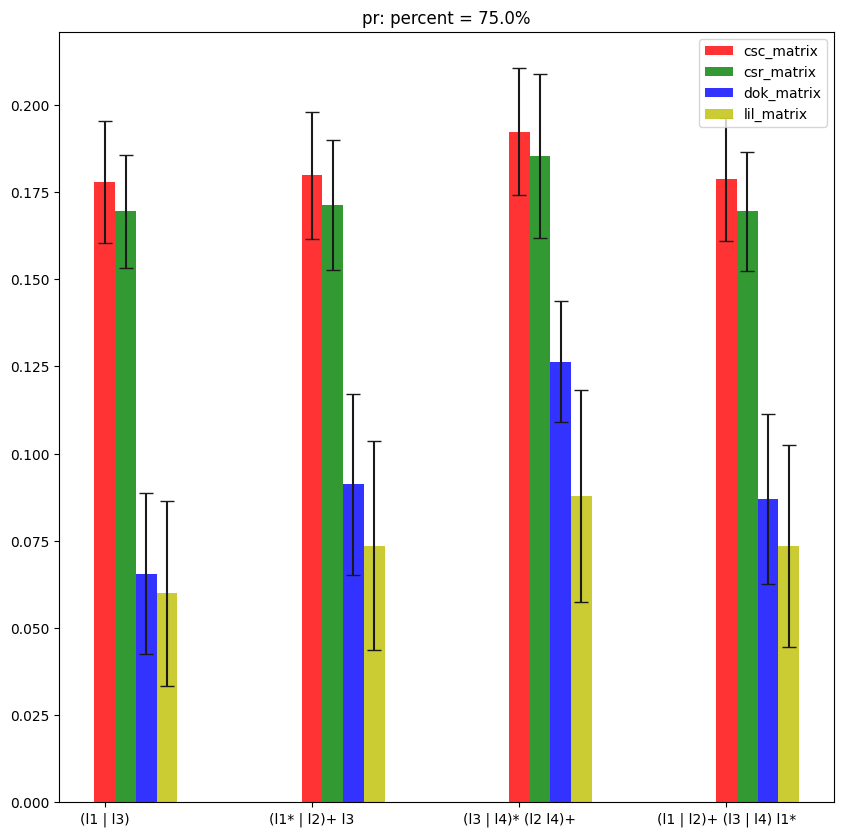

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


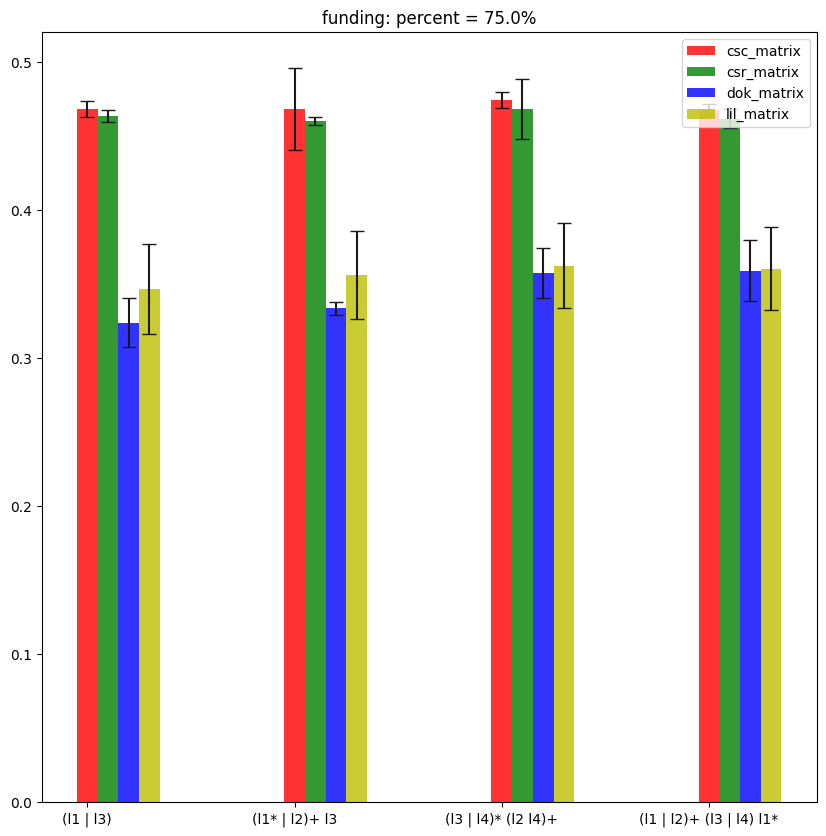

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


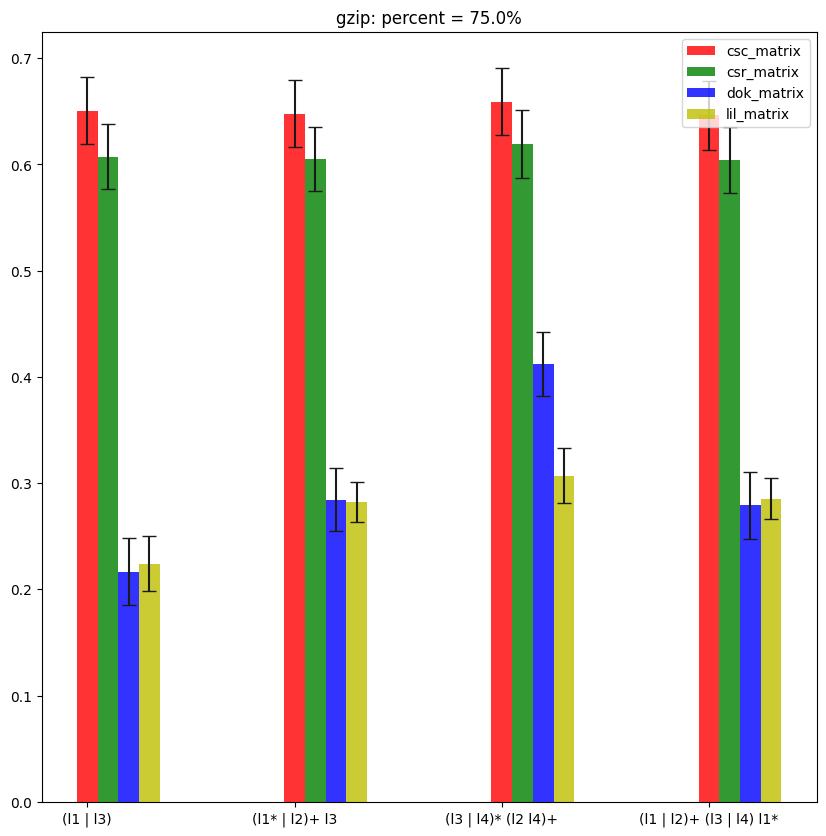

name percent  lil_matrix_time  lil_matrix_tstd  \
0           all_pair_tensor     100         0.156080         0.020080   
0              all_pair_bfs     100         0.169762         0.024241   
0  grouped_start_set_tensor    10.0         0.149138         0.018213   
0  grouped_start_set_tensor    20.0         0.152614         0.019816   
0  grouped_start_set_tensor    50.0         0.151832         0.019391   
0  grouped_start_set_tensor    75.0         0.155173         0.021394   
0     grouped_start_set_bfs    10.0         0.169616         0.024403   
0     grouped_start_set_bfs    20.0         0.171766         0.023978   
0     grouped_start_set_bfs    50.0         0.170588         0.024580   
0     grouped_start_set_bfs    75.0         0.171966         0.025355   

   dok_matrix_time  dok_matrix_tstd  csr_matrix_time  csr_matrix_tstd  \
0         0.162223         0.020487         0.145940         0.017727   
0         0.176780         0.018813         0.295483         0.017593   
0         0.153946         0.018673         0.140217         0.016705   
0         0.155978         0.019003         0.141444         0.017250   
0         0.156163         0.017040         0.140490         0.015512   
0         0.157555         0.015015         0.143415         0.017208   
0         0.158924         0.016301         0.230129         0.017819   
0         0.164964         0.014817         0.236317         0.016748   
0         0.170292         0.015471         0.257589         0.018012   
0         0.175912         0.016815         0.275929         0.016376   

   csc_matrix_time  csc_matrix_tstd  
0         0.146700         0.018145  
0         0.305924         0.017422  
0         0.140410         0.018863  
0         0.142192         0.016911  
0         0.142694         0.018364  
0         0.142776         0.016112  
0         0.230515         0.016145  
0         0.239835         0.017437  
0         0.263892         0.018697  
0         0.283657         0.015475

In [30]:
for percent in percents:
    results = rpq_request_performance_check(percent=percent, rpq_type="bfs")
    final_statistic = update_statistic("grouped_start_set_bfs", percent, results, final_statistic)
final_statistic

## Достижимость для каждой из заданного множества стартовых вершин.

### Алгоритм Tensor Multy

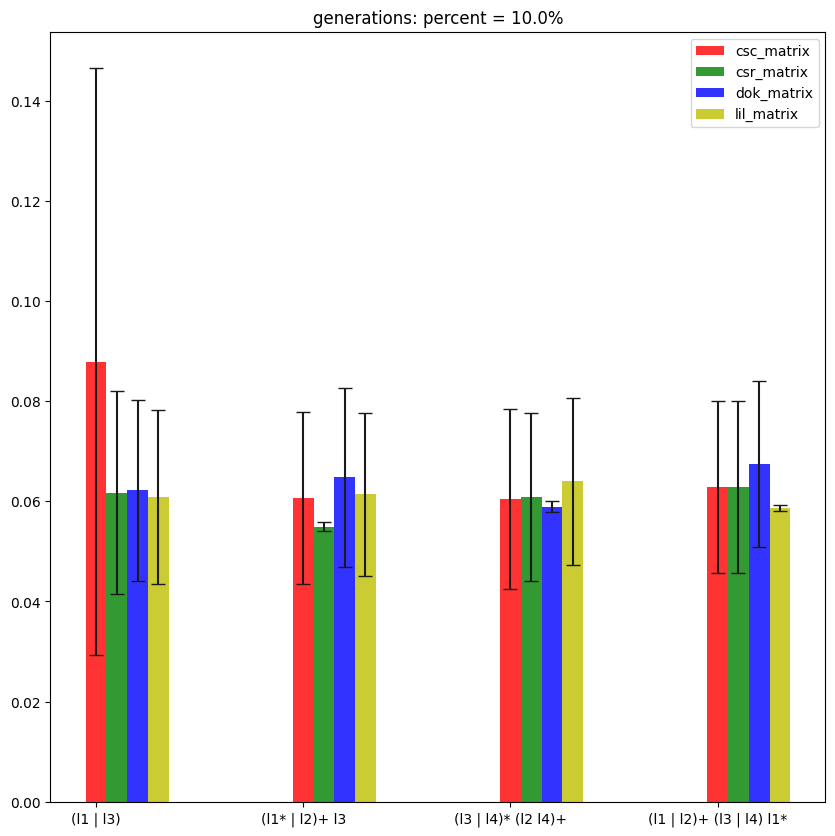

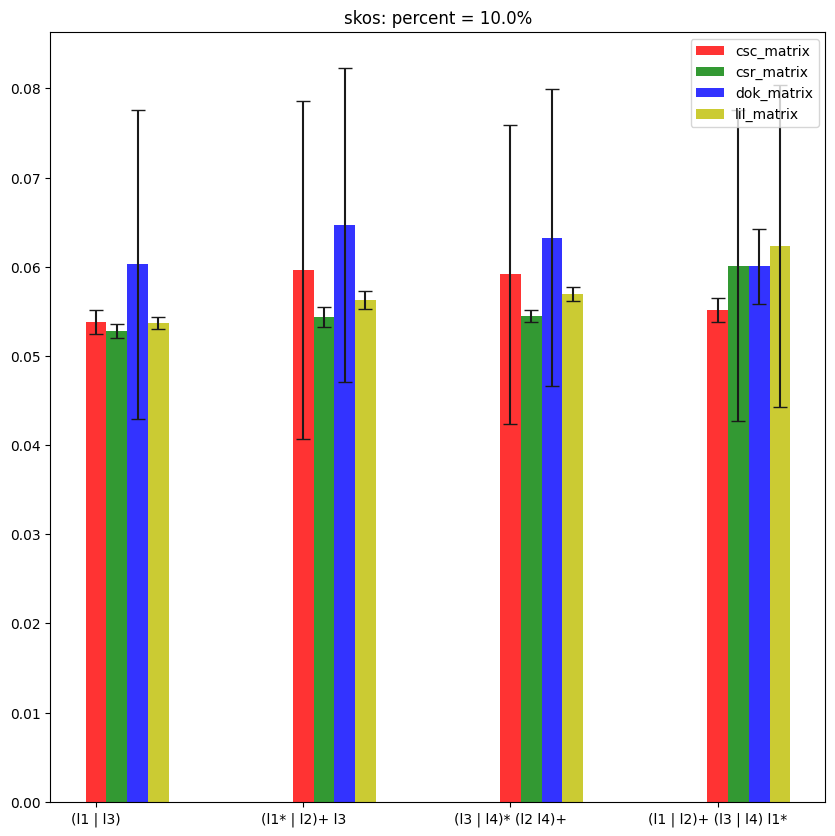

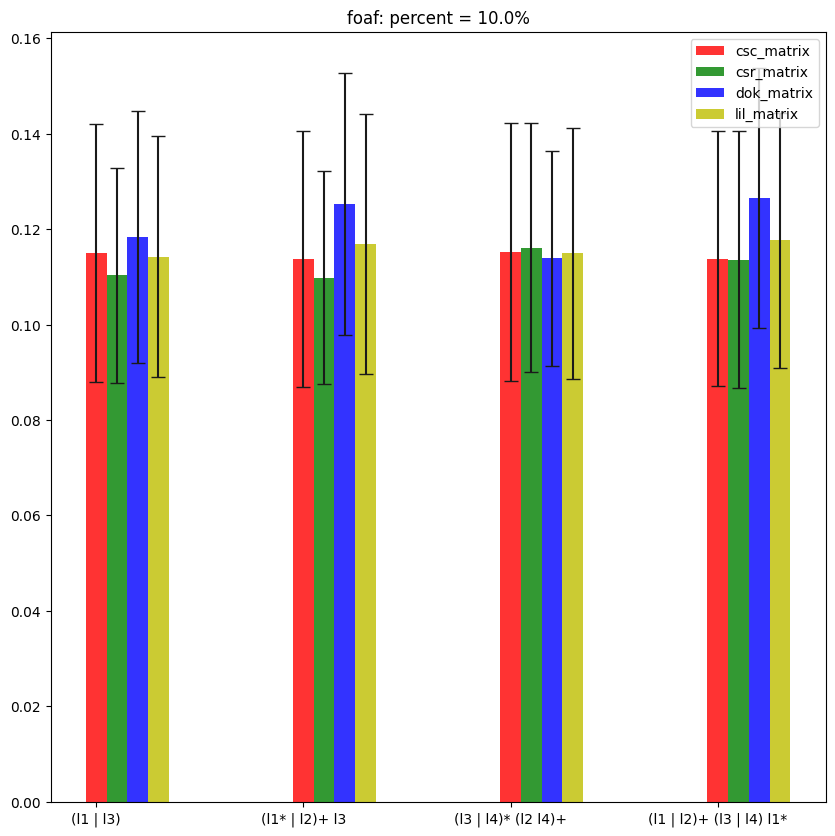

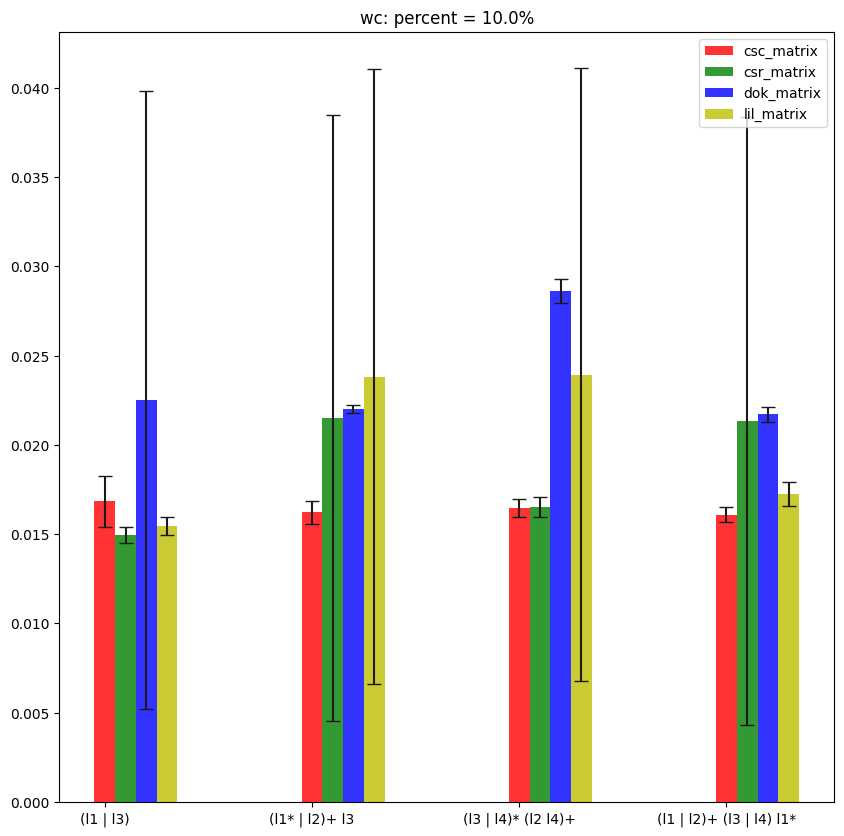

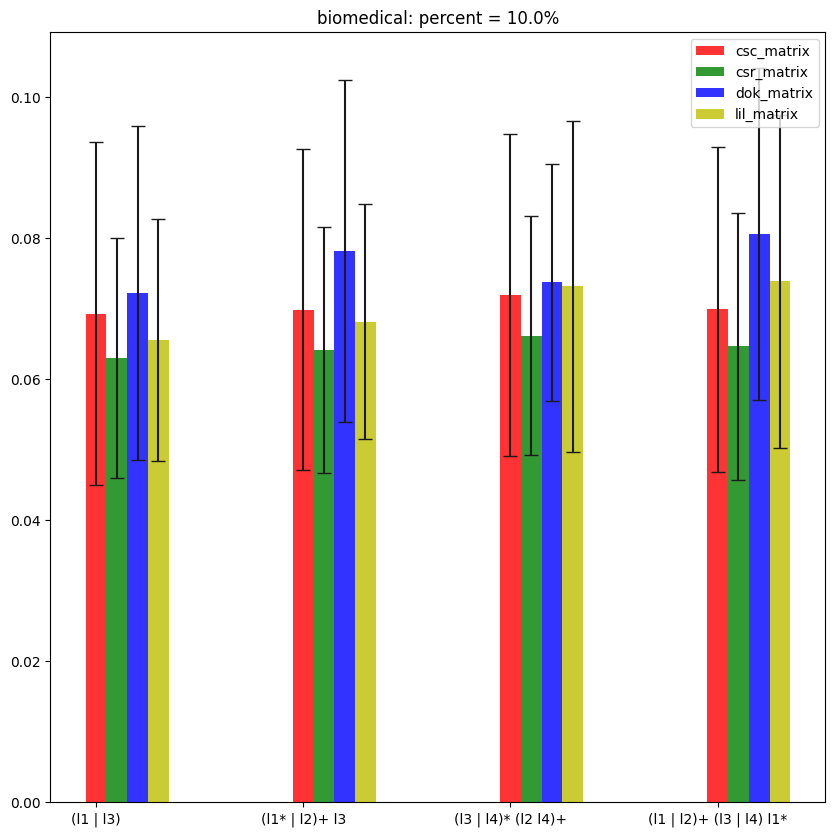

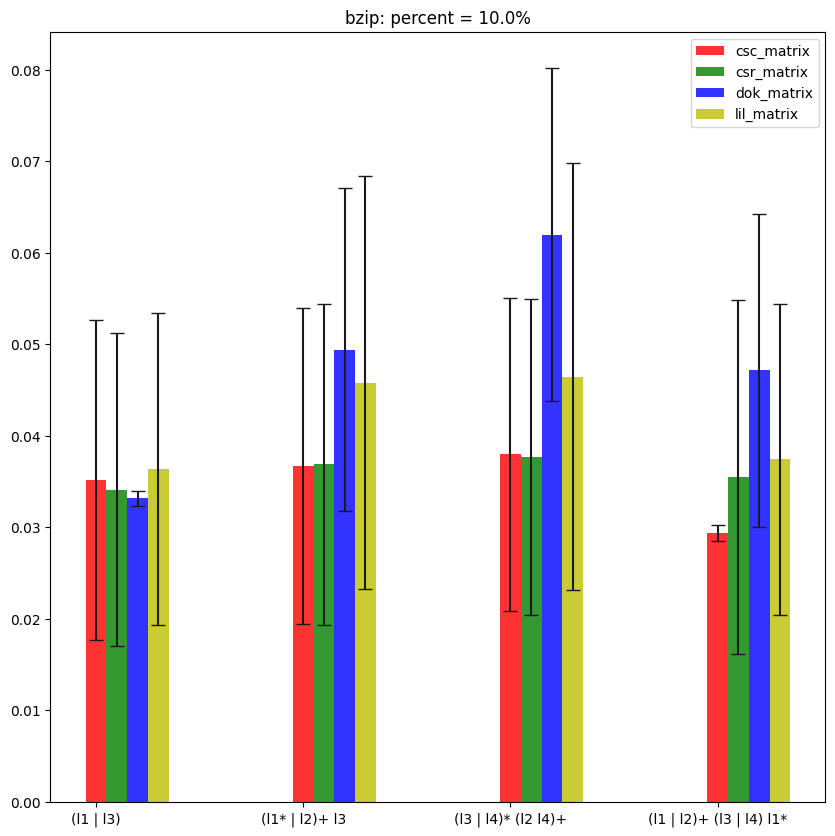

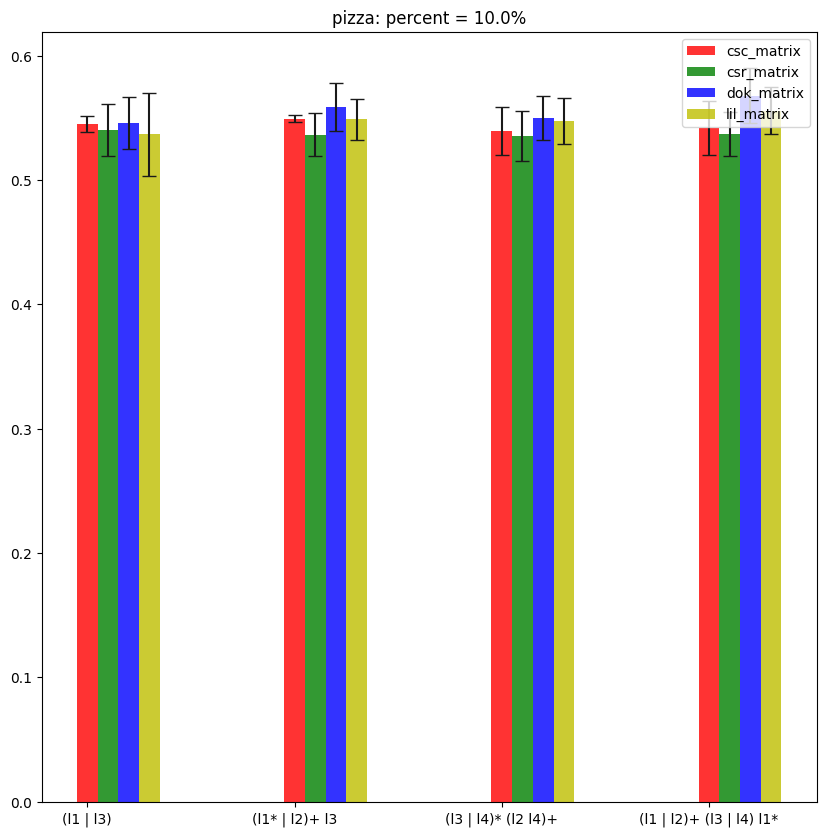

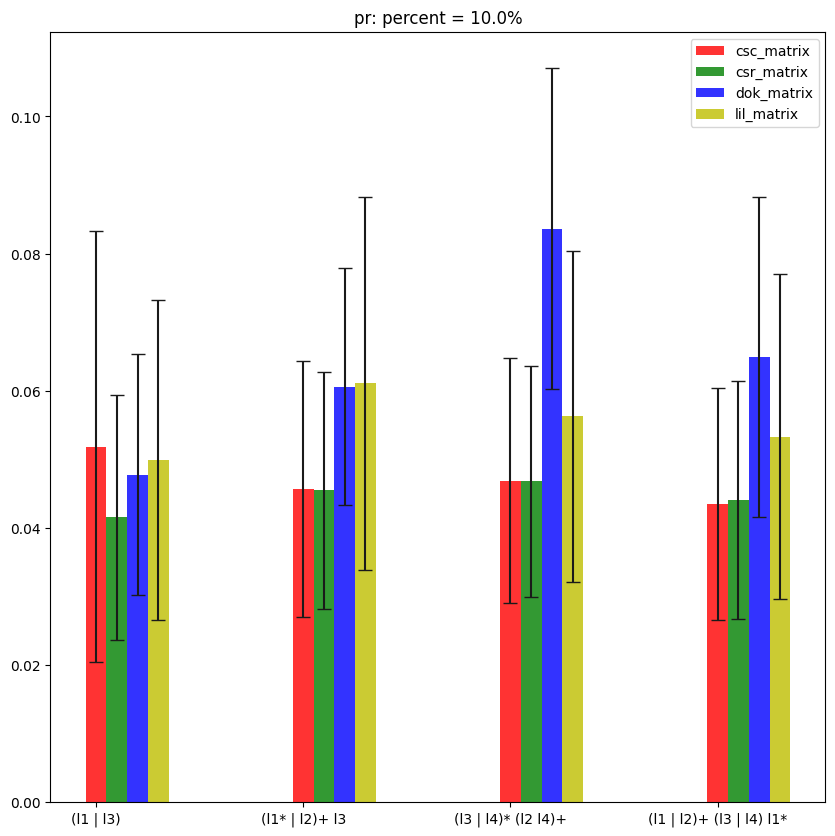

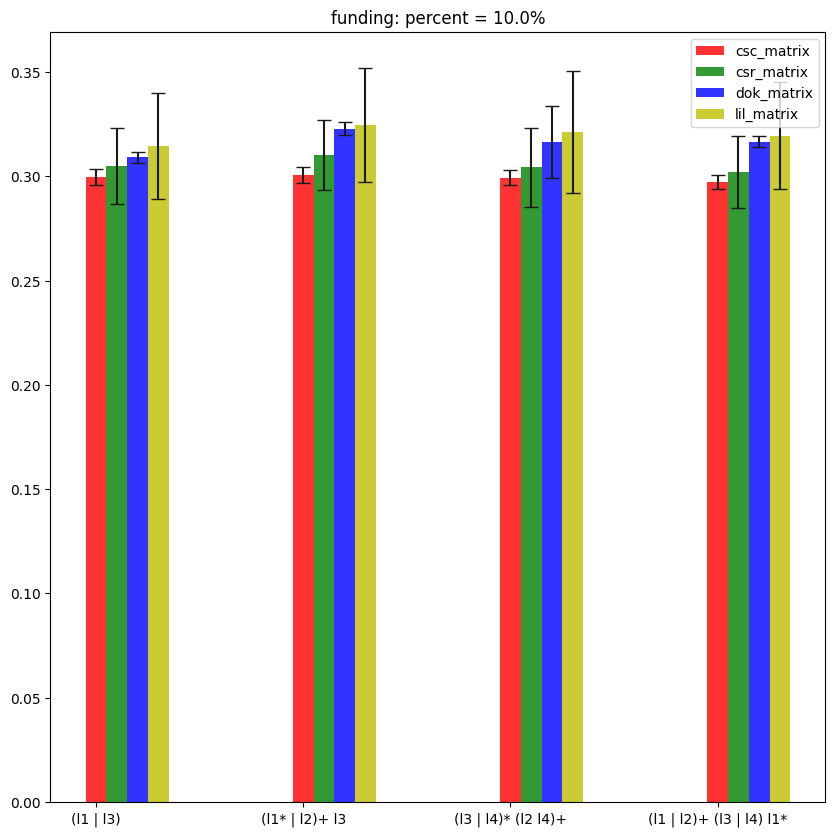

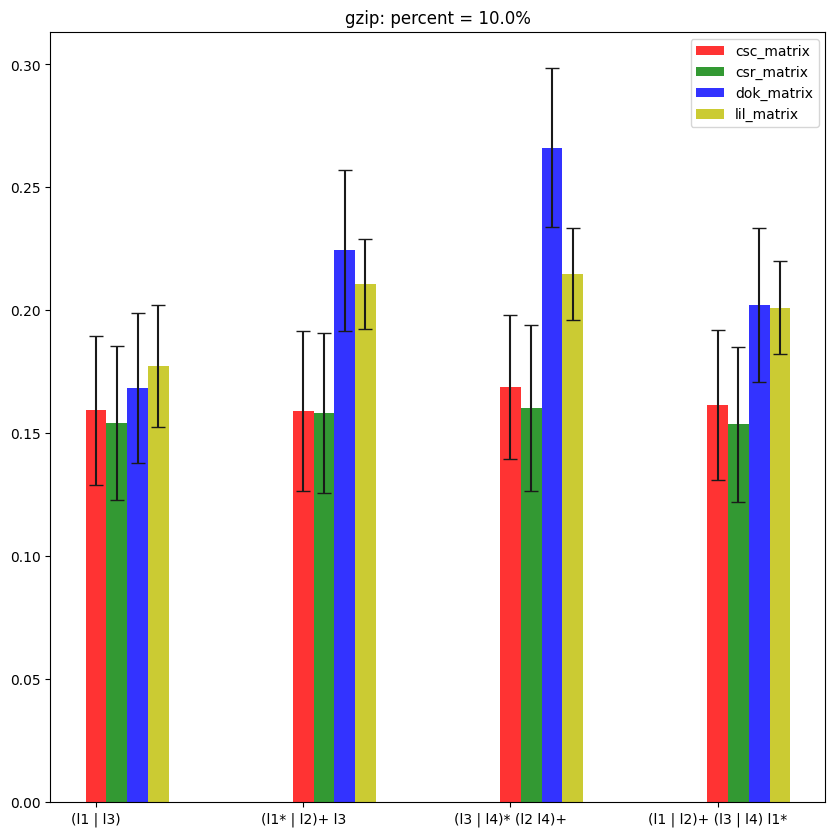

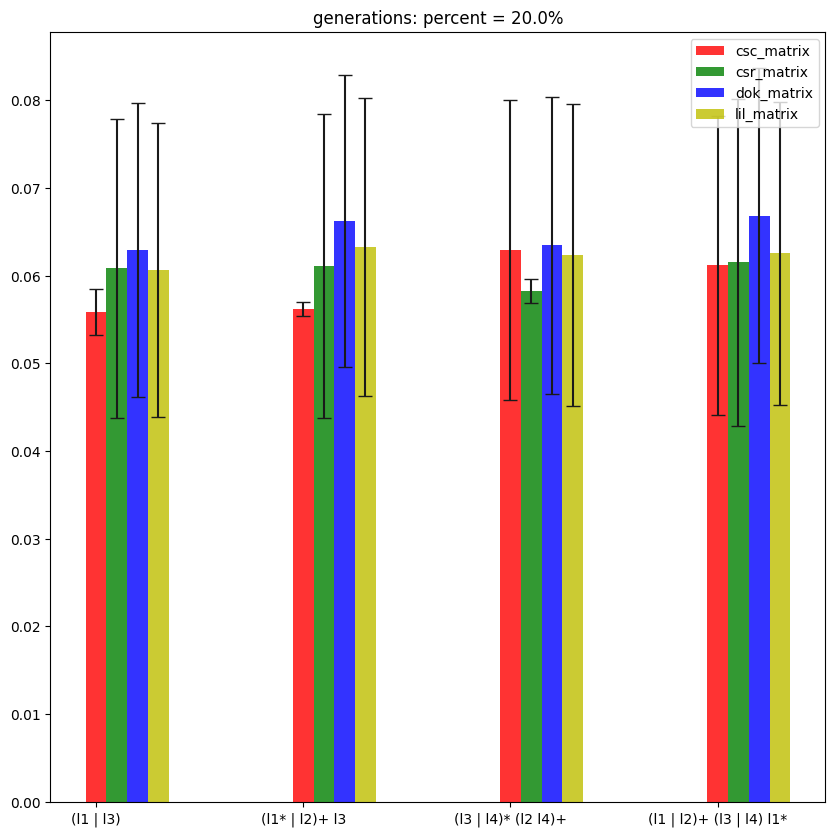

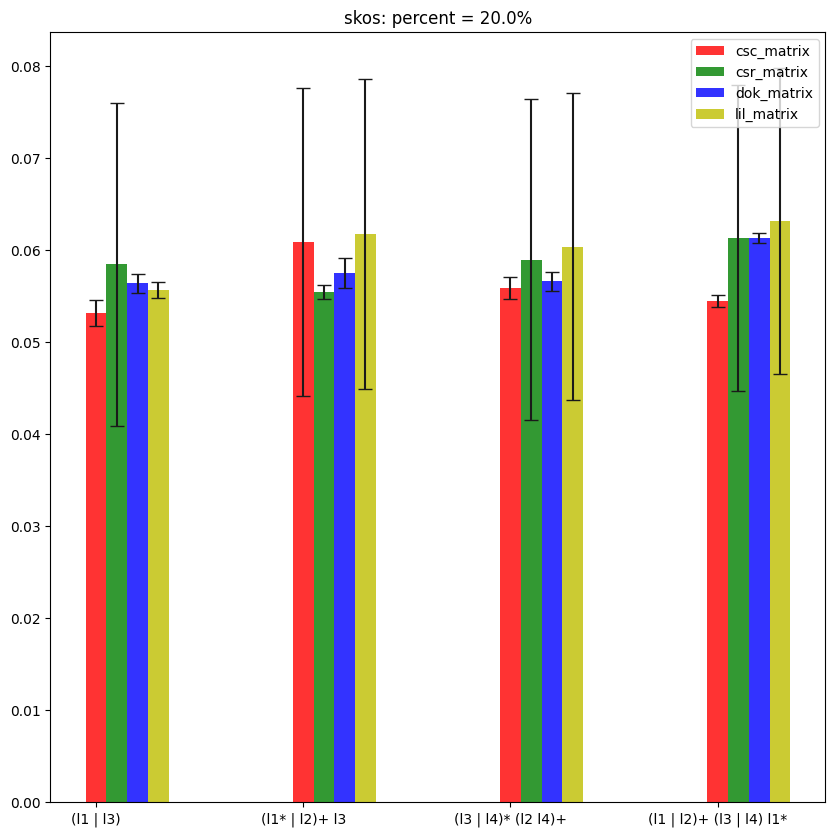

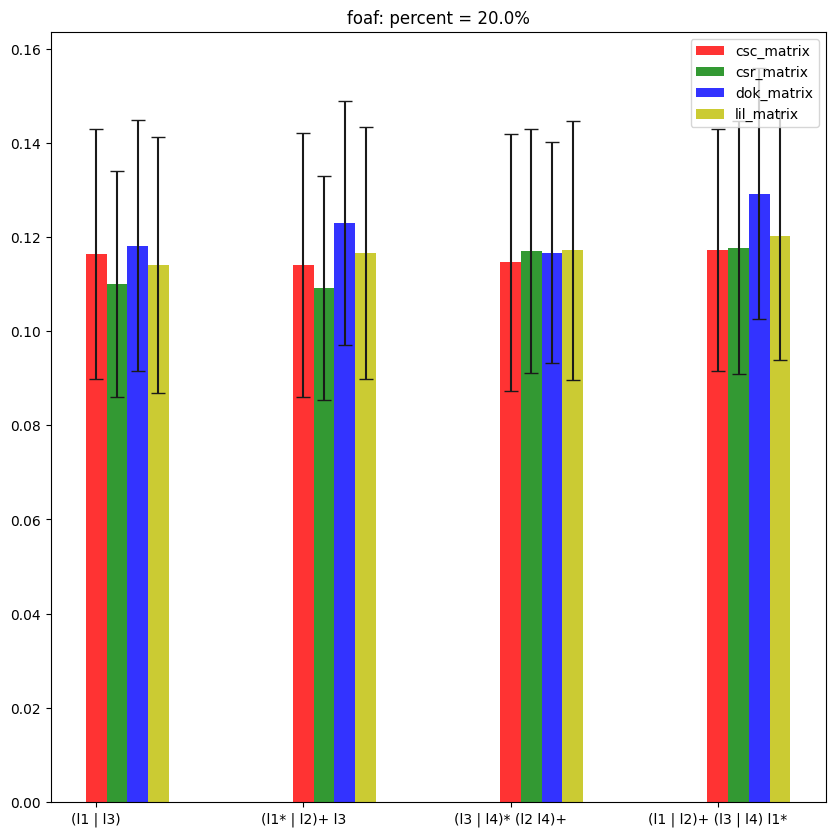

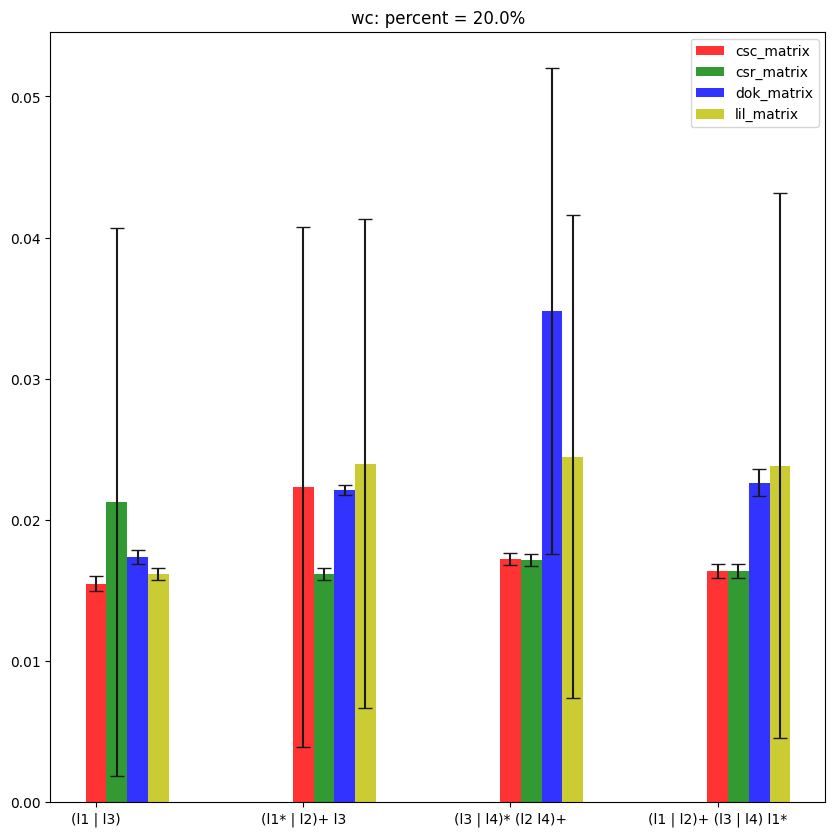

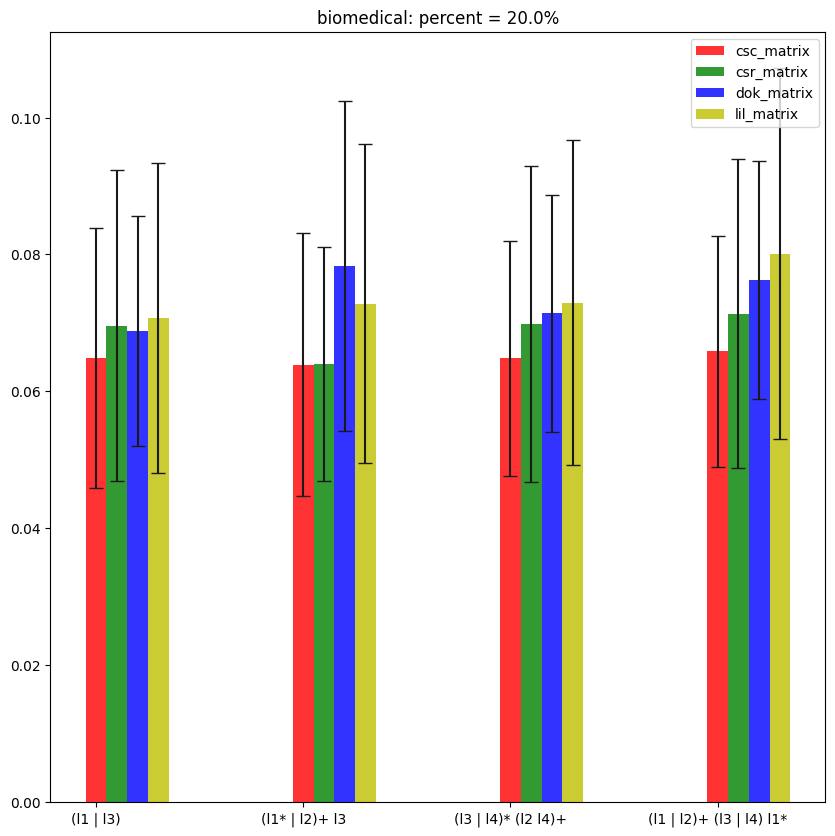

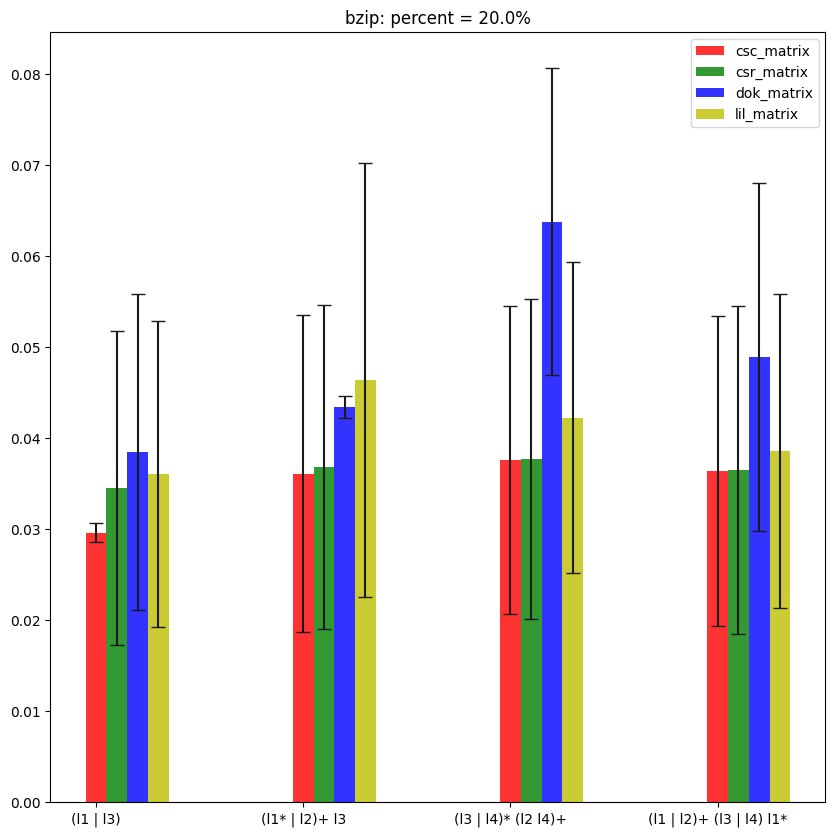

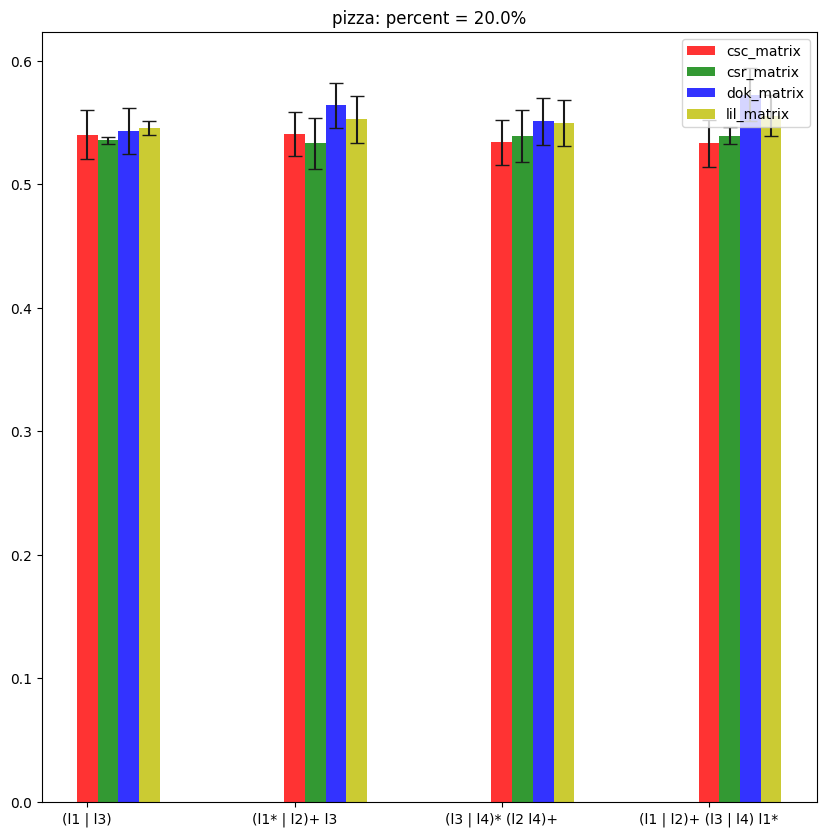

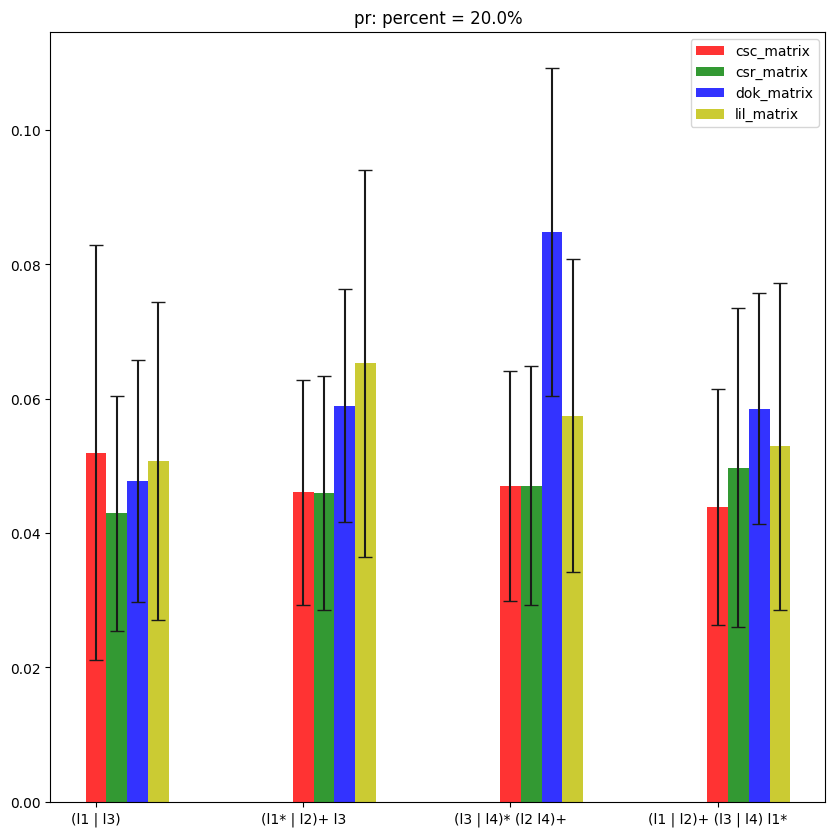

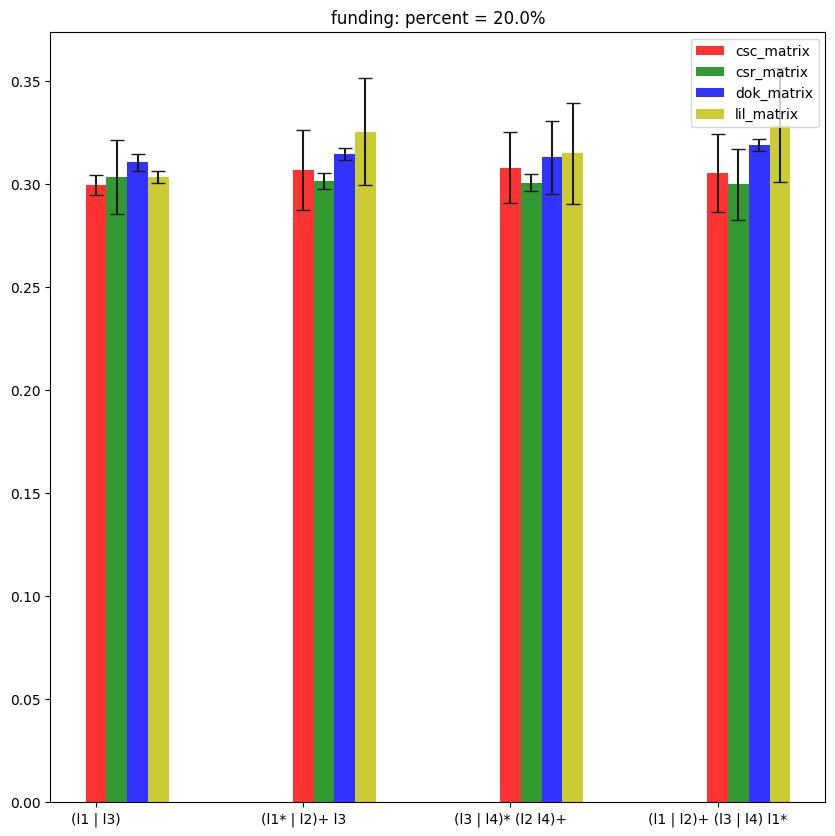

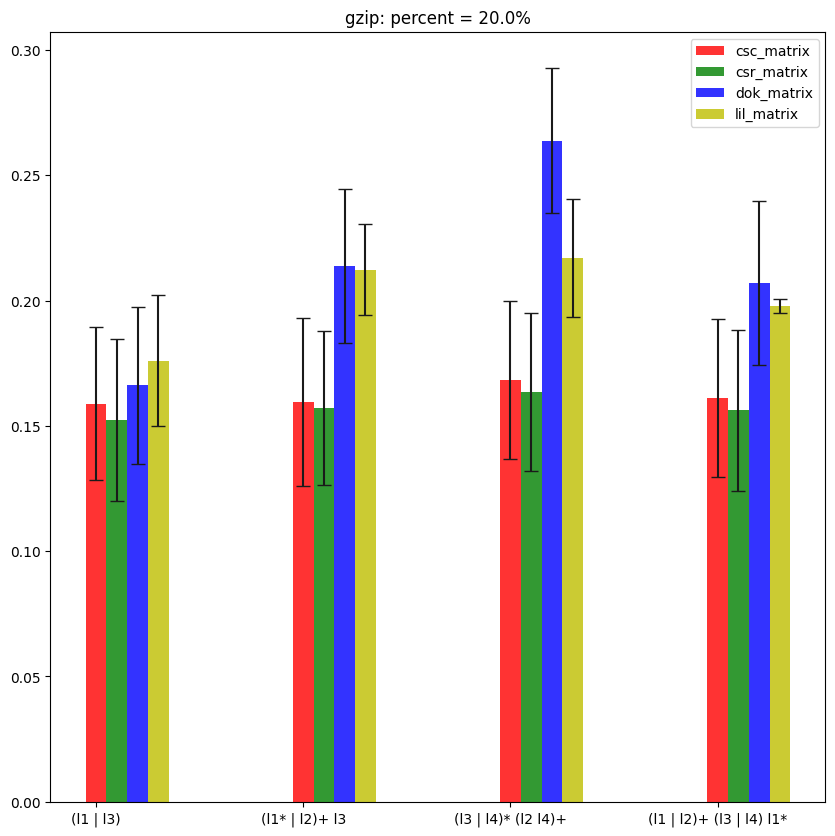

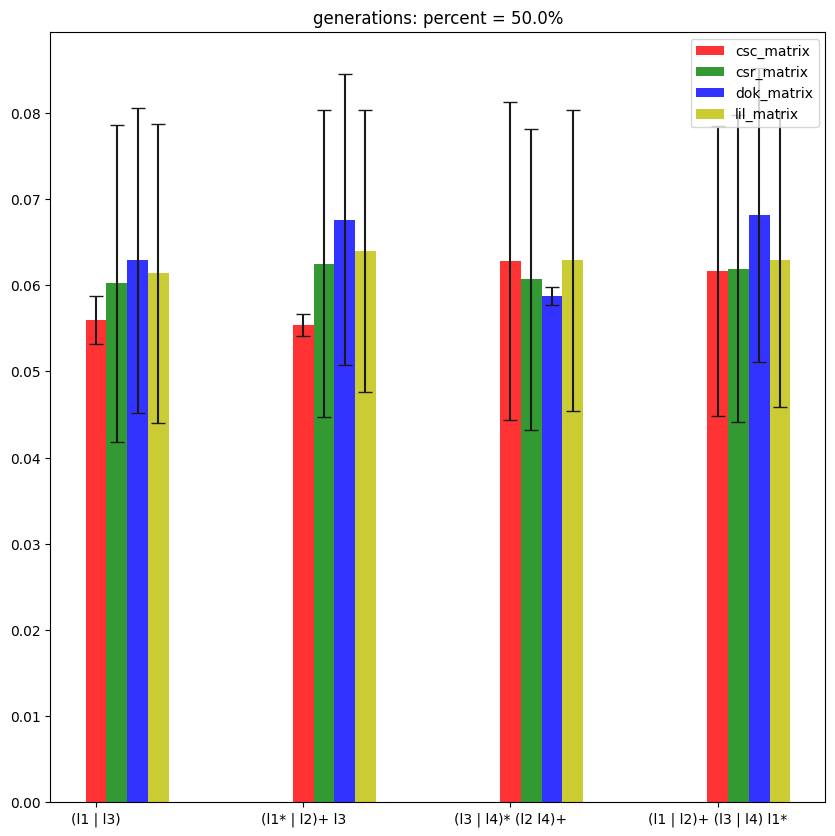

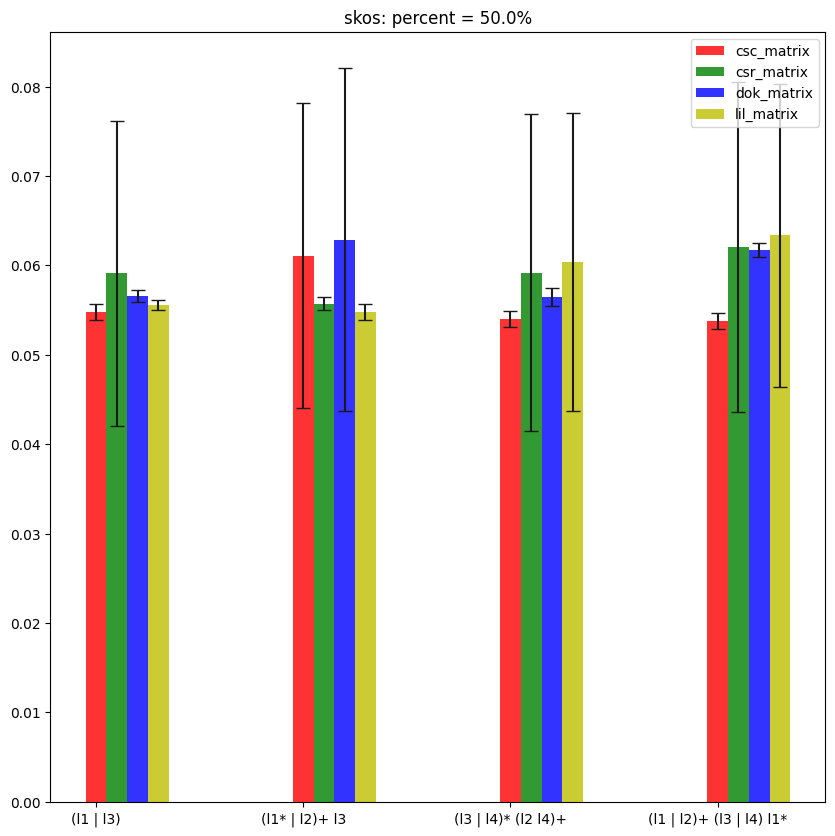

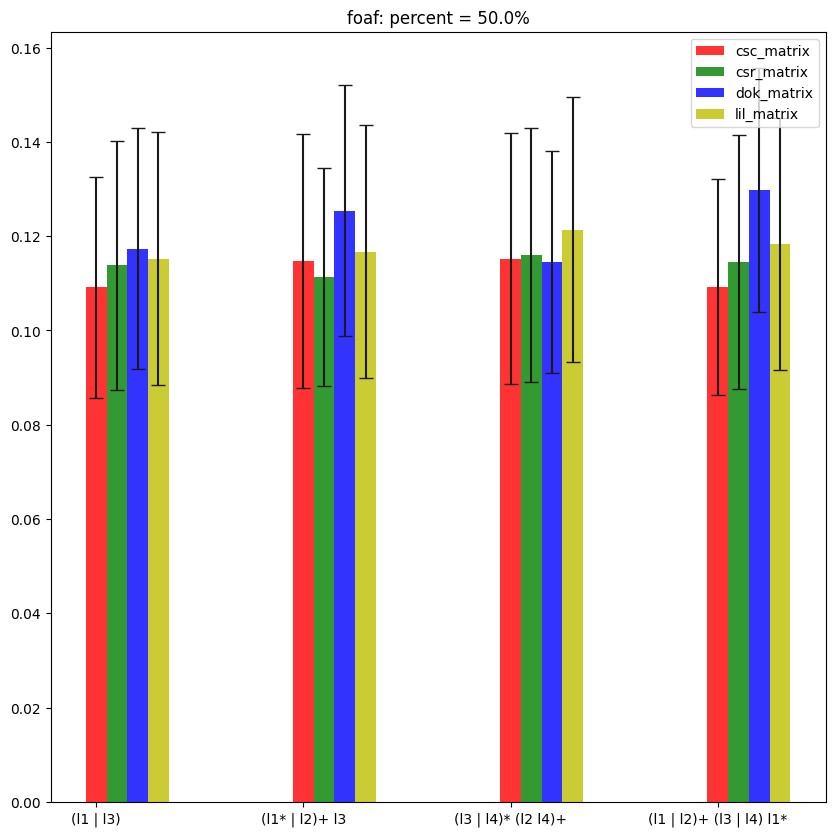

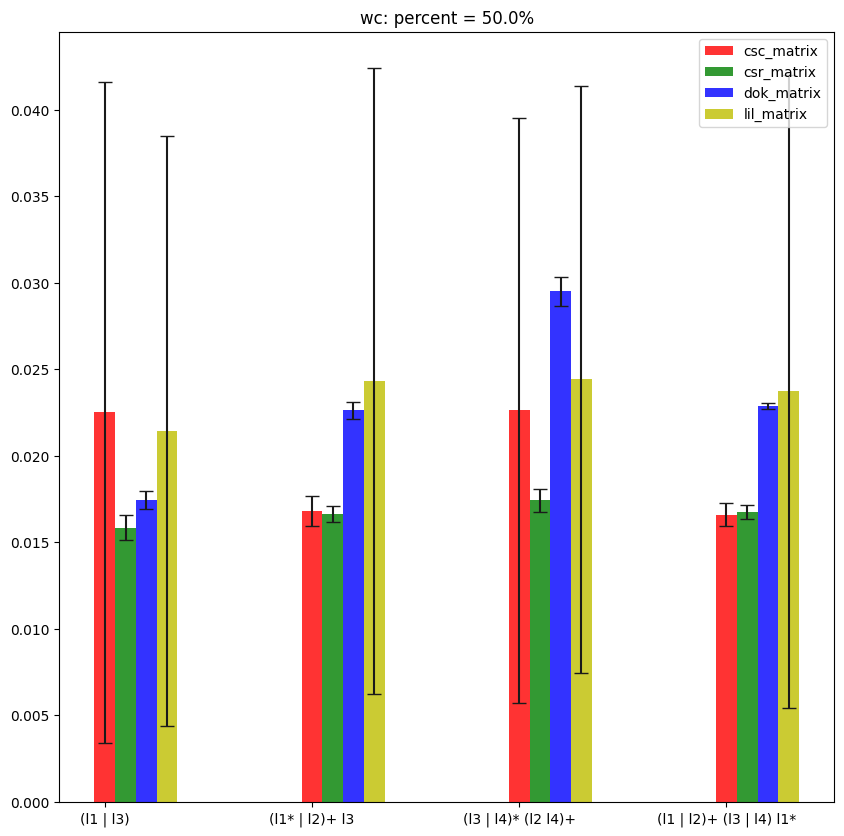

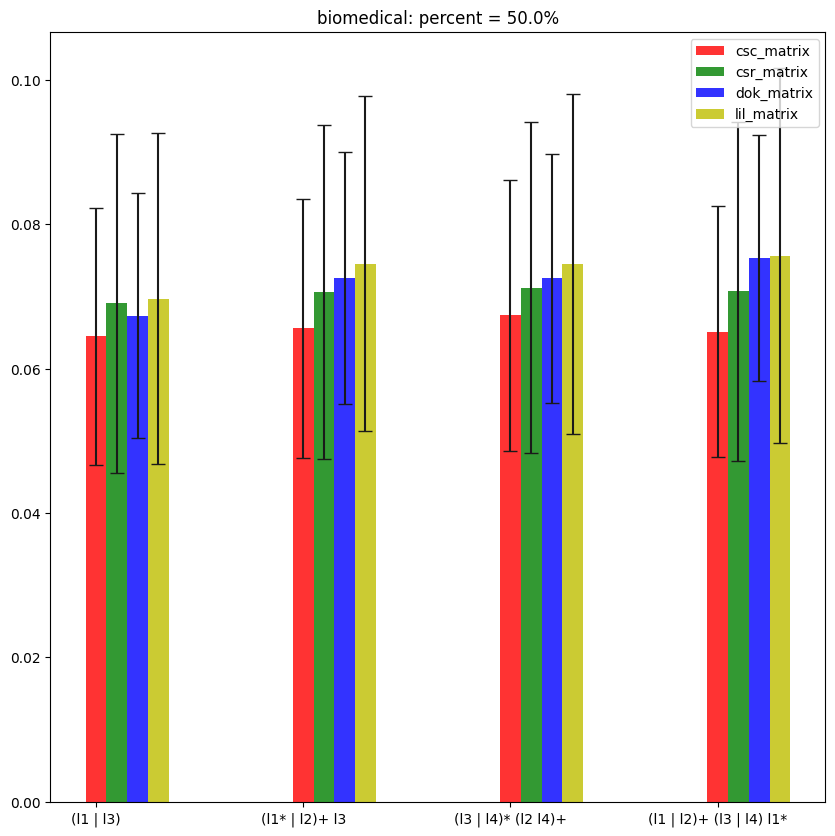

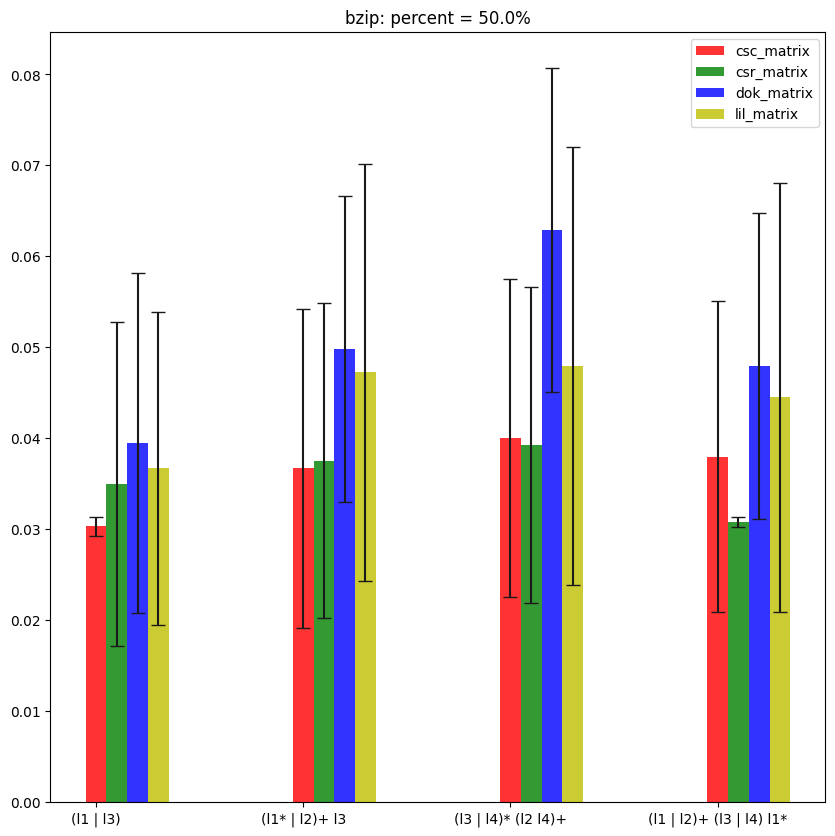

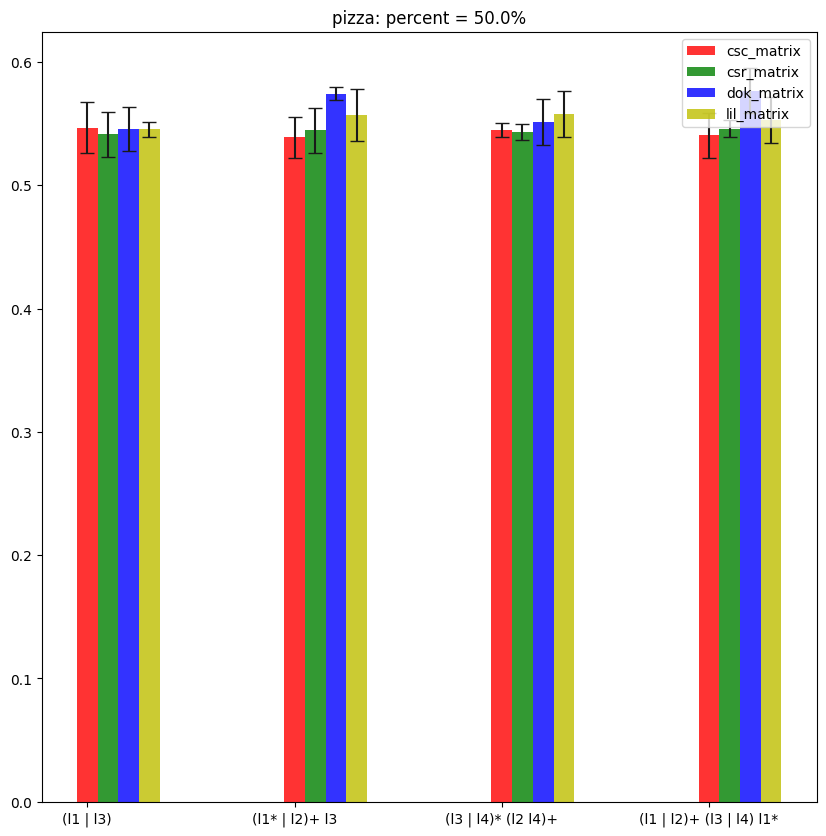

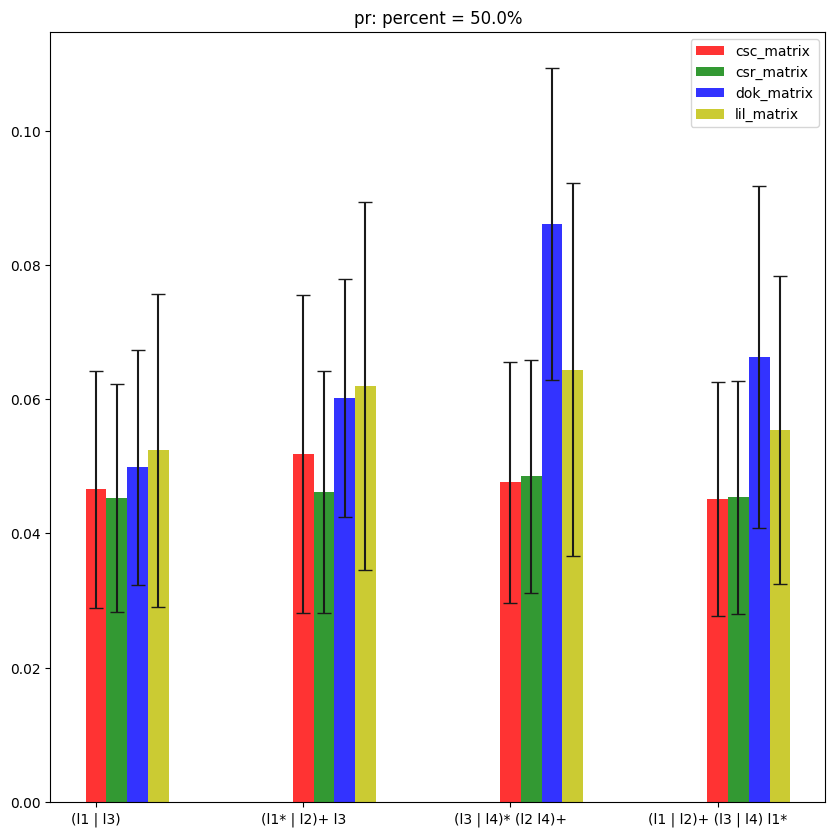

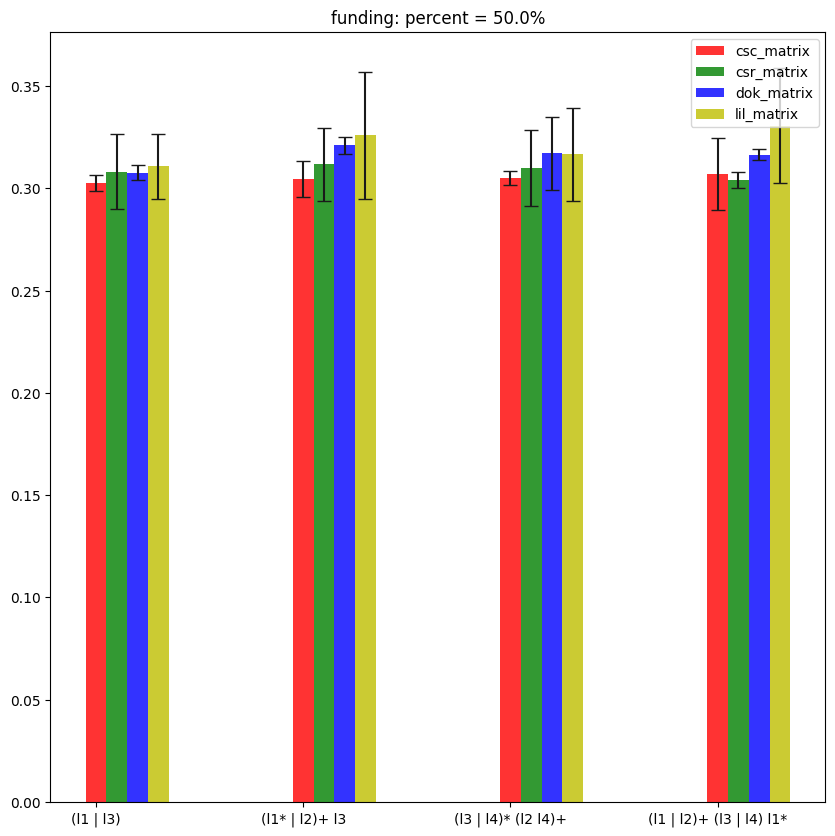

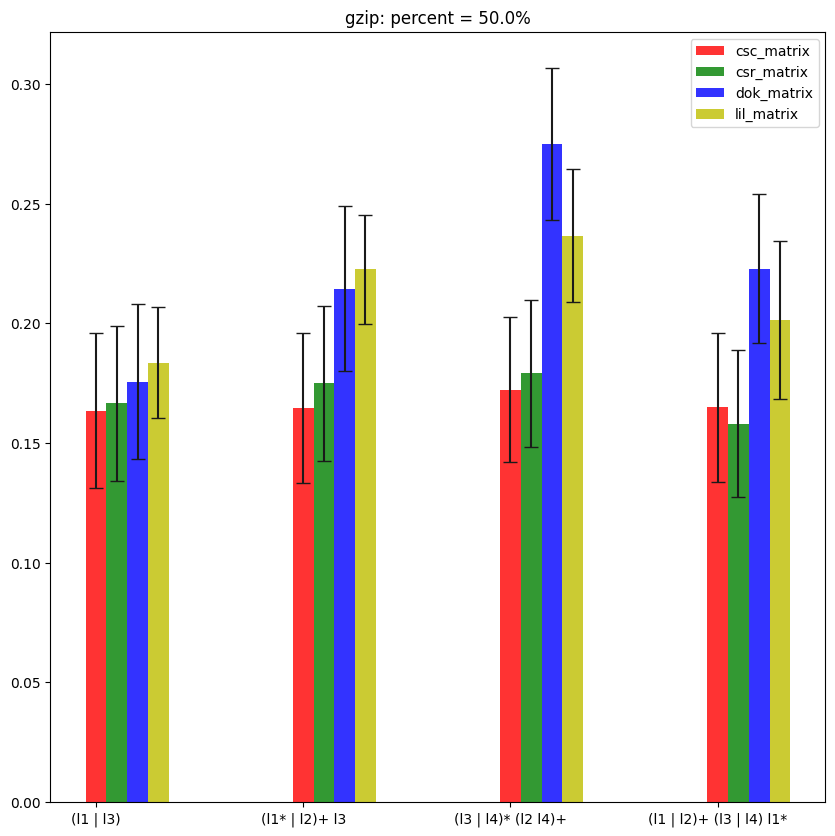

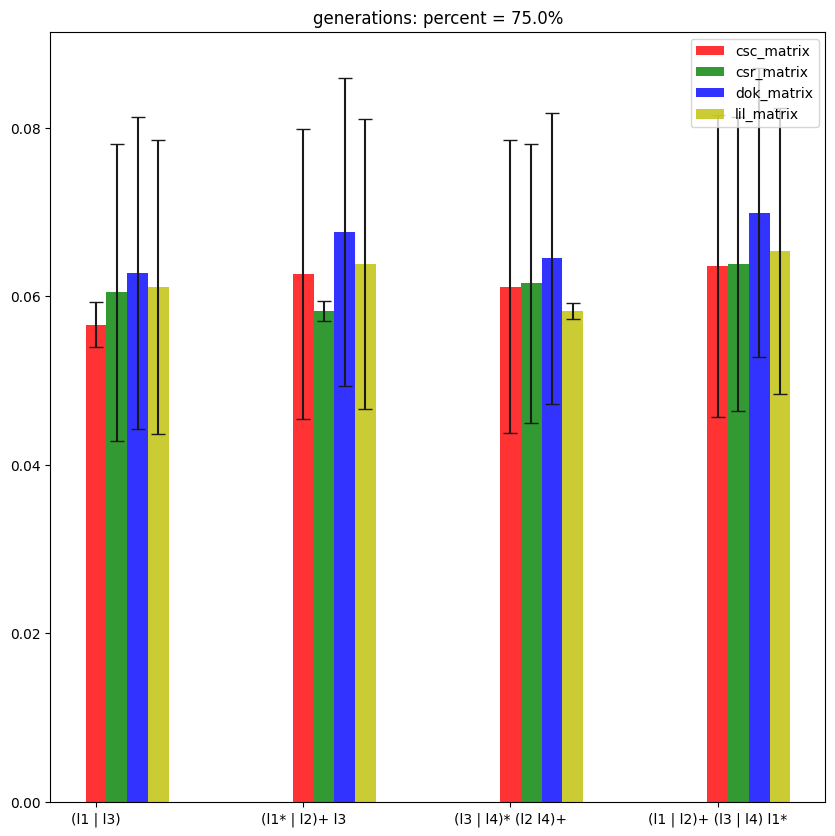

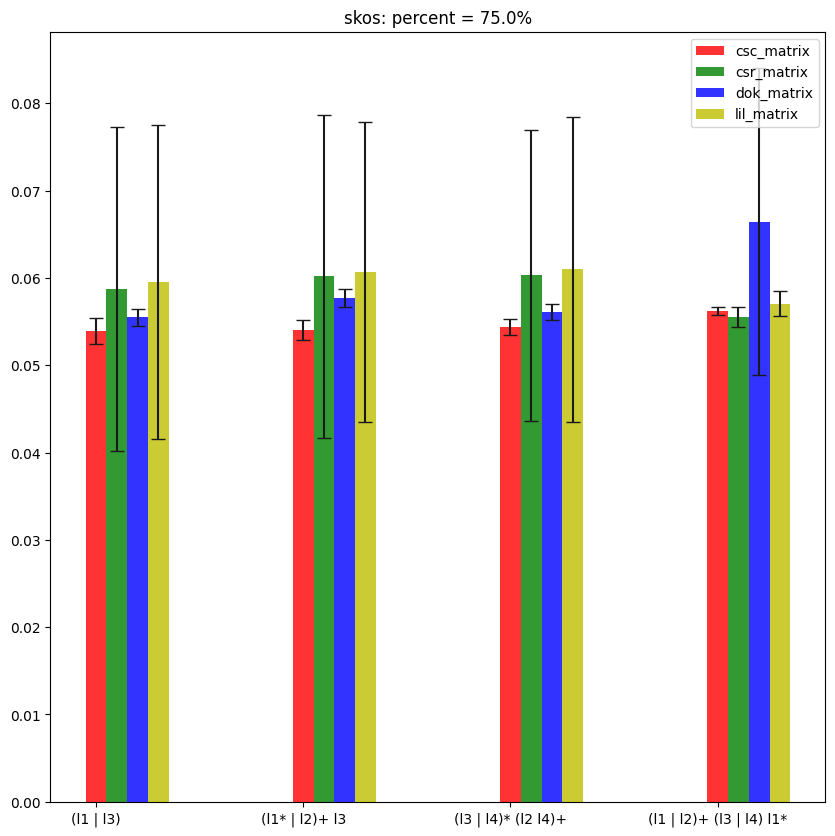

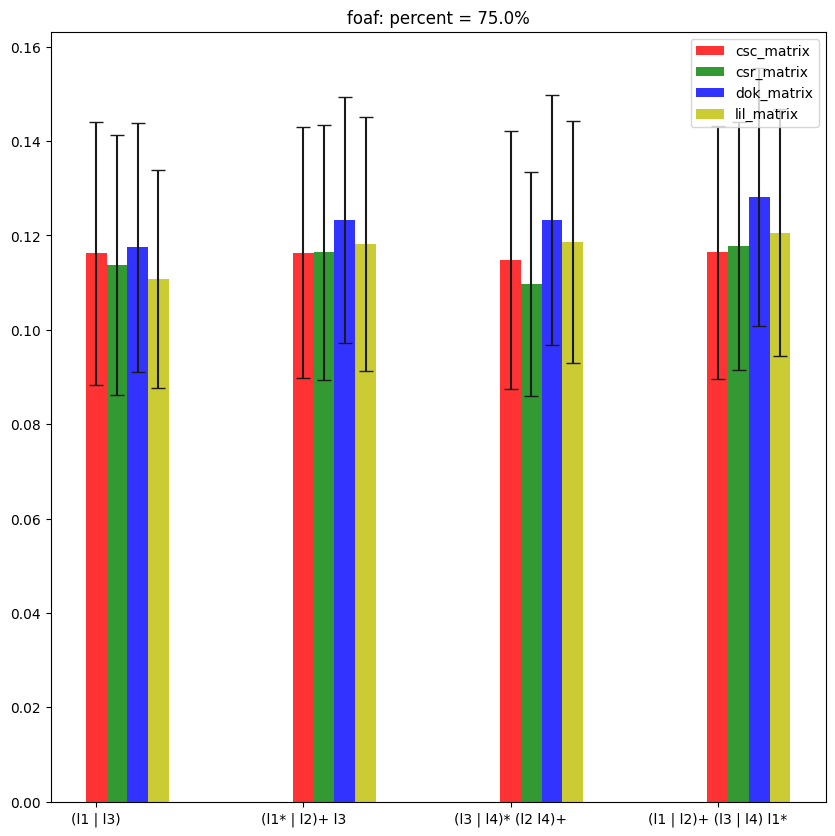

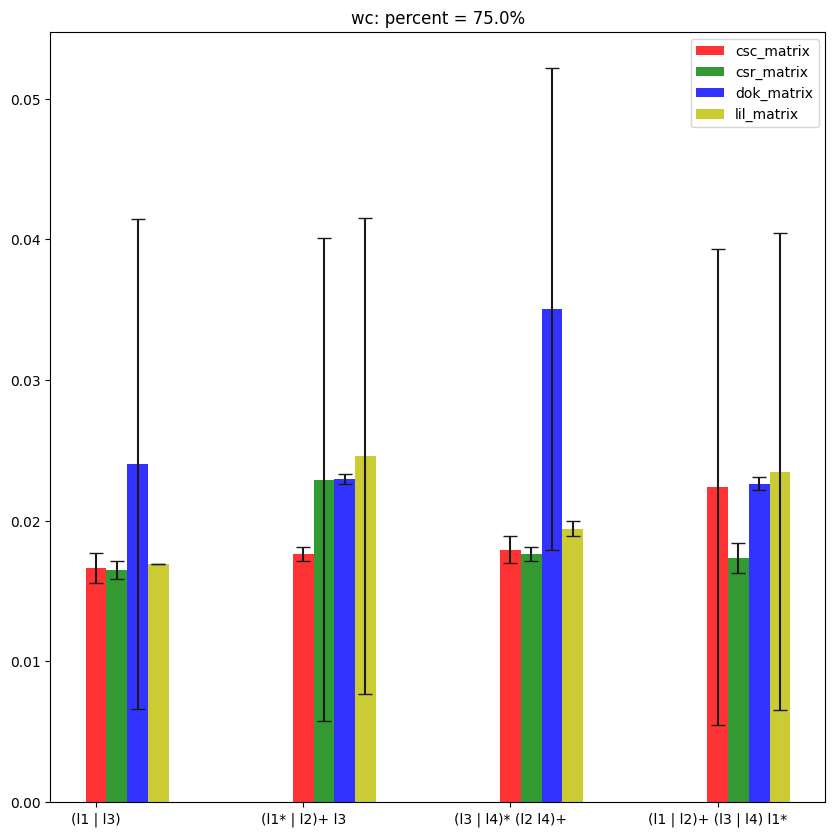

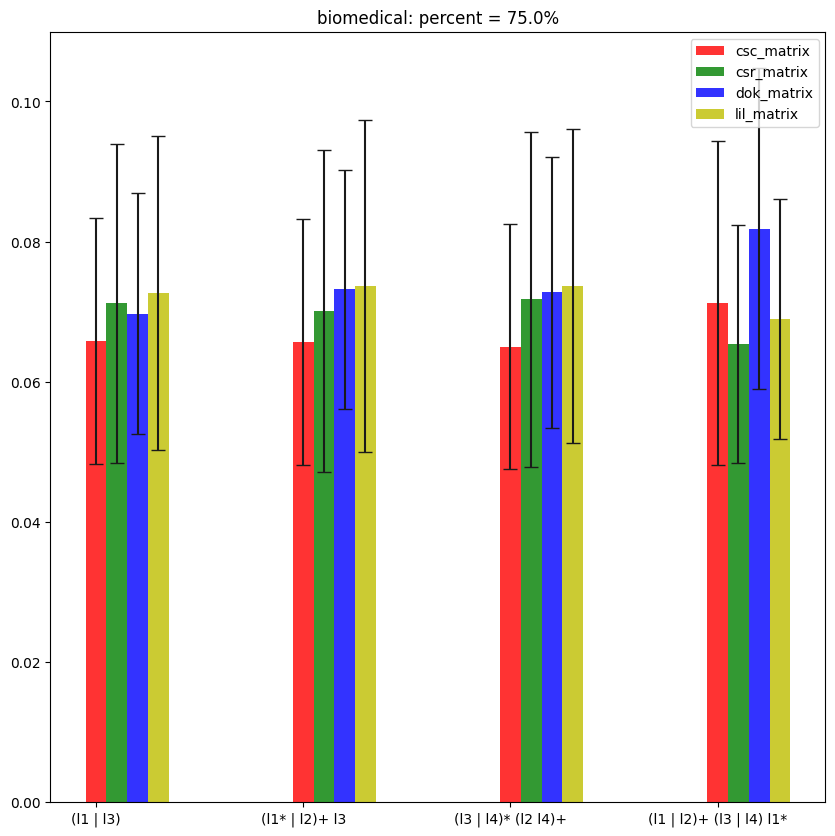

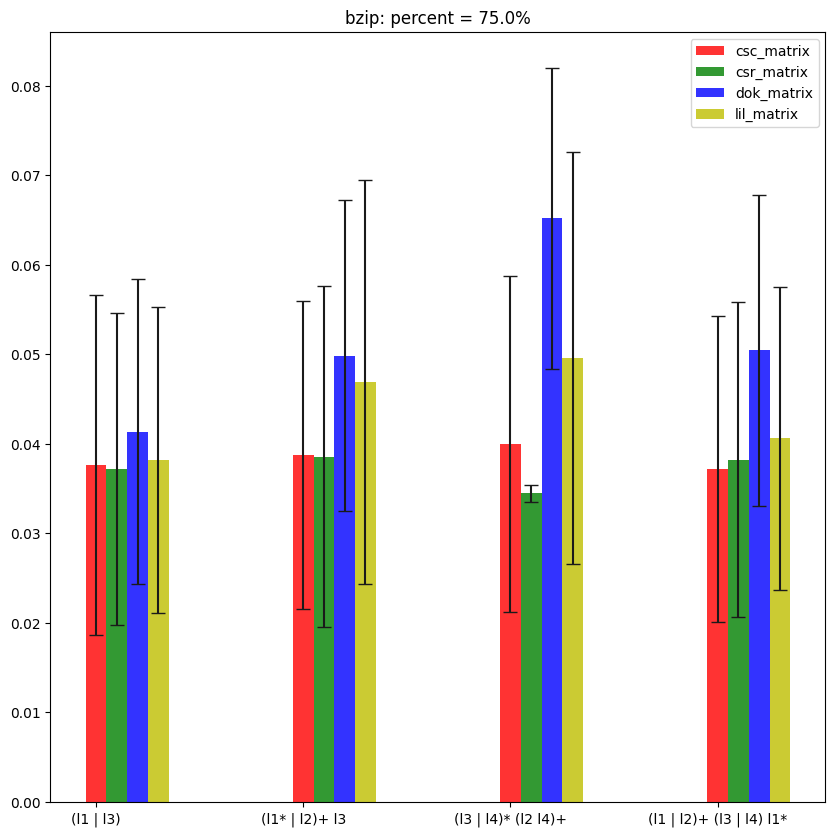

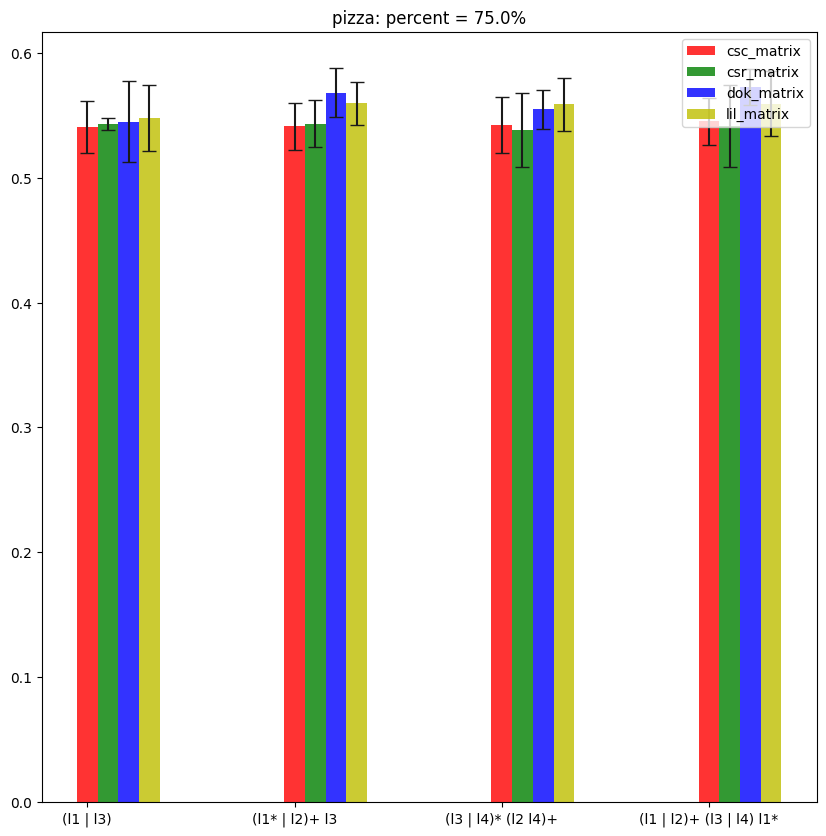

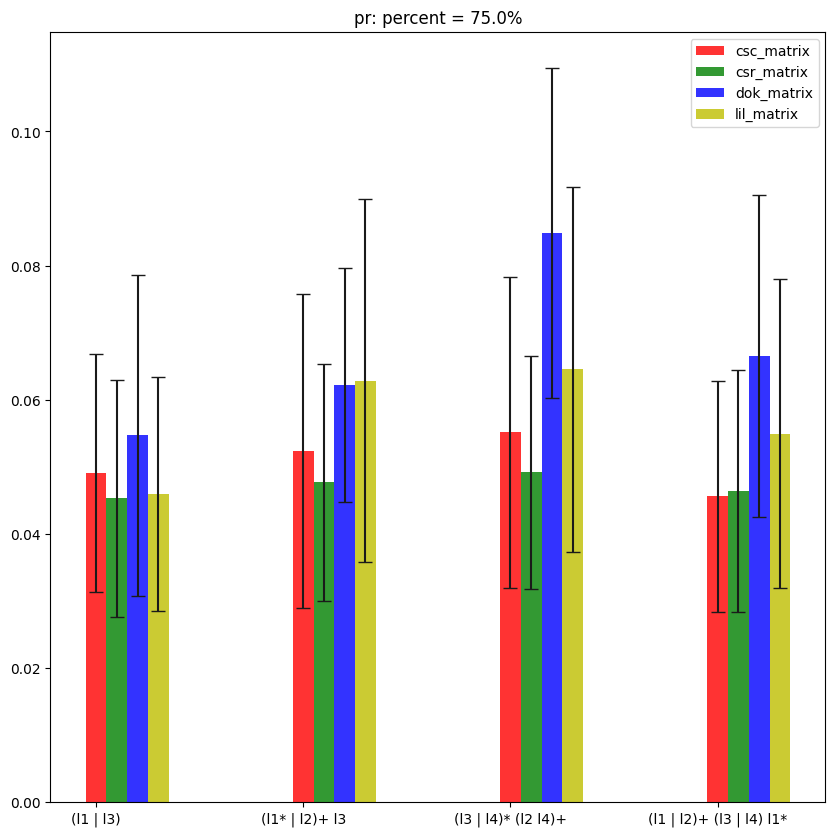

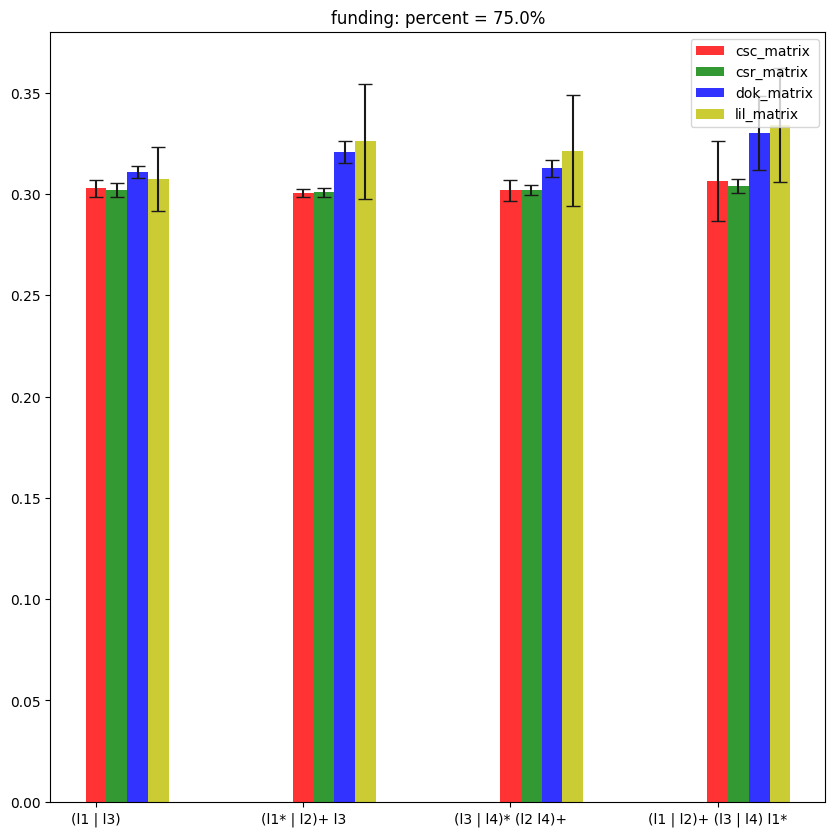

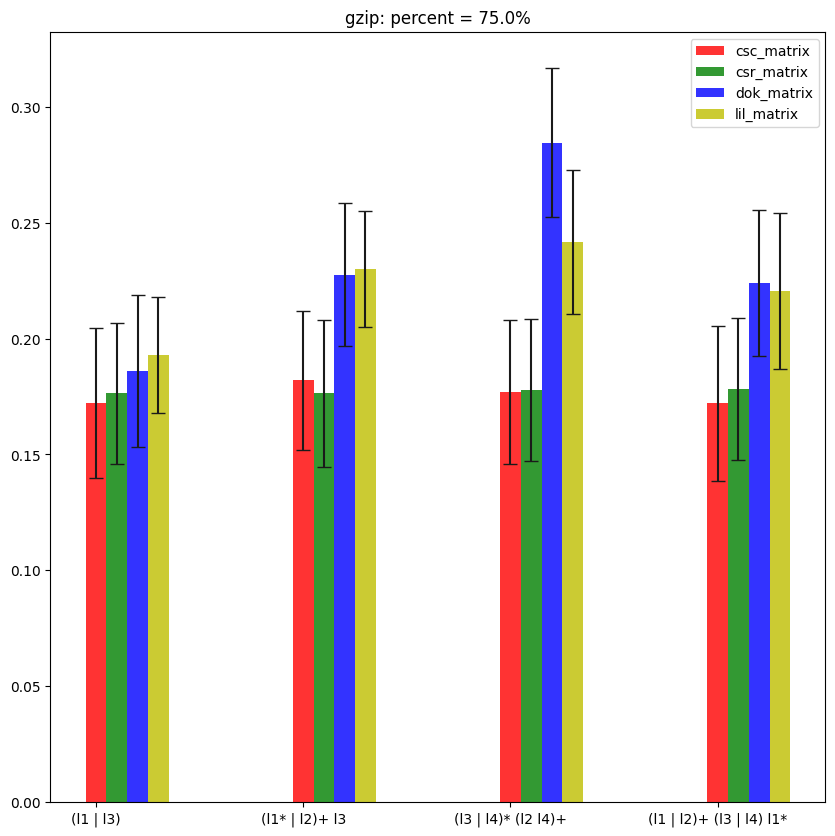

name percent  lil_matrix_time  lil_matrix_tstd  \
0           all_pair_tensor     100         0.156080         0.020080   
0              all_pair_bfs     100         0.169762         0.024241   
0  grouped_start_set_tensor    10.0         0.149138         0.018213   
0  grouped_start_set_tensor    20.0         0.152614         0.019816   
0  grouped_start_set_tensor    50.0         0.151832         0.019391   
0  grouped_start_set_tensor    75.0         0.155173         0.021394   
0     grouped_start_set_bfs    10.0         0.169616         0.024403   
0     grouped_start_set_bfs    20.0         0.171766         0.023978   
0     grouped_start_set_bfs    50.0         0.170588         0.024580   
0     grouped_start_set_bfs    75.0         0.171966         0.025355   
0   single_start_set_tensor    10.0         0.148940         0.018669   
0   single_start_set_tensor    20.0         0.150241         0.019107   
0   single_start_set_tensor    50.0         0.152412         0.020895   
0   single_start_set_tensor    75.0         0.153289         0.020204   

   dok_matrix_time  dok_matrix_tstd  csr_matrix_time  csr_matrix_tstd  \
0         0.162223         0.020487         0.145940         0.017727   
0         0.176780         0.018813         0.295483         0.017593   
0         0.153946         0.018673         0.140217         0.016705   
0         0.155978         0.019003         0.141444         0.017250   
0         0.156163         0.017040         0.140490         0.015512   
0         0.157555         0.015015         0.143415         0.017208   
0         0.158924         0.016301         0.230129         0.017819   
0         0.164964         0.014817         0.236317         0.016748   
0         0.170292         0.015471         0.257589         0.018012   
0         0.175912         0.016815         0.275929         0.016376   
0         0.154547         0.017192         0.139062         0.017393   
0         0.153799         0.015724         0.139677         0.017072   
0         0.155576         0.015464         0.142532         0.017050   
0         0.157664         0.017721         0.142731         0.016633   

   csc_matrix_time  csc_matrix_tstd  
0         0.146700         0.018145  
0         0.305924         0.017422  
0         0.140410         0.018863  
0         0.142192         0.016911  
0         0.142694         0.018364  
0         0.142776         0.016112  
0         0.230515         0.016145  
0         0.239835         0.017437  
0         0.263892         0.018697  
0         0.283657         0.015475  
0         0.141306         0.016944  
0         0.139904         0.016358  
0         0.141029         0.015446  
0         0.142697         0.016403

In [31]:
for percent in percents:
    results = rpq_request_performance_check(percent=percent, rpq_type="tensor", is_single_mode=True)
    final_statistic = update_statistic("single_start_set_tensor", percent, results, final_statistic)
final_statistic

### Алгоритм BFS

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


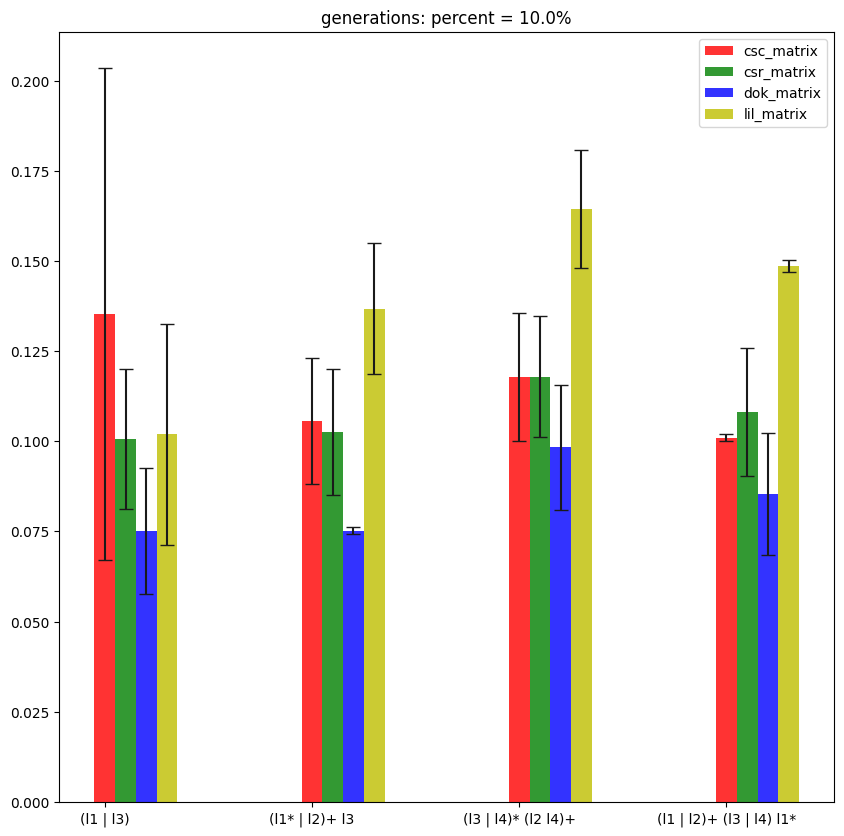

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


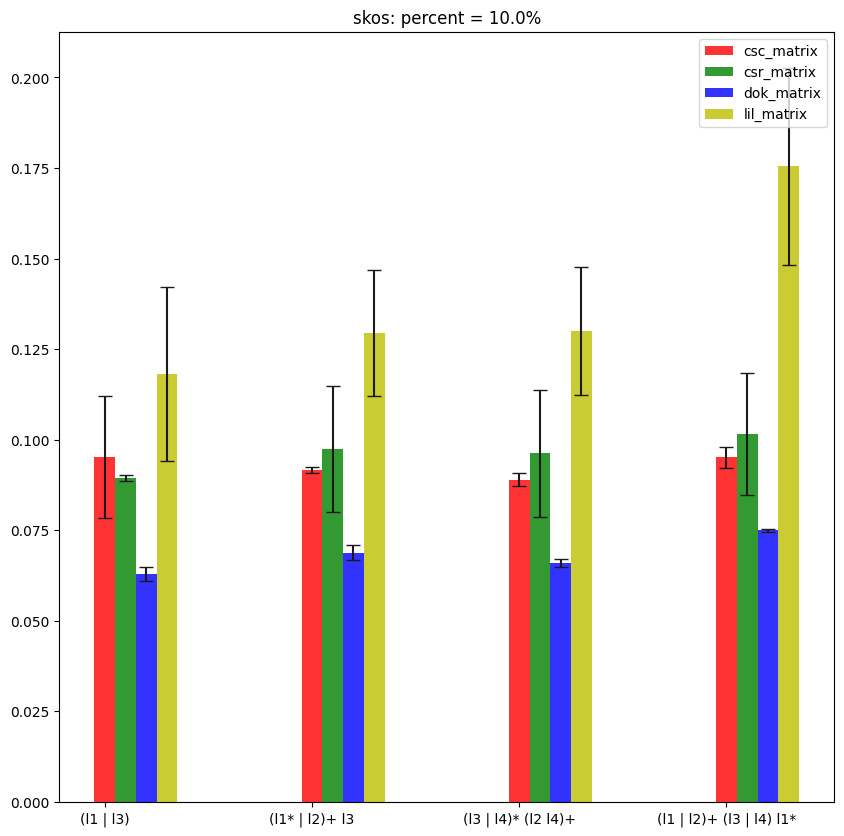

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


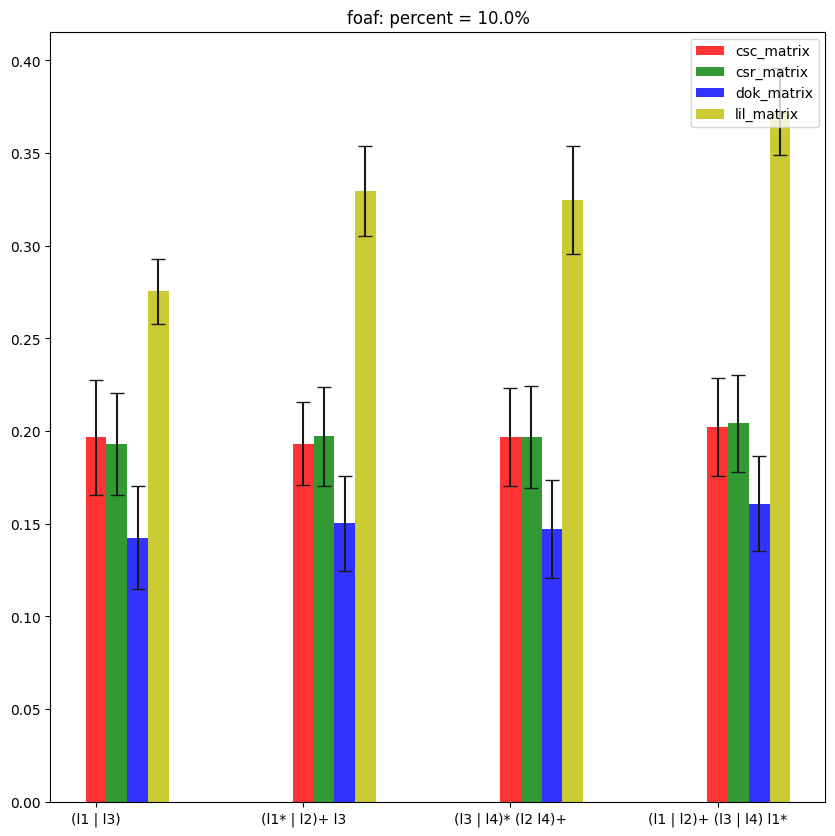

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


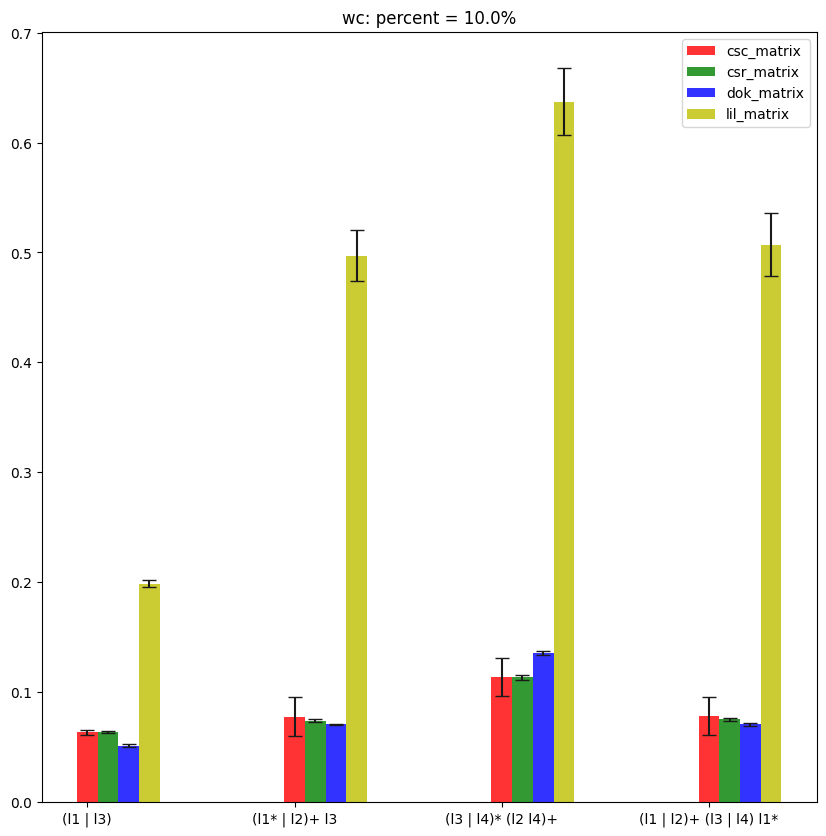

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


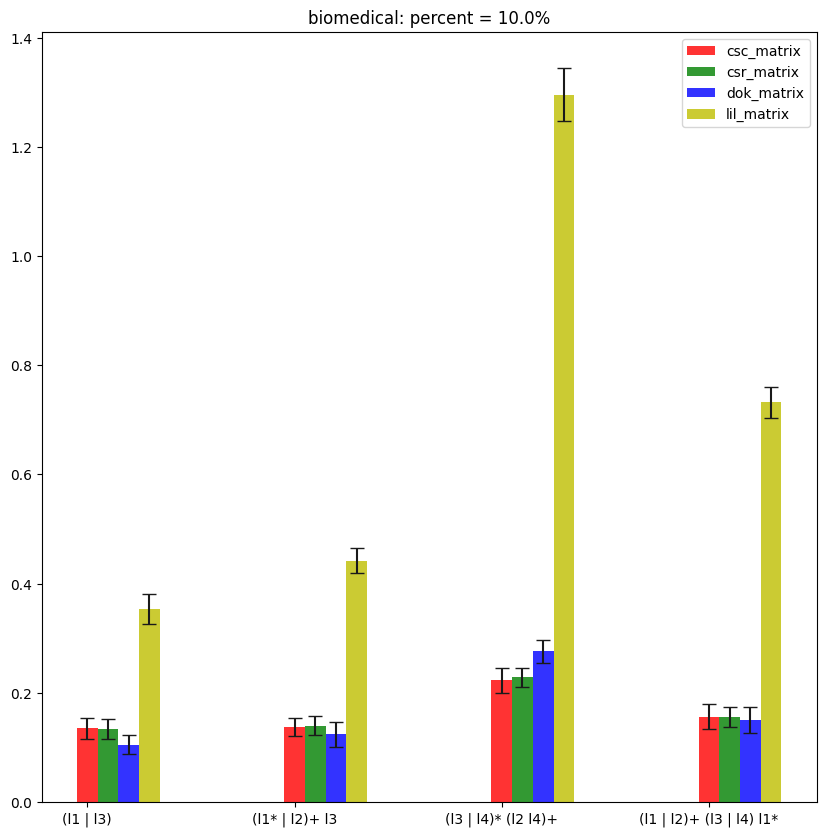

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


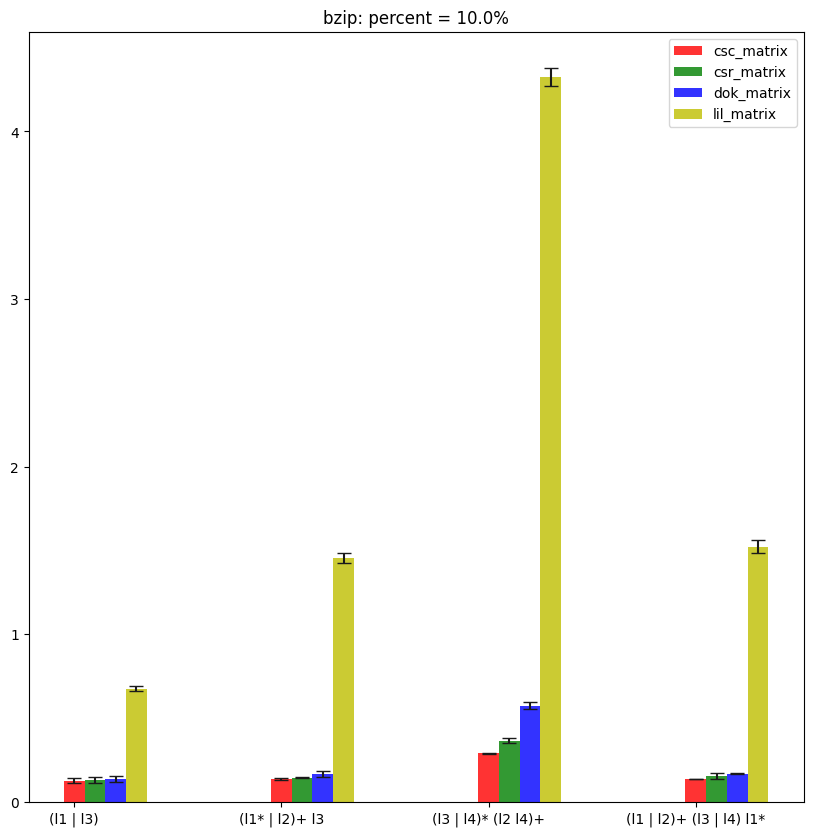

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


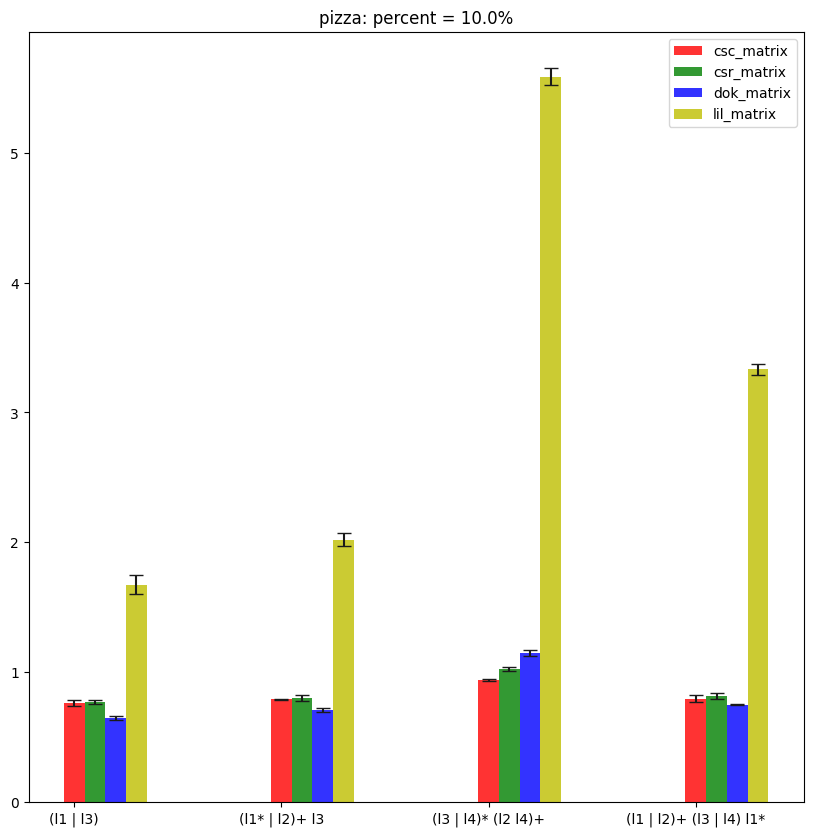

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


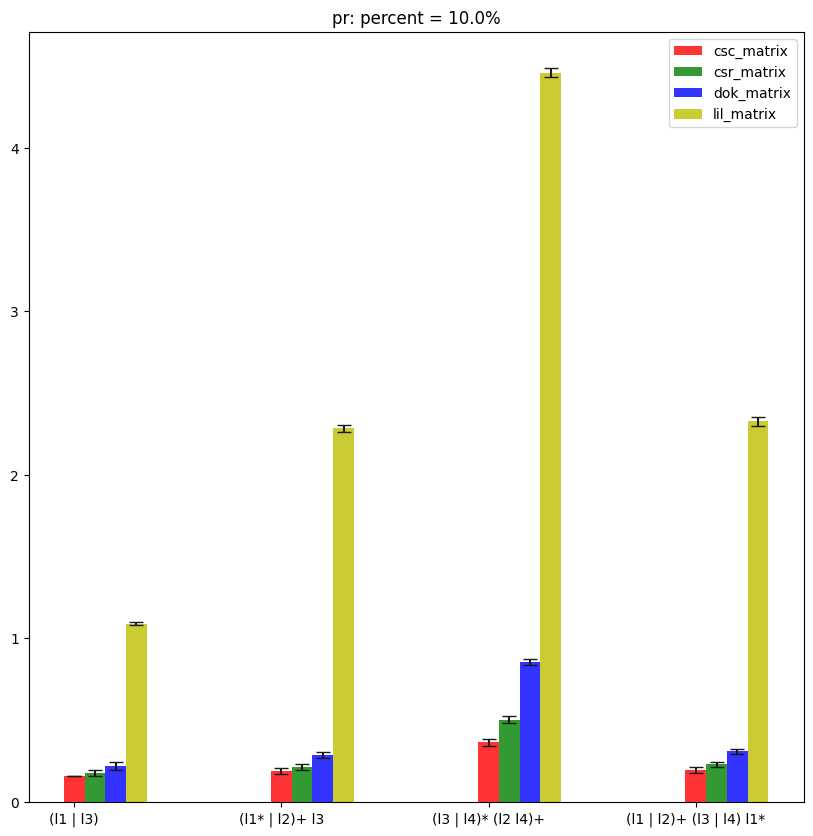

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


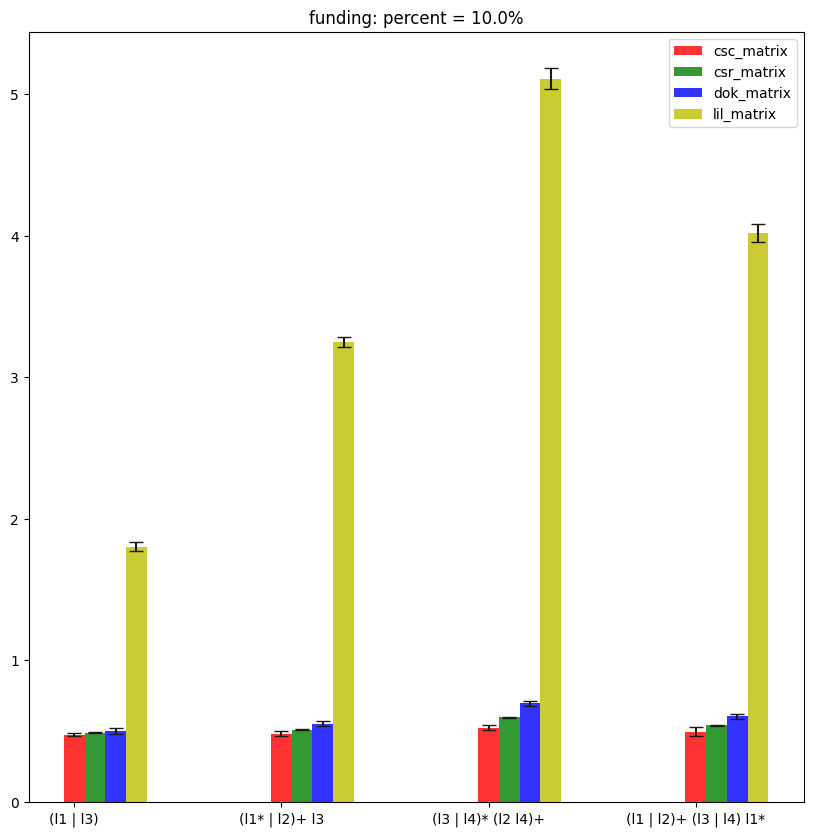

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


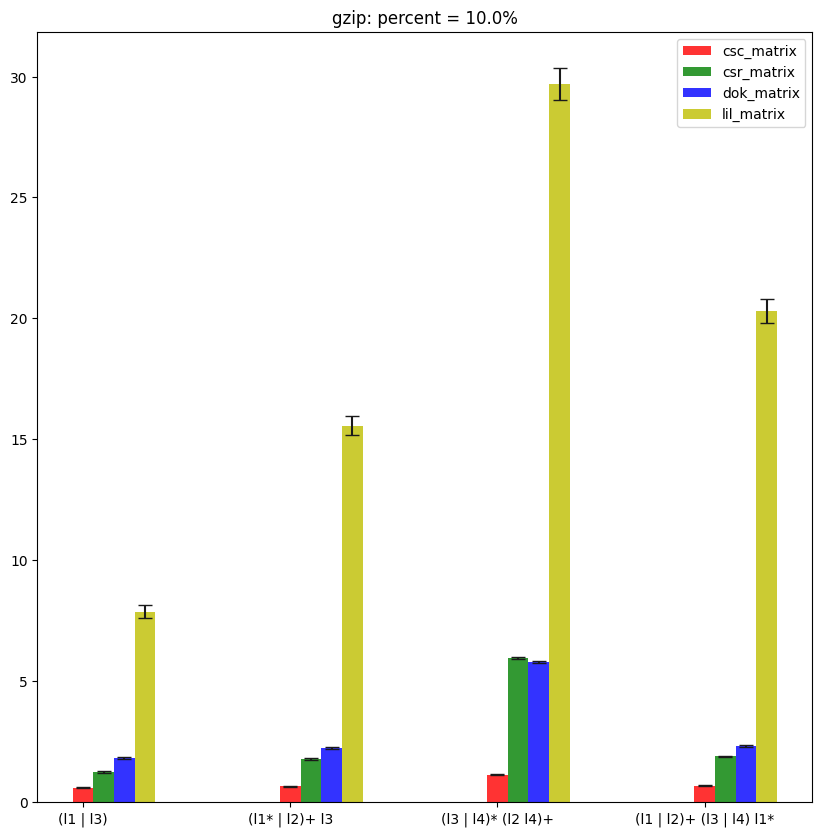

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


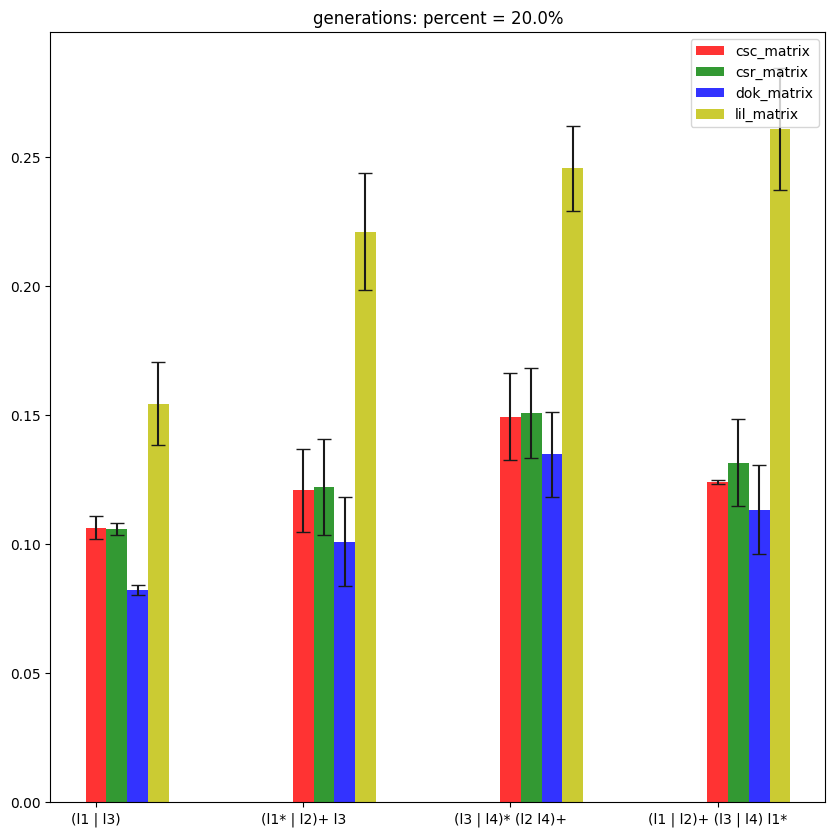

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


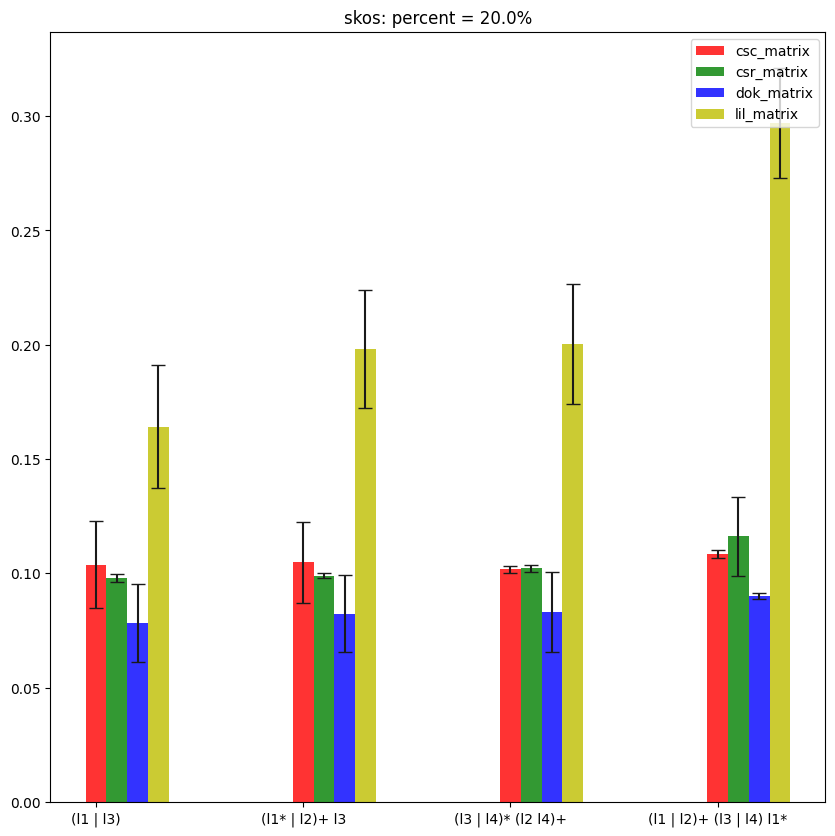

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


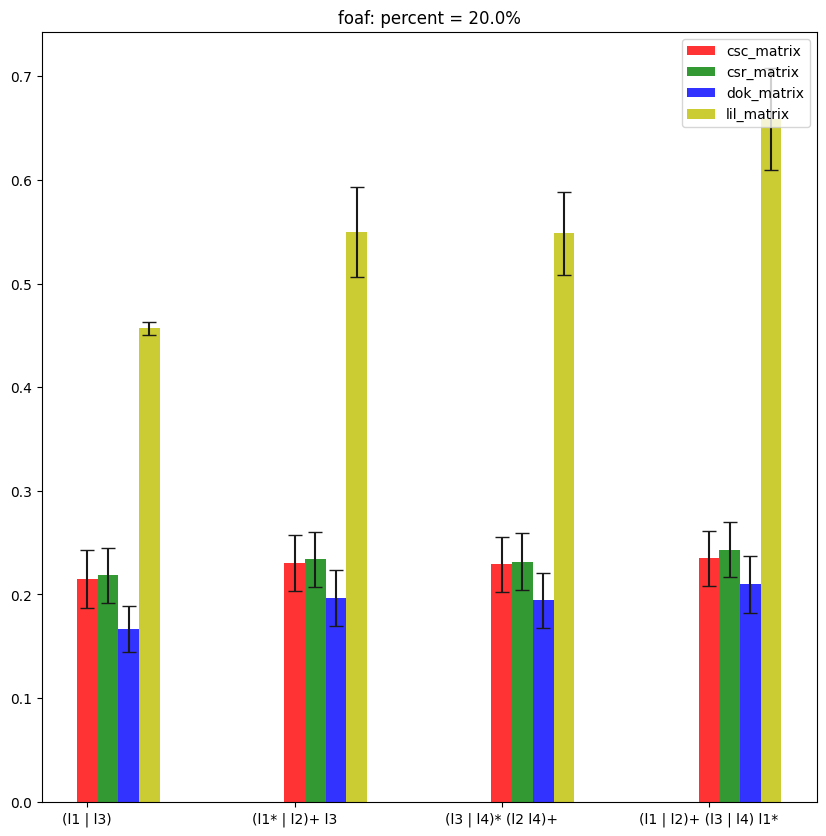

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


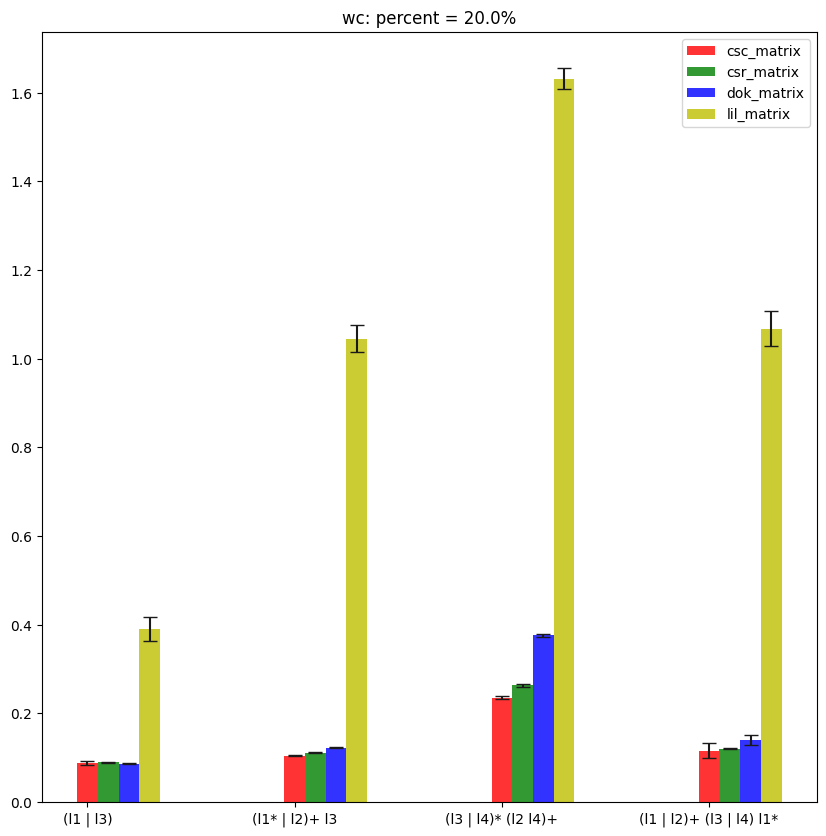

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


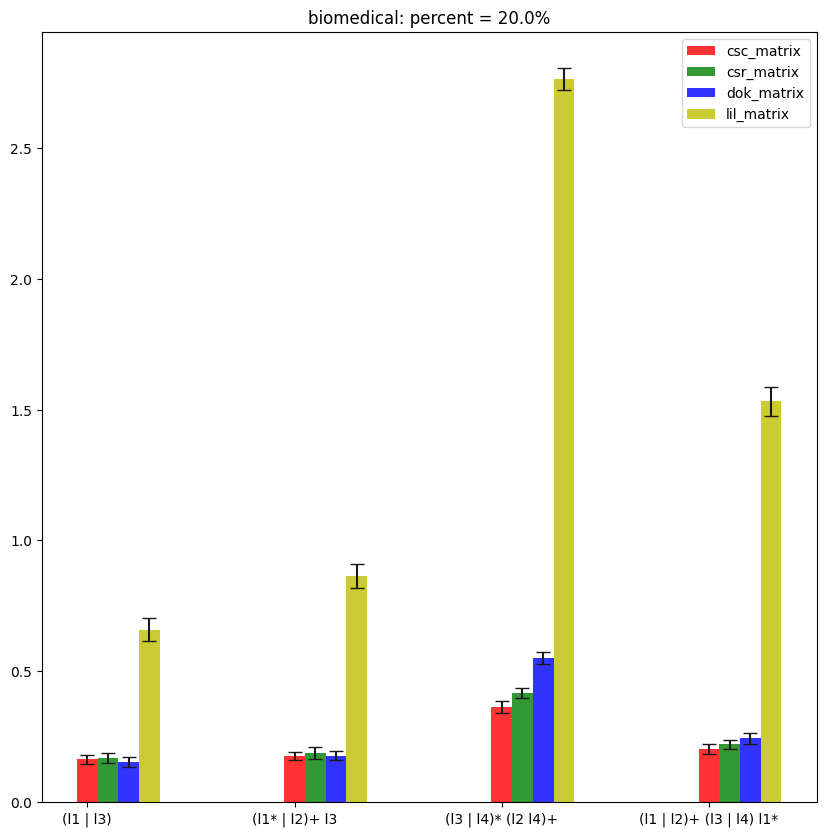

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


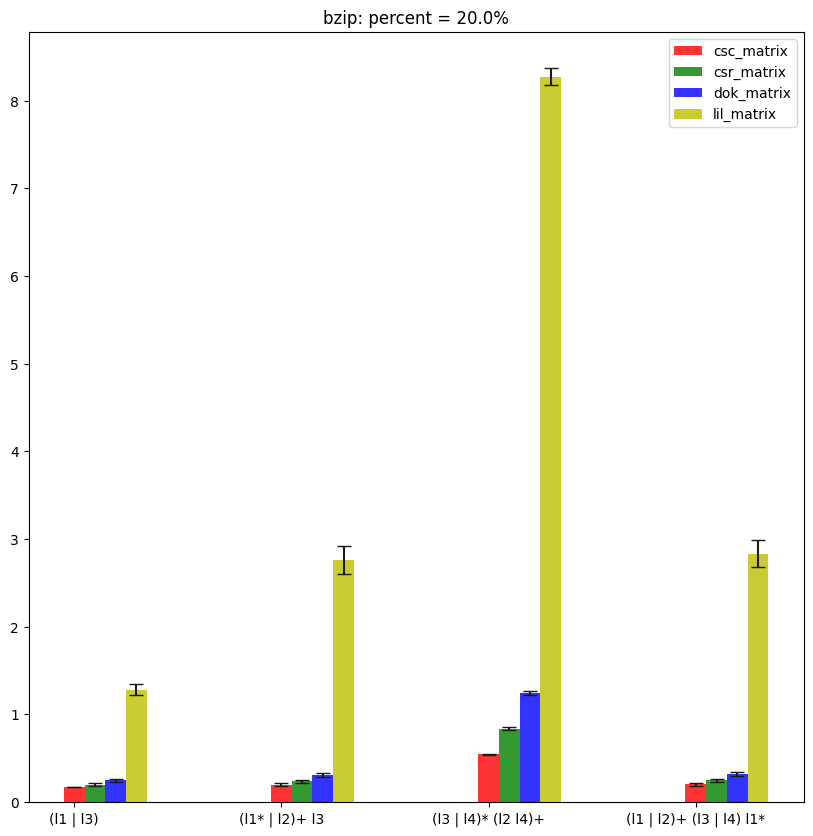

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


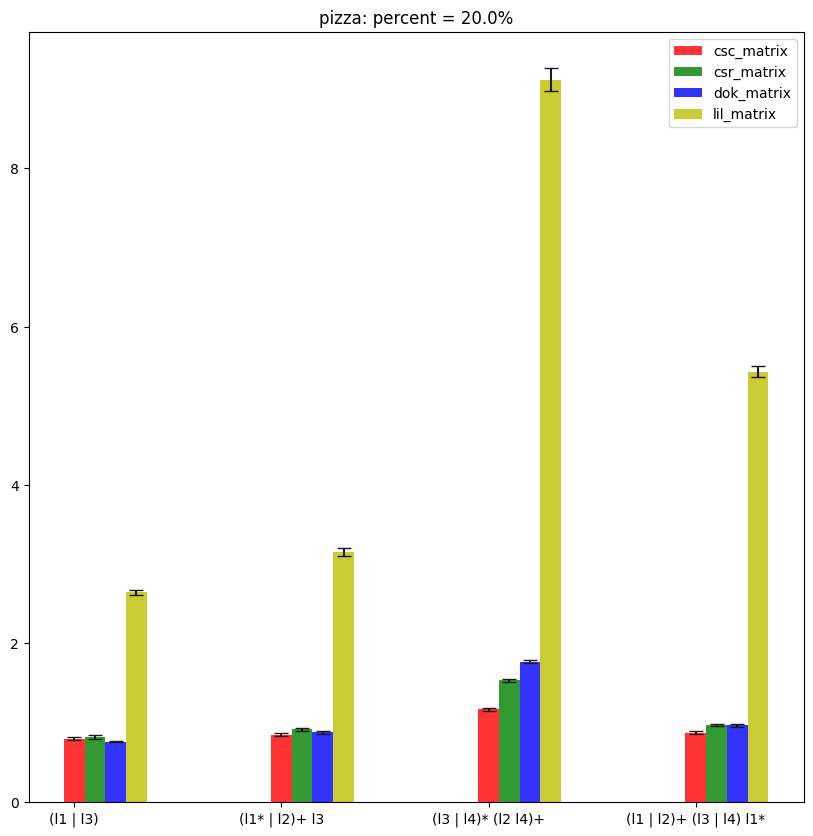

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


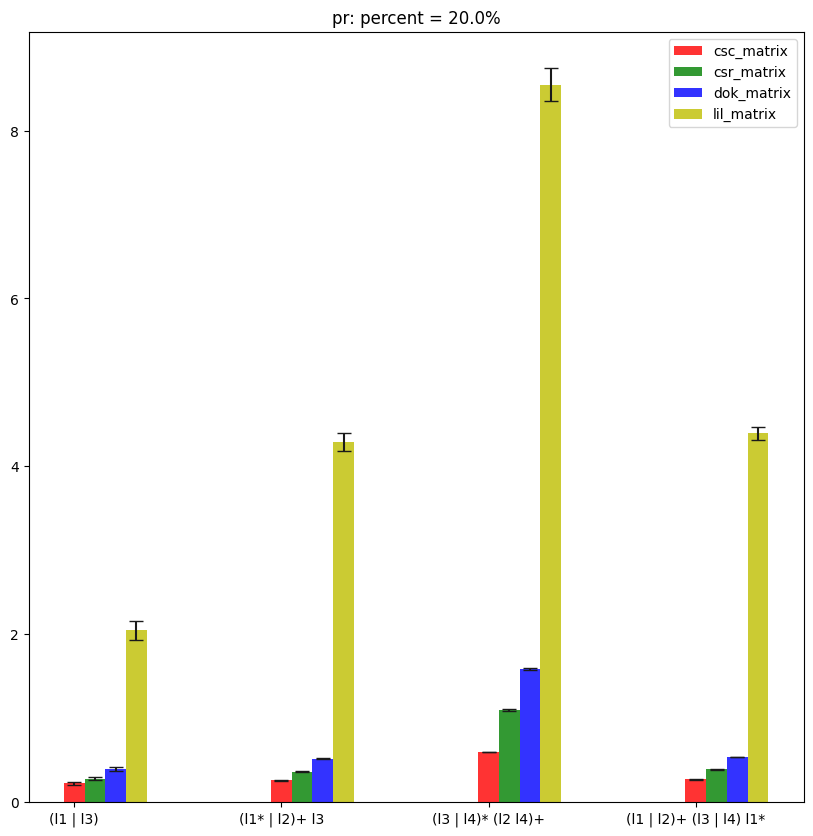

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


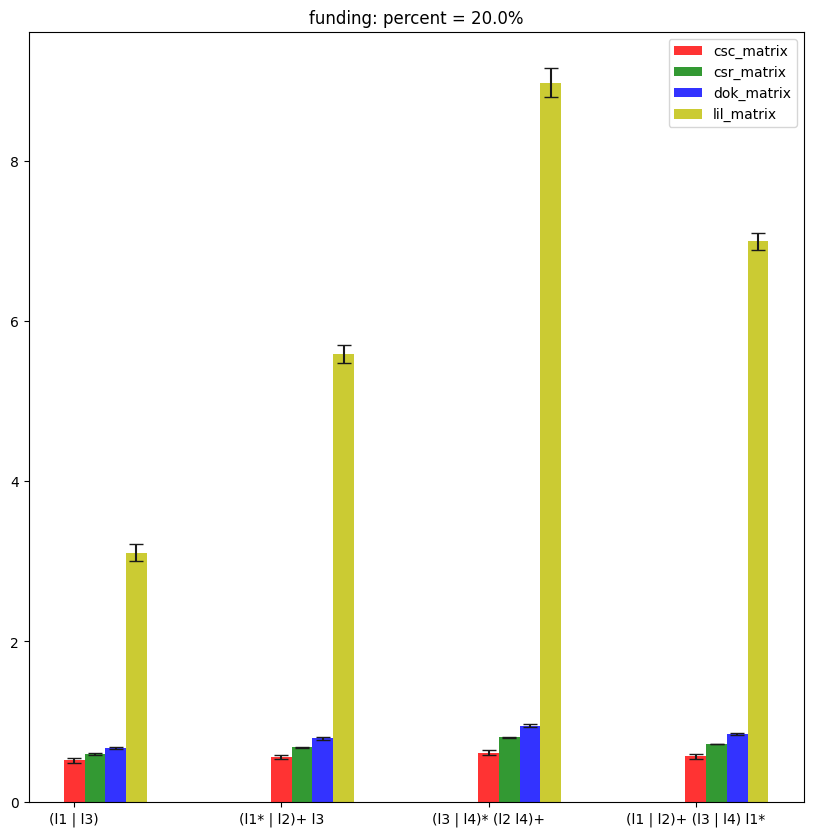

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


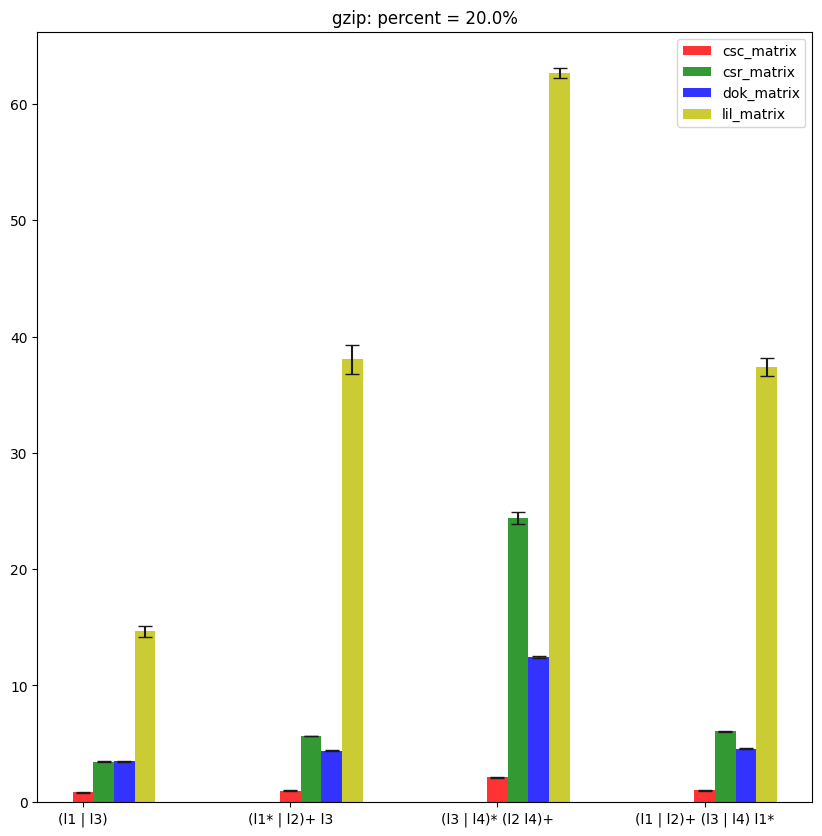

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


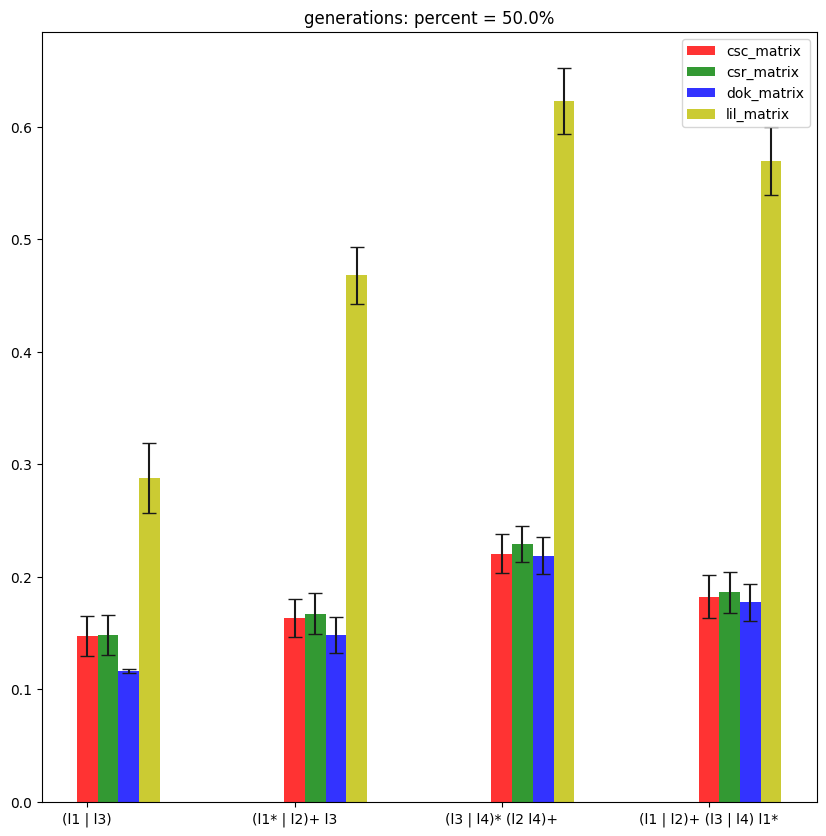

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


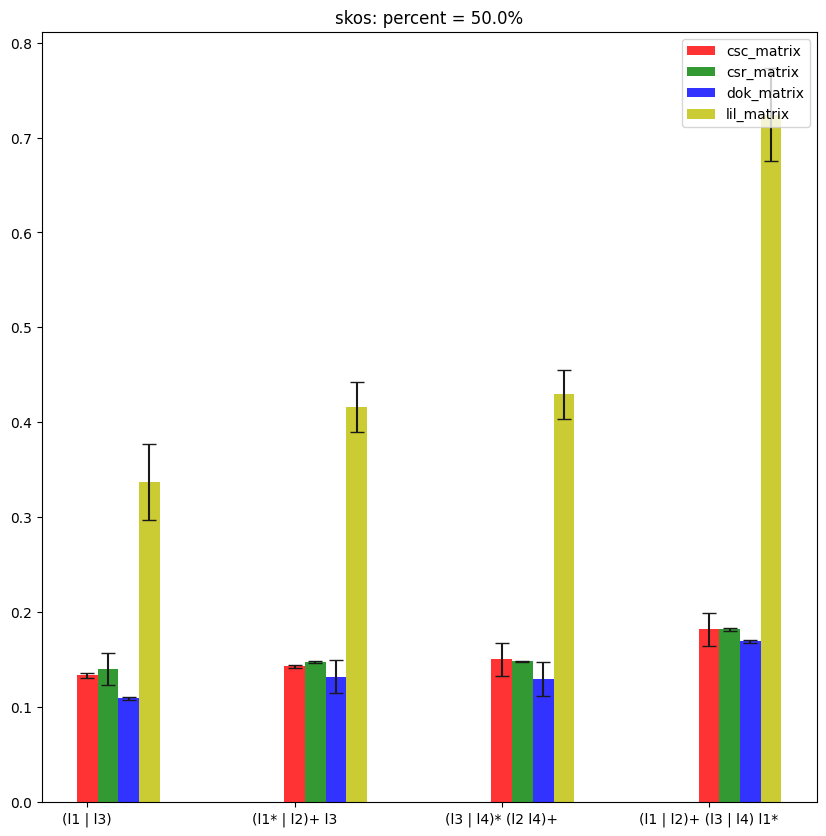

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


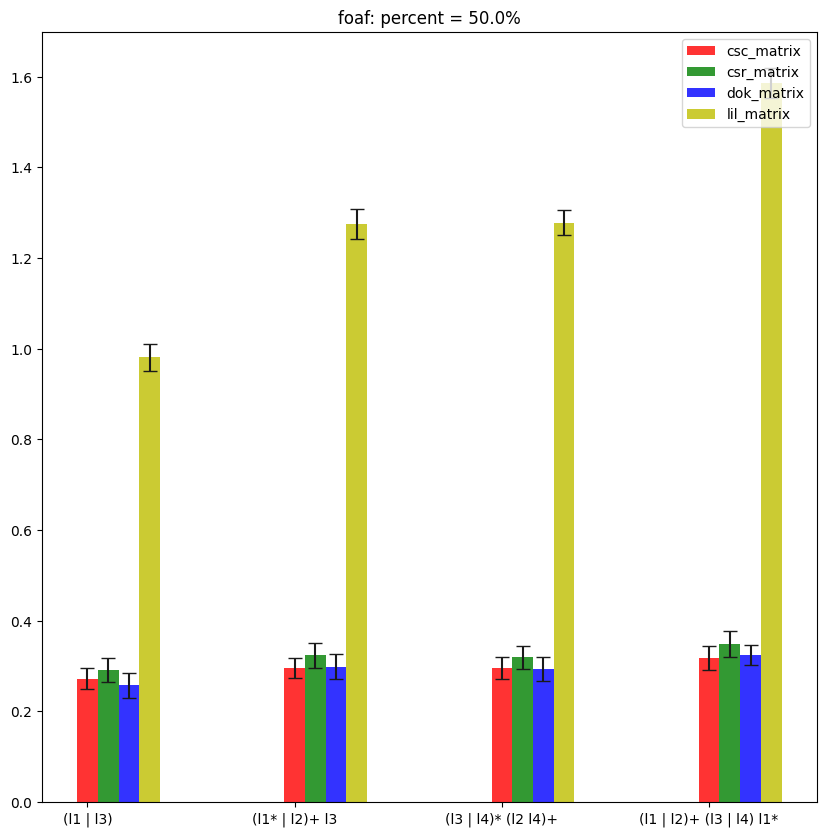

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


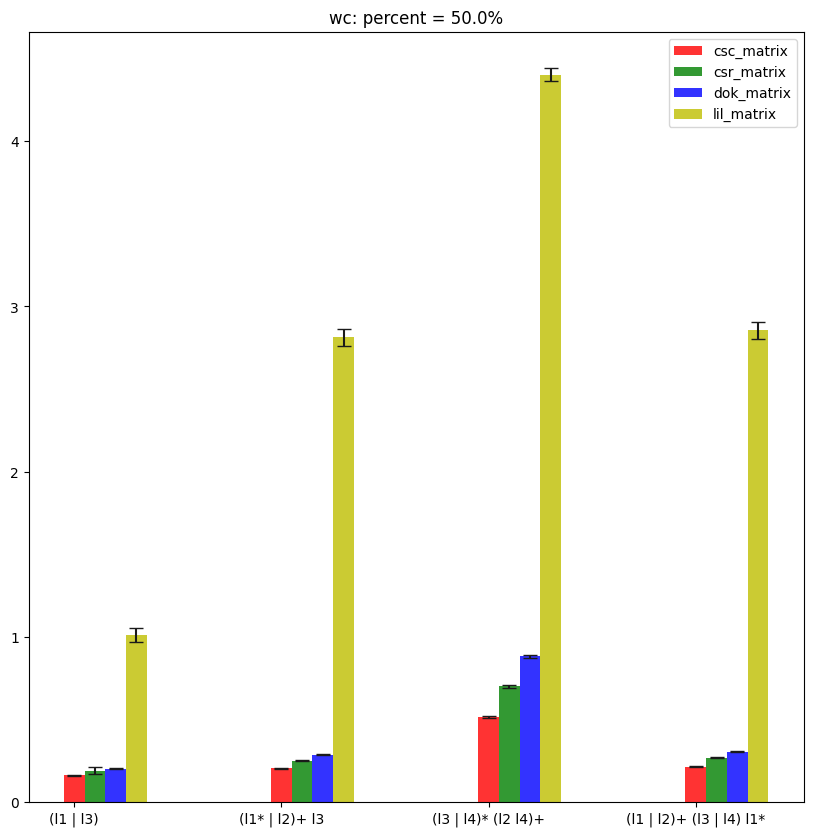

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


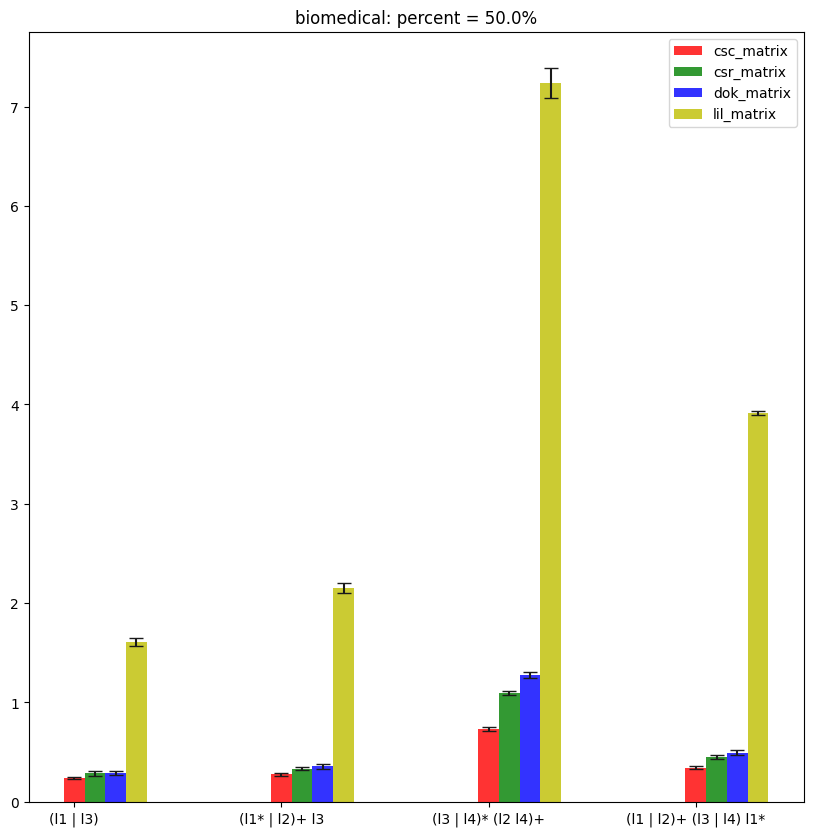

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


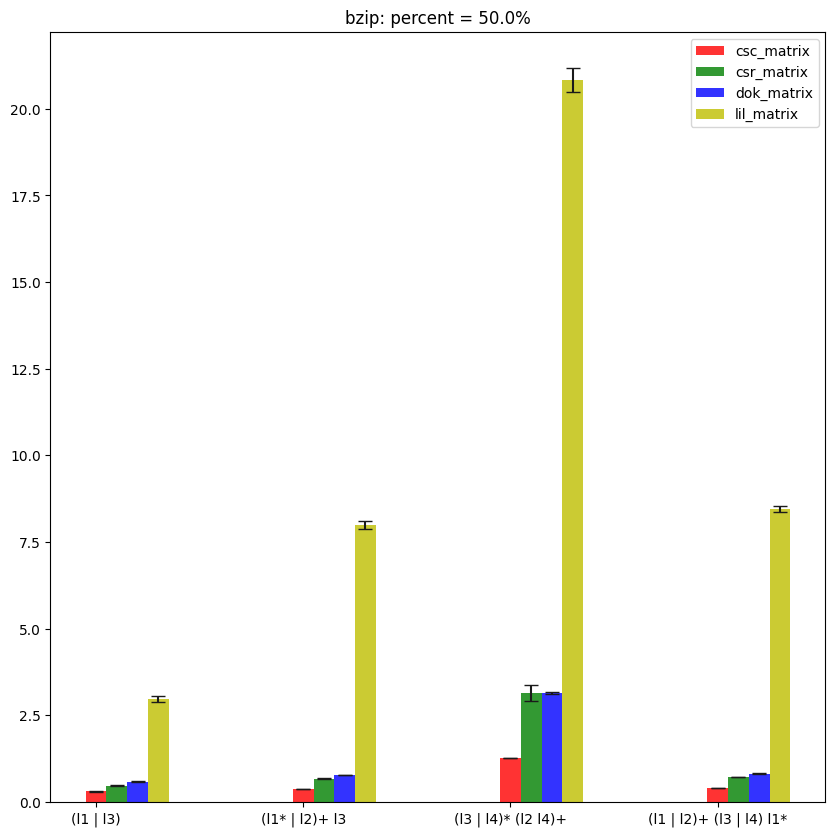

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


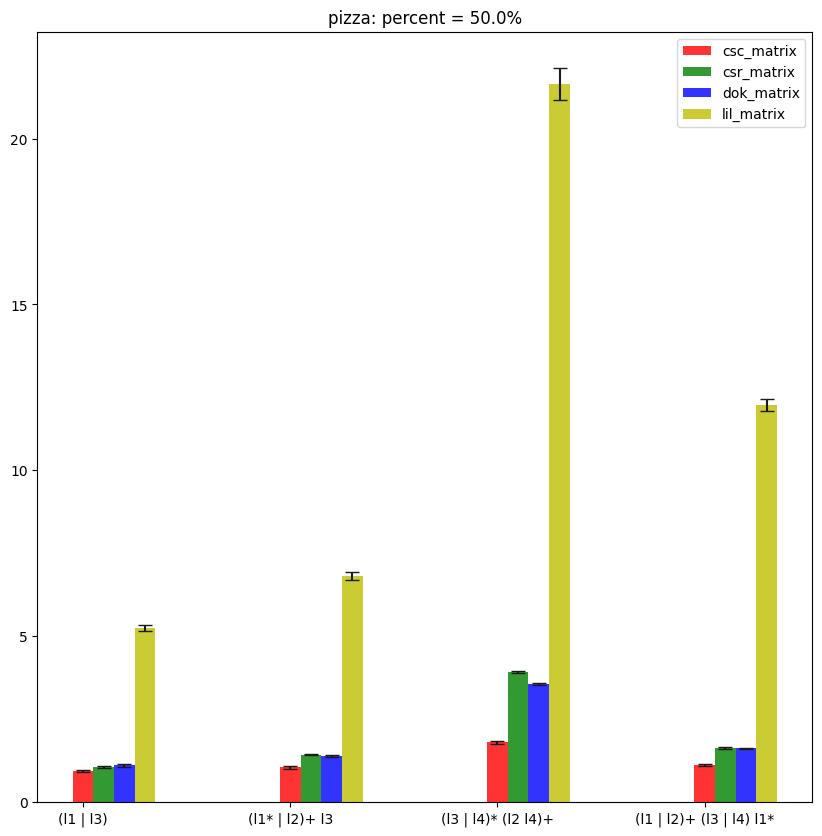

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


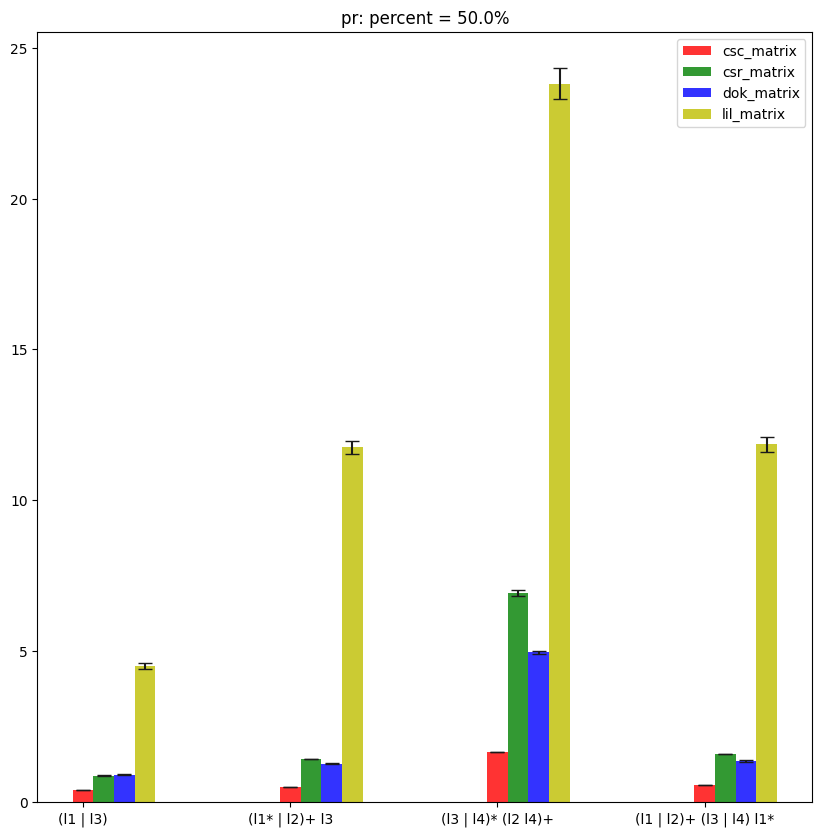

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


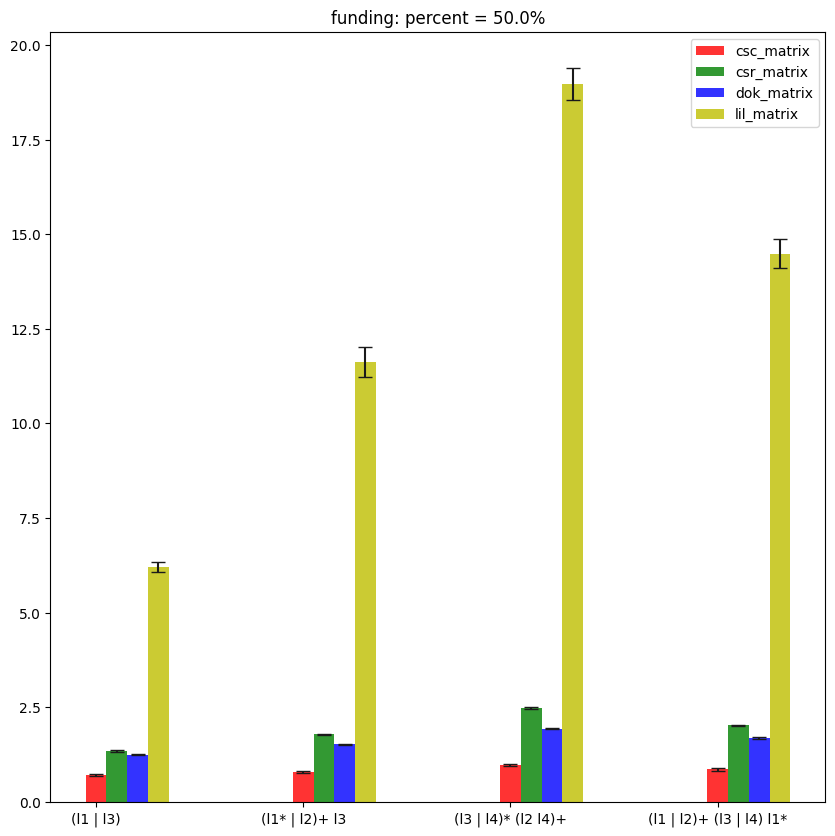

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


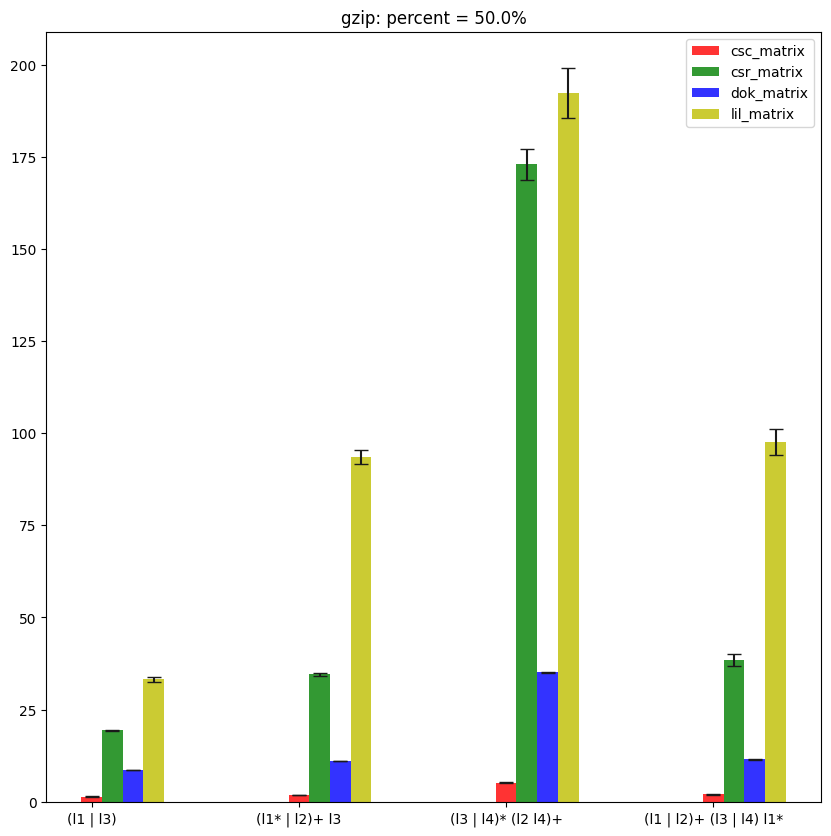

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


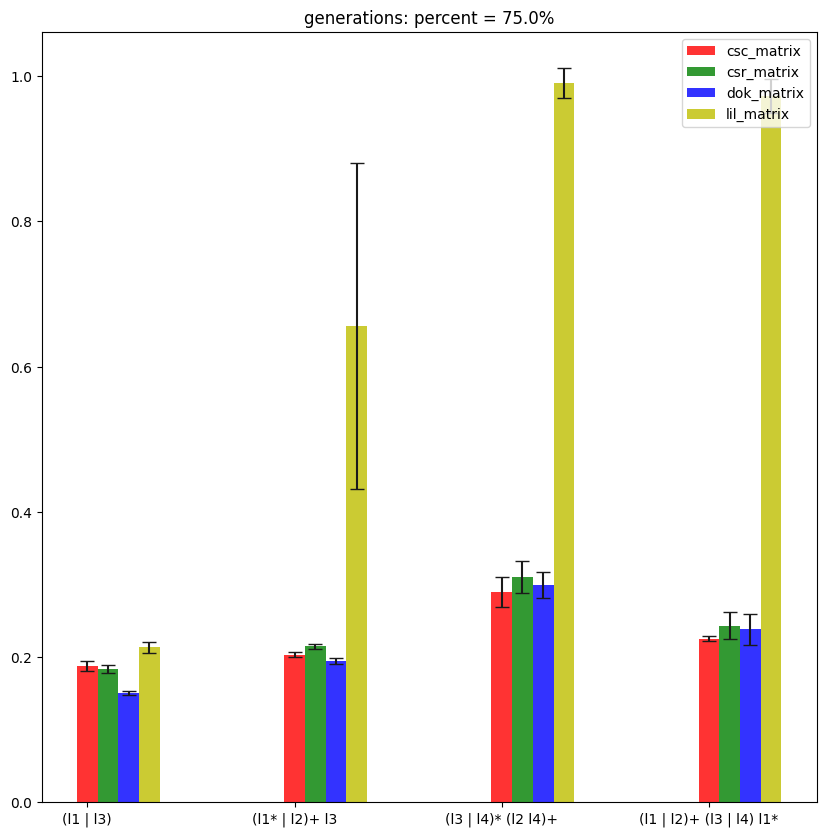

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


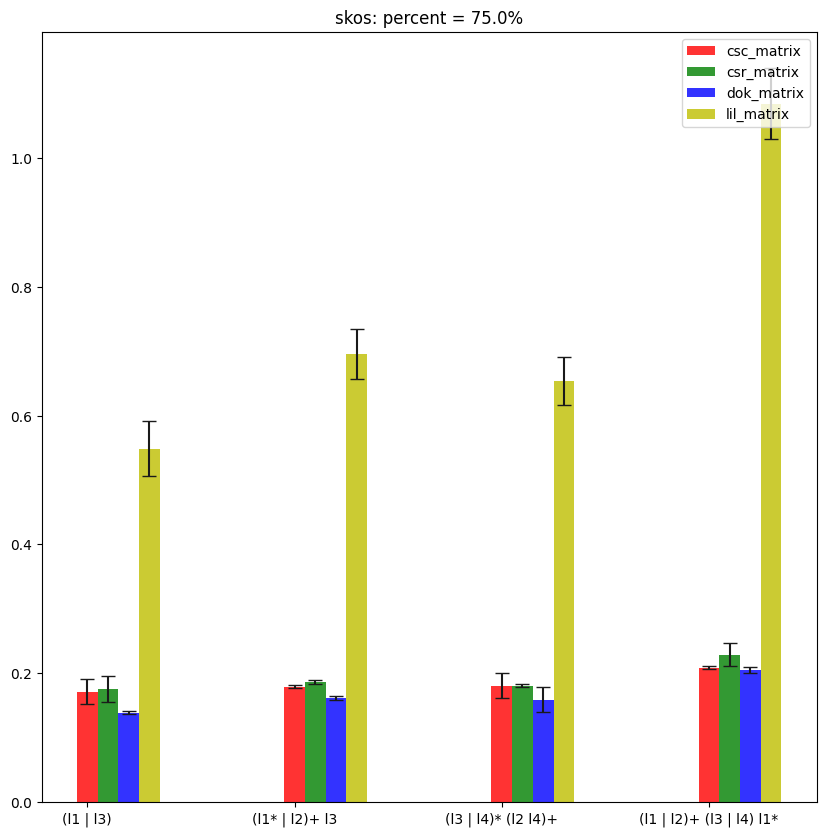

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


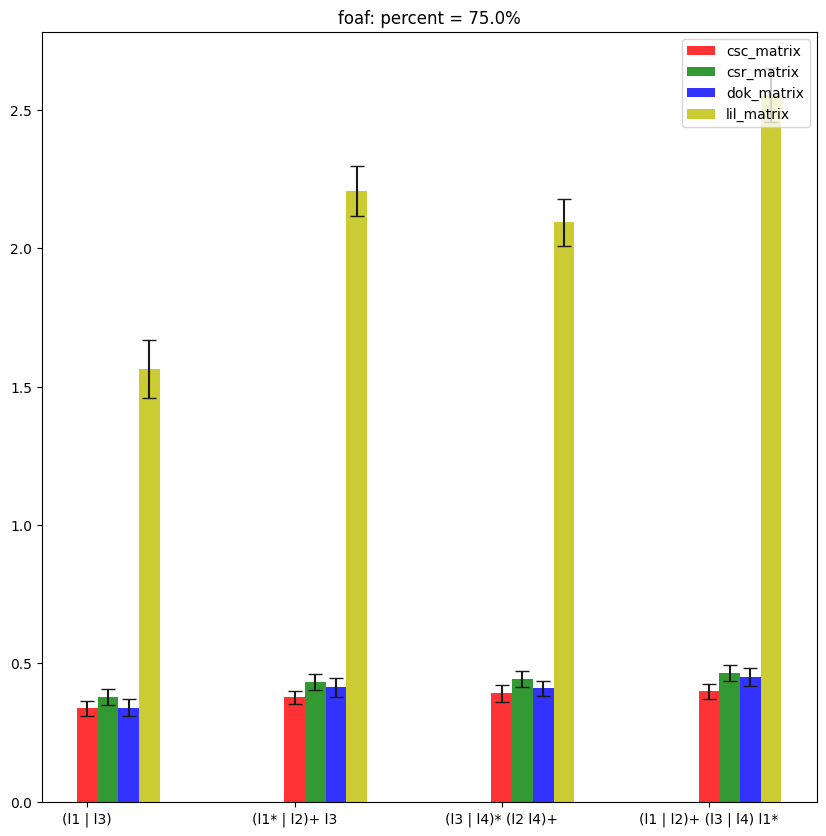

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


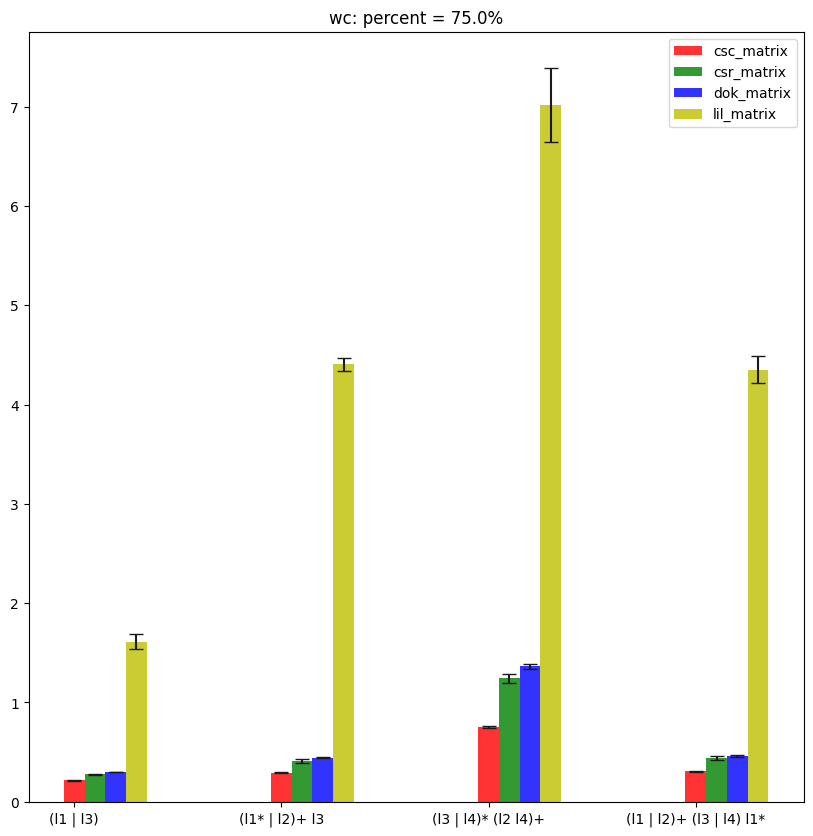

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


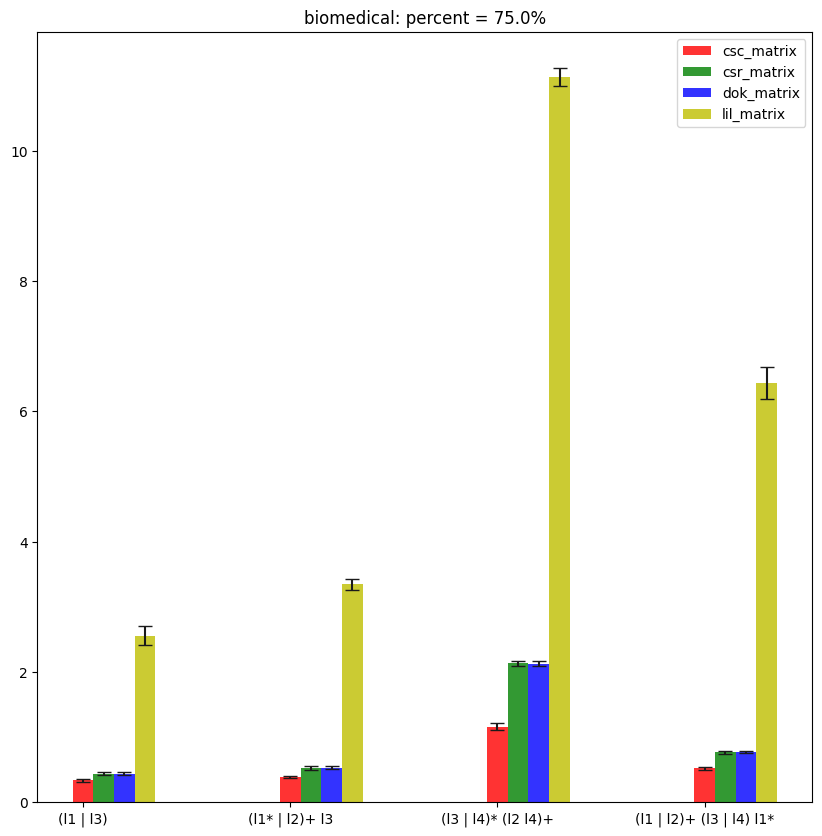

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


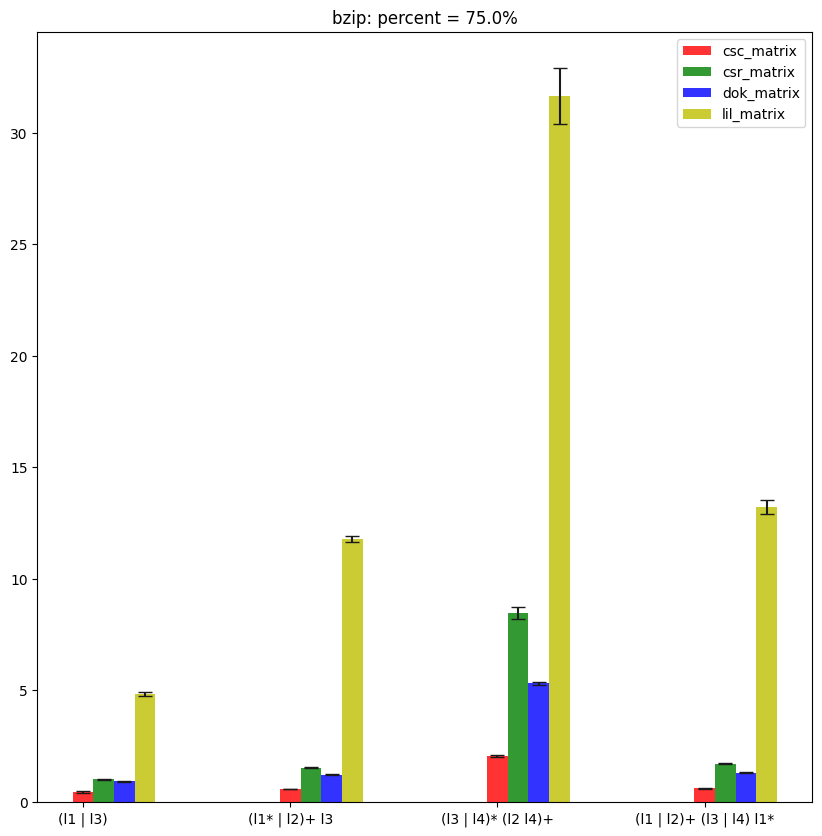

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


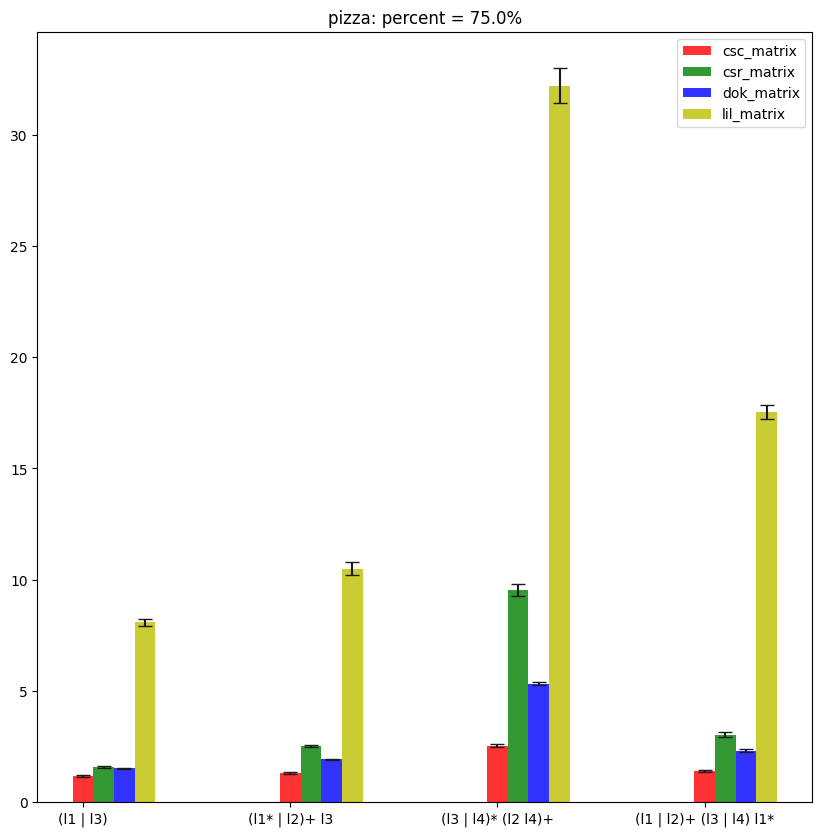

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


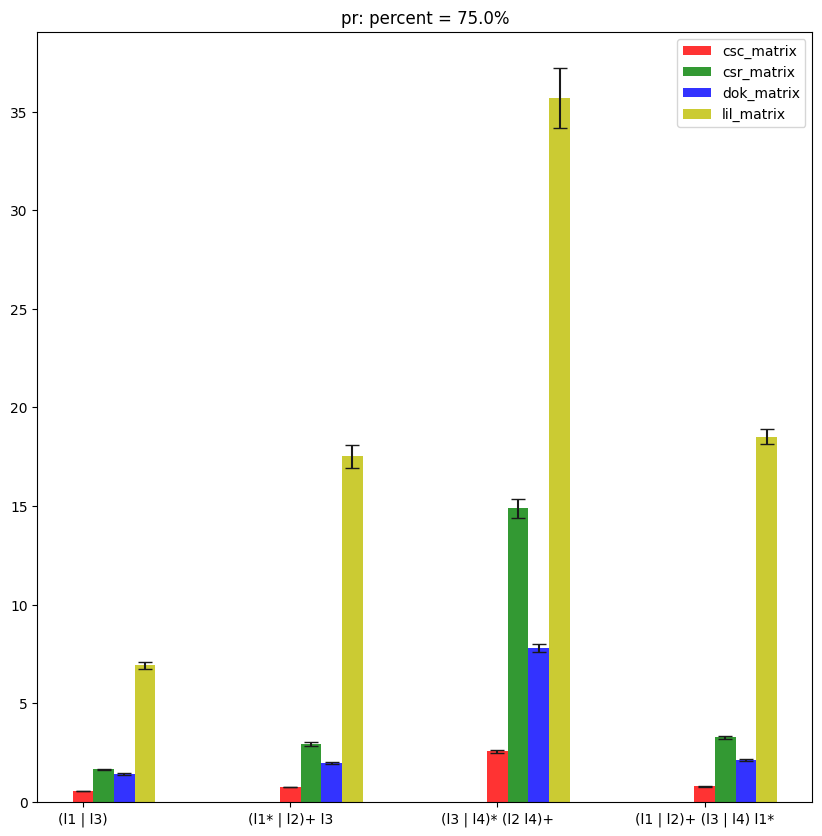

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


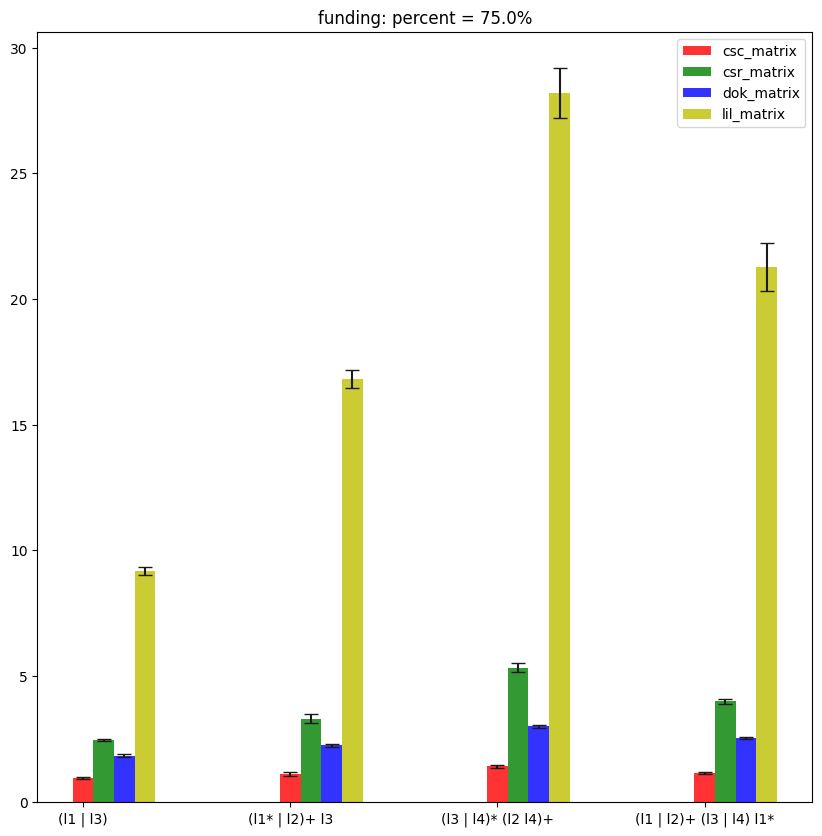

E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Semester5\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


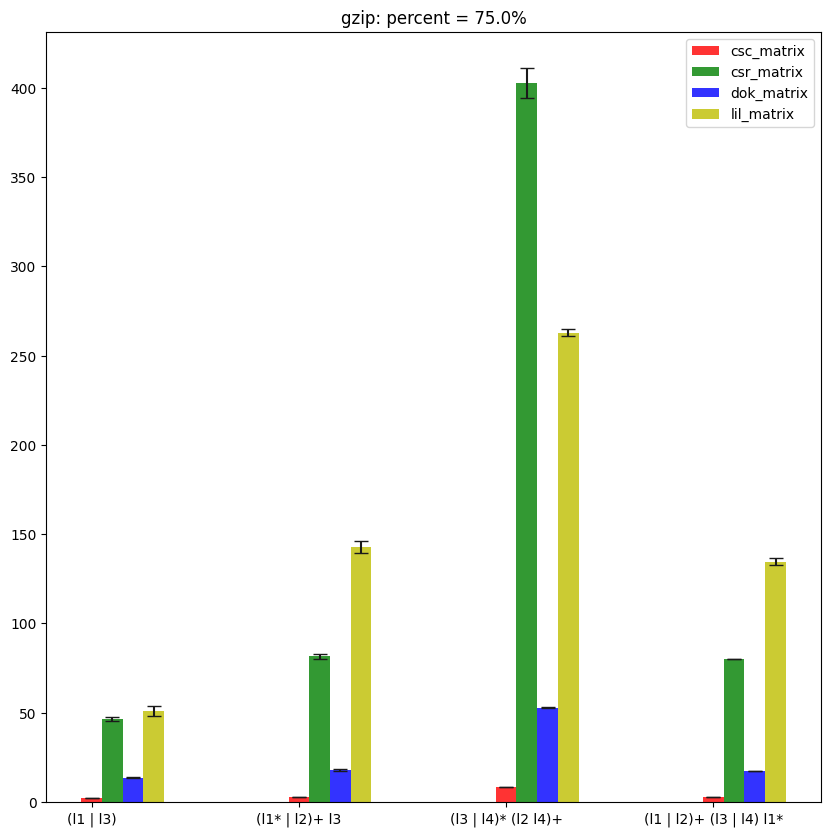

name percent  lil_matrix_time  lil_matrix_tstd  \
0           all_pair_tensor     100         0.156080         0.020080   
0              all_pair_bfs     100         0.169762         0.024241   
0  grouped_start_set_tensor    10.0         0.149138         0.018213   
0  grouped_start_set_tensor    20.0         0.152614         0.019816   
0  grouped_start_set_tensor    50.0         0.151832         0.019391   
0  grouped_start_set_tensor    75.0         0.155173         0.021394   
0     grouped_start_set_bfs    10.0         0.169616         0.024403   
0     grouped_start_set_bfs    20.0         0.171766         0.023978   
0     grouped_start_set_bfs    50.0         0.170588         0.024580   
0     grouped_start_set_bfs    75.0         0.171966         0.025355   
0   single_start_set_tensor    10.0         0.148940         0.018669   
0   single_start_set_tensor    20.0         0.150241         0.019107   
0   single_start_set_tensor    50.0         0.152412         0.020895   
0   single_start_set_tensor    75.0         0.153289         0.020204   
0      single_start_set_bfs    10.0         3.135676         0.072766   
0      single_start_set_bfs    20.0         6.151197         0.130815   
0      single_start_set_bfs    50.0        16.014351         0.440399   
0      single_start_set_bfs    75.0        23.258130         0.511009   

   dok_matrix_time  dok_matrix_tstd  csr_matrix_time  csr_matrix_tstd  \
0         0.162223         0.020487         0.145940         0.017727   
0         0.176780         0.018813         0.295483         0.017593   
0         0.153946         0.018673         0.140217         0.016705   
0         0.155978         0.019003         0.141444         0.017250   
0         0.156163         0.017040         0.140490         0.015512   
0         0.157555         0.015015         0.143415         0.017208   
0         0.158924         0.016301         0.230129         0.017819   
0         0.164964         0.014817         0.236317         0.016748   
0         0.170292         0.015471         0.257589         0.018012   
0         0.175912         0.016815         0.275929         0.016376   
0         0.154547         0.017192         0.139062         0.017393   
0         0.153799         0.015724         0.139677         0.017072   
0         0.155576         0.015464         0.142532         0.017050   
0         0.157664         0.017721         0.142731         0.016633   
0         0.565737         0.016450         0.522053         0.017011   
0         1.026465         0.017909         1.340160         0.027485   
0         2.510470         0.026553         7.574377         0.183440   
0         3.828531         0.058549        17.183707         0.327715   

   csc_matrix_time  csc_matrix_tstd  
0         0.146700         0.018145  
0         0.305924         0.017422  
0         0.140410         0.018863  
0         0.142192         0.016911  
0         0.142694         0.018364  
0         0.142776         0.016112  
0         0.230515         0.016145  
0         0.239835         0.017437  
0         0.263892         0.018697  
0         0.283657         0.015475  
0         0.141306         0.016944  
0         0.139904         0.016358  
0         0.141029         0.015446  
0         0.142697         0.016403  
0         0.311696         0.017899  
0         0.412191         0.017574  
0         0.730265         0.018685  
0         1.050612         0.026150

In [32]:
for percent in percents:
    results = rpq_request_performance_check(percent=percent, rpq_type="bfs", is_single_mode=True)
    final_statistic = update_statistic("single_start_set_bfs", percent, results, final_statistic)
final_statistic

# Выводы и ответы на вопросы

## На основе полученных результатов в процессе эксперимента, можно ответить на изначально заданные вопросы следующим образом: 
### 1.  Сложно выделить существенные преимущества одного представления над другим. 
   - На алгоритмах с применением Tensor Multy: `csc_matrix` и `csr_matrix` примерно одинаковы по скорости и незначительно лучше остальных представлений.
   - На алгоритмах с применением BFS:
      - `grouped_start_set` - наилучшим по времени работы является применение `dok_matrix`, а следом идет `lil_matrix`. Также стоит отметить, что в данном случае существенно хуже работают `csc_matrix` и `csr_matrix`
      - `single_start_set` - явное преимущество у алгоритмов с `csc_matrix` и `dok_matrix`. При этом `lil_matrix` и `csr_matrix` однозначно не предназначены для данного алгоритма.
   - Таким образом, `csc_matrix` в общем показал себя лучше остальных представлений, если рассматривать весь эксперимент целиком.
### 2. Анализируя результаты, приведенные в `final_statistic`, следует рассматривать только алгоритм с `BFS`, так как `Tensor Multy` слишком быстр и отличия заметить невозможно. Таким образом, можно заметить из графиков, что до 75% `решать задачу для всех пар и выбирать нужные` либо `решать задачу только для выбранных пар` практически эквивалентно по времени. Однако тенденция с возрастанием времени работы для алгоритма `с выбранными парами`, показывает, что далее будет эффективнее `решать задачу для всех пар и выбирать нужные` как для алгоритма Tensor Multy, так и для алгоритма с применением BFS.
### 3. Говоря про анализируемые нами графы из датасета (до ~3000 вершин и ~2000 ребер), можно сделать вывод о том, что алгоритмы достижимости `для всего класса в целом` относительно `для каждой стартовой вершины из заданного множества` (bfs) отрабатывают намного лучше по времени независимо от количества стартовых вершин (10%, 20%, 50%, 75%). А с дальнейшим ростом процента стартовых вершин, а также размеров графов, второй алгоритм занимает сильно больше времени из-за увеличения кол-ва матричных умножений.